In [17]:
#Stochastic with Delay and Isolation and a waiting for test compartment No persistance , Verion 4

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


def estBetaParams(mu, var):
    alpha=((1 - mu) / var - 1 / mu) * mu**2
    beta=alpha * (1 / mu - 1)
    return alpha,beta

def estGammaParams(mu,var):
    shape=(mu**2)/var
    scale=var/mu
    return shape, scale


#Non-Stochastic Parameters Parameters

N = 10**6           #250000               # Total population
p_3months = 0.3          # Proportion tested every 3 months
p_12months = 1-p_3months         # Proportion tested every 12 months
tau = 7             # This is our key parameter; the average return time for tests.

# The (weighted) average testing proportion for our population (proportion per day)
average_daily_testing_proportion = (p_3months/91 + p_12months/365)
tests_per_day=N*average_daily_testing_proportion
# I think that the generic person will get tested with this probability each day, and so the waiting
# time for a test from any given instant is 1/average_testing_proportion (exponential waiting time)
# No.... maybe it should be with rate tests_per_day??

# Initial conditions
E0 = 0.1 * N             # Initial exposed individuals.
X0 = N - E0              # Initial susceptible individuals.
S0 = 0                   # Initial symptomatic individuals (we assume the symptoms are NOTICEABLE). Symptomatic Individuals are assumed to isolate.
A_u0 = 0               # Initial asymptomatic individuals who are untested.
A_t0 = 0                 # Initial asympt. who are tested and awating a positive. These individuals will NOT isolate. 
A_pos0 = 0                 # Initial asympt. positive test. These people are isolating. 
                   # Initial people with complications 

#note: we will assume perfect isolation
#note: since we are assuming routine testing, we assume that testees do not change their habits unless
#      they receive a positive test. 
#note: We assume that people who become symptomatic right away are unlikely to develop severe disease. 

#Initial Stochastic parameters:

#Stochastic params
#np.random.seed(123) #get rid of this for simulations

#beta is the transmission rate, infection probability is beta with mean 0.8
# times (3 partners per month) distributed like a gamma dist. 
beta = np.random.beta(estBetaParams(0.6,0.01)[0],estBetaParams(0.6,0.01)[1])*np.random.gamma(estGammaParams(4,1)[0],estGammaParams(4,1)[1])/30  

# Rate of progression from exposed to infectious. We assume exposed individuals are not transmitting. 
# Duration here is assumed to be gamma. Small constant added for numerical stability
epsilon = 1/(np.random.gamma(estGammaParams(5,1)[0],estGammaParams(5,1)[1])+0.000000000000001)  

# Recovery rate for individuals undergoing treatment. 
# Assumed to be gamma with mean 7 days+- 1 day. Small constant added for numerical stability
gamma_t = 1/(np.random.gamma(estGammaParams(7,1)[0],estGammaParams(7,1)[1])+0.00000000000001) 

# proportion of infected, asymptomatic individuals who become symptomaitc. Assumed to be 
# beta with expected value 0.10 (10% chance)
theta=np.random.beta(estBetaParams(0.1,0.01)[0],estBetaParams(0.1,0.01)[1])

# Natural recovery rate for untreated individuals who will self-clear (estimated to be about 2 weeks) !!Find Ref!
# Assumed to be gamma. Small constant added for numerical stability. 
gamma_u = 1/(np.random.gamma(estGammaParams(14,3)[0],estGammaParams(14,3)[1])+0.00000000000001) 

# Proportion developing asymptomatic infection
# Assumed to be beta with expected value 0.8 and variance 0.01
lambda_ = np.random.beta(estBetaParams(0.8,0.01)[0],estBetaParams(0.8,0.01)[1]) 

# Amount of time someone should wait until their next test:
# Assumed to be exponential with rate average_testing_proportion.
# small constant added for numerical stability
omega_t = 1/(np.random.exponential(tests_per_day)+0.00000000000001) #not sure if I need this guy... 

# #Rate of test return. 1/wait time to return tests
# Assumed to be gamma with expected value tau and variance 1. Small constant added for numerical stability.
omega_r = 1/(np.random.gamma(estGammaParams(tau,1)[0], estGammaParams(tau,1)[1])+0.00000000000001)
# THIS is the key value. 

# Risk of complications
# Assumed to be beta with expected value 0.0225
#eta = np.random.beta(estBetaParams(0.0225,0.0075**2)[0],estBetaParams(0.0225,0.0075**2)[1])
#Not necessary. factor into the final prediction. 
    

In [27]:

#Define the Model 

def model(Y, t, beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion , tau, N):
  
    
    X, E, S, A_u, A_t, A_pos= Y
    
    
    # Here, we assume that the only groups driving the spread of infection are the asymptomatic who have not received a positive test
    dXdt = -beta*X*(A_u+A_t)/N + gamma_t*S  + gamma_t*A_pos + gamma_u*A_t + (1-theta)*gamma_u*A_u
    
    
    dEdt = beta*X*(A_u+A_t)/N - epsilon*E
    
    
    dSdt = (1-lambda_)*epsilon*E + theta*gamma_u*A_u - gamma_t*S 
     
    
    dA_udt = lambda_*epsilon*E - average_daily_testing_proportion*A_u - gamma_u*A_u #I want some proportion to clear, and some proportion to become infectious
    
    dA_tdt = average_daily_testing_proportion*A_u - omega_r*A_t - gamma_u*A_t
    
    
    dA_posdt = omega_r*A_t - gamma_t*A_pos
    
    
    
    
    return [dXdt, dEdt, dSdt, dA_udt, dA_tdt, dA_posdt]



In [19]:
#Simulation 

# Time array: Simulate over 5 years

print("hello world..")

t_points = np.linspace(0, 100 * 365, 100 * 365)


# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6

# Loop over each day and solve the ODEs
solution = np.zeros((len(t_points), 6))
solution[0] = [X0, E0, S0, A_u0, A_t0, A_pos0]


params=[] #Save daily rates for use later 

for i in range(1, len(t_points)):
    
    #Stochastic params
    beta = np.random.beta(estBetaParams(0.9,0.01)[0],estBetaParams(0.9,0.01)[1])*np.random.gamma(estGammaParams(2.85,1)[0],estGammaParams(2.85,1)[1])/30  
    epsilon = 1/(np.random.gamma(estGammaParams(5,1)[0],estGammaParams(5,1)[1])+0.000000000000001)  
    gamma_t = 1/(np.random.gamma(estGammaParams(7,1)[0],estGammaParams(7,1)[1])+0.00000000000001) 
    theta=np.random.beta(estBetaParams(0.1,0.01)[0],estBetaParams(0.1,0.01)[1])
    gamma_u = 1/(np.random.gamma(estGammaParams(14,3)[0],estGammaParams(14,3)[1])+0.00000000000001) 
    lambda_ = np.random.beta(estBetaParams(0.9,0.01)[0],estBetaParams(0.9,0.01)[1]) 
    omega_r = 1/(np.random.gamma(estGammaParams(tau,1)[0], estGammaParams(tau,1)[1])+0.00000000000001)
    eta = np.random.beta(estBetaParams(0.0225,0.0075**2)[0],estBetaParams(0.0225,0.0075**2)[1])
    
    #record these for average yearly rates later.
    params.append([beta,epsilon,gamma_t,theta,gamma_u,lambda_,omega_r,eta])
    
    tspan = [t_points[i-1], t_points[i]]
    
    ys = odeint(model, solution[i-1], tspan, args=(beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion, tau, N), atol=abserr, rtol=relerr)
    
     # Update the solution
    solution[i] = ys[-1]
    print(i, solution[i], sum(solution[i]))
    
    
    

hello world..
1 [9.00034848e+05 8.16447483e+04 1.54211378e+03 1.67336999e+04
 4.27824640e+01 1.80809119e+00] 999999.9999999995
2 [9.00610729e+05 6.89324187e+04 1.60648383e+03 2.86942858e+04
 1.40998935e+02 1.50837497e+01] 999999.999999999
3 [9.01268544e+05 6.07827498e+04 3.39775860e+03 3.42480773e+04
 2.61876094e+02 4.09941025e+01] 999999.9999999991
4 [9.01977294e+05 5.21678728e+04 3.76991325e+03 4.16183181e+04
 3.84121194e+02 8.24804497e+01] 999999.999999999
5 [9.01159805e+05 4.96252816e+04 3.65979411e+03 4.49078574e+04
 4.91025415e+02 1.56236573e+02] 999999.9999999988
6 [9.02741676e+05 3.96114486e+04 3.29359751e+03 5.35132428e+04
 6.29969168e+02 2.10066030e+02] 999999.9999999988
7 [9.05086414e+05 3.40780435e+04 3.54231187e+03 5.62485581e+04
 7.68010512e+02 2.76662112e+02] 999999.9999999992
8 [9.06173450e+05 2.98485852e+04 3.58773325e+03 5.91542933e+04
 8.81025000e+02 3.54913299e+02] 999999.999999999
9 [9.05888236e+05 2.44651869e+04 4.30473389e+03 6.39154483e+04
 9.80787153e+02 4.4560

402 [9.64561511e+05 9.69648821e+03 2.26533495e+03 2.24190212e+04
 5.01085226e+02 5.56559499e+02] 999999.999999993
403 [9.65125730e+05 9.16471361e+03 2.36243654e+03 2.22830245e+04
 5.02606477e+02 5.61488743e+02] 999999.999999993
404 [9.64501055e+05 8.71189664e+03 2.93938016e+03 2.27694016e+04
 4.83507009e+02 5.94759309e+02] 999999.9999999931
405 [9.62107814e+05 1.13424149e+04 3.18971910e+03 2.22808416e+04
 4.98574818e+02 5.80635914e+02] 999999.999999993
406 [9.62059701e+05 1.11954827e+04 2.98763081e+03 2.26713780e+04
 4.98891885e+02 5.86915912e+02] 999999.9999999932
407 [9.61419033e+05 1.19940335e+04 2.79448680e+03 2.27103436e+04
 5.22601233e+02 5.59502003e+02] 999999.9999999932
408 [9.61173947e+05 1.16896903e+04 2.60502807e+03 2.34326962e+04
 5.48272969e+02 5.50365232e+02] 999999.9999999931
409 [9.61770158e+05 1.11838816e+04 2.41544019e+03 2.35321416e+04
 5.37311485e+02 5.61066868e+02] 999999.9999999931
410 [9.62796873e+05 1.00961102e+04 2.39824700e+03 2.36090966e+04
 5.34830824e+02 5.

735 [9.80440049e+05 4.86670062e+03 1.02348310e+03 1.30186332e+04
 3.21702656e+02 3.29431214e+02] 999999.9999999938
736 [9.80301910e+05 4.79832793e+03 1.31023867e+03 1.29394020e+04
 3.27333320e+02 3.22788318e+02] 999999.9999999938
737 [9.81098299e+05 4.62971455e+03 1.20006603e+03 1.24280551e+04
 3.20948932e+02 3.22916233e+02] 999999.9999999937
738 [9.81425844e+05 4.29786038e+03 1.23420430e+03 1.23964801e+04
 3.16436460e+02 3.29174637e+02] 999999.9999999935
739 [9.80832762e+05 4.99385333e+03 1.15704452e+03 1.23772593e+04
 2.92244836e+02 3.46835496e+02] 999999.9999999932
740 [9.81234980e+05 4.38845053e+03 1.15373995e+03 1.25893807e+04
 2.98812346e+02 3.34636259e+02] 999999.999999993
741 [9.81682121e+05 4.01416908e+03 1.23054140e+03 1.24403891e+04
 3.01439565e+02 3.31339864e+02] 999999.9999999932
742 [9.81808329e+05 4.24519820e+03 1.10573523e+03 1.22197287e+04
 2.92465344e+02 3.28543163e+02] 999999.9999999929
743 [9.82116796e+05 3.82731883e+03 1.32738594e+03 1.21127894e+04
 2.96604478e+02 

1016 [9.79163907e+05 5.36416312e+03 1.34904555e+03 1.34928918e+04
 3.20969417e+02 3.09022890e+02] 999999.99999999
1017 [9.79491295e+05 4.43791086e+03 1.78536339e+03 1.36487413e+04
 3.25597292e+02 3.11092606e+02] 999999.9999999899
1018 [9.79970224e+05 4.33991941e+03 1.64396502e+03 1.34105733e+04
 3.08980260e+02 3.26337890e+02] 999999.9999999899
1019 [9.80398247e+05 4.03439264e+03 1.42643077e+03 1.35053574e+04
 3.20156810e+02 3.15415557e+02] 999999.9999999901
1020 [9.80081663e+05 4.15109745e+03 1.41639484e+03 1.37008736e+04
 3.11808185e+02 3.38162731e+02] 999999.99999999
1021 [9.80200204e+05 3.94350462e+03 1.35473347e+03 1.38434522e+04
 3.23589120e+02 3.34516200e+02] 999999.99999999
1022 [9.79573767e+05 4.82100070e+03 1.43365735e+03 1.35134068e+04
 3.34742822e+02 3.23425253e+02] 999999.99999999
1023 [9.79222772e+05 5.41139489e+03 1.70470987e+03 1.30018888e+04
 3.33614049e+02 3.25620639e+02] 999999.99999999
1024 [9.80193554e+05 4.73499437e+03 1.52035177e+03 1.28998968e+04
 3.32137985e+02 

1313 [9.78445497e+05 5.36955845e+03 1.45157893e+03 1.40730399e+04
 3.34939085e+02 3.25386821e+02] 999999.999999988
1314 [9.78817628e+05 4.80265280e+03 1.34968905e+03 1.43574647e+04
 3.34429090e+02 3.38136798e+02] 999999.9999999881
1315 [9.78127886e+05 5.66334258e+03 1.25788528e+03 1.42853204e+04
 3.39663207e+02 3.25902446e+02] 999999.9999999881
1316 [9.78735531e+05 4.98354525e+03 1.31974368e+03 1.42859700e+04
 3.43779061e+02 3.31431277e+02] 999999.9999999879
1317 [9.78417159e+05 5.16550977e+03 1.44426362e+03 1.42894658e+04
 3.42592335e+02 3.41009128e+02] 999999.999999988
1318 [9.78074888e+05 5.69549672e+03 1.28538404e+03 1.42634836e+04
 3.35226882e+02 3.45520717e+02] 999999.9999999881
1319 [9.78438592e+05 5.49534193e+03 1.28983141e+03 1.41096727e+04
 3.34885580e+02 3.31676244e+02] 999999.9999999878
1320 [9.78841549e+05 5.04739794e+03 1.19096977e+03 1.42463636e+04
 3.32653666e+02 3.41065611e+02] 999999.9999999879
1321 [9.79152746e+05 5.12133434e+03 1.11354363e+03 1.39487265e+04
 3.38220

 3.28017323e+02 2.90521727e+02] 999999.999999987
1616 [9.79840186e+05 5.67211849e+03 1.45261957e+03 1.24076796e+04
 3.32323428e+02 2.95072866e+02] 999999.999999987
1617 [9.80168638e+05 5.37383534e+03 1.60698107e+03 1.22359340e+04
 3.22281104e+02 2.92330907e+02] 999999.9999999871
1618 [9.79665733e+05 5.77746990e+03 1.64426818e+03 1.23017443e+04
 3.12070400e+02 2.98714528e+02] 999999.9999999872
1619 [9.79979604e+05 5.53857895e+03 1.57001255e+03 1.22968780e+04
 3.14416064e+02 3.00510091e+02] 999999.9999999868
1620 [9.80243000e+05 5.50458636e+03 1.66859344e+03 1.19665206e+04
 3.16461414e+02 3.00838527e+02] 999999.9999999868
1621 [9.79999603e+05 5.73721717e+03 1.74351200e+03 1.19061694e+04
 3.16405411e+02 2.97092622e+02] 999999.9999999866
1622 [9.80197154e+05 5.82275429e+03 1.62006300e+03 1.17394441e+04
 3.16855658e+02 3.03728726e+02] 999999.9999999866
1623 [9.80333720e+05 5.09842106e+03 1.59403598e+03 1.23542438e+04
 3.19982819e+02 2.99596758e+02] 999999.9999999865
1624 [9.80946252e+05 4.5

 1.93874235e+02 2.10366809e+02] 999999.9999999873
1953 [9.87894545e+05 2.86324843e+03 8.04553237e+02 8.03275219e+03
 1.93177772e+02 2.11723455e+02] 999999.9999999871
1954 [9.88243236e+05 2.70986294e+03 7.60019773e+02 7.88236009e+03
 1.86740353e+02 2.17781300e+02] 999999.9999999871
1955 [9.88491159e+05 2.47117601e+03 7.12761481e+02 7.92318616e+03
 1.91452281e+02 2.10264801e+02] 999999.9999999872
1956 [9.88377508e+05 2.72456762e+03 6.52587456e+02 7.84491325e+03
 1.86016688e+02 2.14406554e+02] 999999.999999987
1957 [9.87984631e+05 3.10880637e+03 6.36079006e+02 7.87200495e+03
 1.85399737e+02 2.13078942e+02] 999999.9999999867
1958 [9.88245311e+05 2.97687993e+03 5.98633093e+02 7.78193947e+03
 1.78246976e+02 2.18989441e+02] 999999.9999999867
1959 [9.87631787e+05 3.64162466e+03 5.71148532e+02 7.76002780e+03
 1.79814945e+02 2.15597309e+02] 999999.9999999867
1960 [9.87843965e+05 3.49095088e+03 5.00239972e+02 7.78102665e+03
 1.79771006e+02 2.04046565e+02] 999999.9999999866
1961 [9.88042267e+05 3.

2243 [9.85219287e+05 4.24602372e+03 6.93352729e+02 9.38977093e+03
 2.18346661e+02 2.33219436e+02] 999999.9999999857
2244 [9.85627601e+05 3.62892140e+03 7.64651473e+02 9.53100717e+03
 2.19950581e+02 2.27868151e+02] 999999.9999999856
2245 [9.85373635e+05 3.94117417e+03 1.09949550e+03 9.13726840e+03
 2.15704965e+02 2.32721503e+02] 999999.9999999856
2246 [9.85122115e+05 4.15189329e+03 1.11827557e+03 9.16039340e+03
 2.14605210e+02 2.32717796e+02] 999999.9999999858
2247 [9.85101248e+05 3.91110603e+03 1.03520440e+03 9.50567279e+03
 2.14930193e+02 2.31839007e+02] 999999.9999999856
2248 [9.85090307e+05 4.05121501e+03 9.27581366e+02 9.48277752e+03
 2.19685375e+02 2.28433672e+02] 999999.9999999859
2249 [9.85357484e+05 3.60073810e+03 8.05928886e+02 9.79074116e+03
 2.26551017e+02 2.18557175e+02] 999999.9999999857
2250 [9.85534714e+05 3.74005416e+03 9.22297584e+02 9.35022816e+03
 2.25757013e+02 2.26948724e+02] 999999.9999999854
2251 [9.85694524e+05 3.59784702e+03 8.31247792e+02 9.43393149e+03
 2.195

2620 [9.95958427e+05 1.07379510e+03 2.84047198e+02 2.55404540e+03
 6.57975123e+01 6.38882259e+01] 999999.999999985
2621 [9.95911508e+05 1.15679448e+03 3.15194556e+02 2.48920556e+03
 6.32942704e+01 6.40034600e+01] 999999.999999985
2622 [9.95995875e+05 1.03133070e+03 3.26751755e+02 2.51924226e+03
 6.34436230e+01 6.33566597e+01] 999999.999999985
2623 [9.95998013e+05 1.07599926e+03 2.89479446e+02 2.50957953e+03
 6.40880458e+01 6.28412144e+01] 999999.999999985
2624 [9.96051014e+05 1.02278591e+03 2.73413933e+02 2.52553768e+03
 6.51192435e+01 6.21292673e+01] 999999.9999999851
2625 [9.96089641e+05 9.69863368e+02 2.88997137e+02 2.52324878e+03
 6.55565414e+01 6.26927005e+01] 999999.9999999846
2626 [9.96041127e+05 1.04820402e+03 2.81949644e+02 2.50155710e+03
 6.18850094e+01 6.52776069e+01] 999999.9999999846
2627 [9.95989740e+05 1.02287728e+03 2.90446993e+02 2.56941095e+03
 6.35740695e+01 6.39505186e+01] 999999.9999999844
2628 [9.95959245e+05 1.13203729e+03 2.76640309e+02 2.50590188e+03
 6.3629008

2962 [9.96149476e+05 9.83929598e+02 3.08015900e+02 2.44180217e+03
 6.17003252e+01 5.50762526e+01] 999999.9999999801
2963 [9.96133852e+05 1.00689008e+03 3.29758699e+02 2.41327010e+03
 6.21645857e+01 5.40645381e+01] 999999.9999999799
2964 [9.96155553e+05 1.01153453e+03 3.27427075e+02 2.38900752e+03
 6.15157399e+01 5.49617835e+01] 999999.9999999799
2965 [9.96284412e+05 9.16378205e+02 3.22205366e+02 2.36210857e+03
 6.00213989e+01 5.48747540e+01] 999999.9999999799
2966 [9.96429970e+05 8.43903173e+02 3.14804908e+02 2.29822382e+03
 5.80847746e+01 5.50130540e+01] 999999.9999999797
2967 [9.96441873e+05 8.20771385e+02 3.01546270e+02 2.32109554e+03
 5.90942336e+01 5.56199388e+01] 999999.99999998
2968 [9.96475524e+05 8.13296844e+02 2.73393956e+02 2.32282022e+03
 5.70718242e+01 5.78936345e+01] 999999.99999998
2969 [9.96365319e+05 8.74882131e+02 2.78712585e+02 2.36539871e+03
 5.53640265e+01 6.03234641e+01] 999999.99999998
2970 [9.96306800e+05 9.21032767e+02 3.01625931e+02 2.35423881e+03
 5.51550401e

3255 [9.93613473e+05 1.59222655e+03 3.71352647e+02 4.23700207e+03
 9.84898164e+01 8.74561281e+01] 999999.9999999799
3256 [9.93796295e+05 1.40192951e+03 4.11831655e+02 4.20359348e+03
 1.02352375e+02 8.39984211e+01] 999999.9999999797
3257 [9.93867120e+05 1.35078814e+03 4.06965788e+02 4.18559497e+03
 1.02475759e+02 8.70557899e+01] 999999.9999999796
3258 [9.94034473e+05 1.24210303e+03 4.16552090e+02 4.11794380e+03
 1.00968887e+02 8.79590586e+01] 999999.9999999796
3259 [9.94037586e+05 1.35105476e+03 4.28135636e+02 3.99579993e+03
 9.88982106e+01 8.85256973e+01] 999999.9999999795
3260 [9.94076266e+05 1.43410198e+03 4.24797829e+02 3.87158467e+03
 9.89405354e+01 9.43087509e+01] 999999.9999999793
3261 [9.93903474e+05 1.64483644e+03 3.89080725e+02 3.86967023e+03
 9.85197107e+01 9.44189175e+01] 999999.9999999792
3262 [9.93990515e+05 1.59631936e+03 3.82791373e+02 3.83557835e+03
 1.00361951e+02 9.44341558e+01] 999999.999999979
3263 [9.94033543e+05 1.49668323e+03 3.83339553e+02 3.89283041e+03
 9.5775

3589 [9.96109034e+05 9.38681445e+02 2.83484332e+02 2.54516277e+03
 6.29348516e+01 6.07027434e+01] 999999.9999999813
3590 [9.96158641e+05 9.30924630e+02 3.29025682e+02 2.45553578e+03
 6.25239229e+01 6.33489403e+01] 999999.9999999815
3591 [9.96083320e+05 9.72395526e+02 3.25642915e+02 2.49154132e+03
 6.18105270e+01 6.52893432e+01] 999999.9999999818
3592 [9.95999644e+05 1.06898539e+03 2.83959613e+02 2.52101224e+03
 6.21777023e+01 6.42207160e+01] 999999.9999999818
3593 [9.96026347e+05 1.03747995e+03 2.77983003e+02 2.53051291e+03
 6.17096552e+01 6.59679712e+01] 999999.9999999817
3594 [9.96120858e+05 9.69424653e+02 2.53813437e+02 2.52787368e+03
 6.14723936e+01 6.65575248e+01] 999999.9999999818
3595 [9.96268420e+05 9.76326694e+02 2.40489958e+02 2.38922022e+03
 5.92711642e+01 6.62718434e+01] 999999.9999999818
3596 [9.96229934e+05 1.05093520e+03 2.41092428e+02 2.35261524e+03
 5.97829617e+01 6.56401350e+01] 999999.9999999818
3597 [9.96274025e+05 9.37559563e+02 2.78595656e+02 2.38512371e+03
 5.816

3900 [9.95089063e+05 1.39378431e+03 3.40703947e+02 3.03049042e+03
 7.63125490e+01 6.96461177e+01] 999999.9999999797
3901 [9.95224423e+05 1.23299158e+03 3.04503686e+02 3.09018787e+03
 7.88999428e+01 6.89937680e+01] 999999.9999999795
3902 [9.94946609e+05 1.51582940e+03 3.37513346e+02 3.05206005e+03
 7.80203566e+01 6.99674526e+01] 999999.9999999794
3903 [9.94943993e+05 1.56890978e+03 3.39474096e+02 3.00065674e+03
 7.46448231e+01 7.23215365e+01] 999999.9999999789
3904 [9.94908020e+05 1.48142117e+03 3.63999749e+02 3.09923419e+03
 7.20904025e+01 7.52342668e+01] 999999.9999999788
3905 [9.94540325e+05 1.72790626e+03 4.03050877e+02 3.17885809e+03
 7.04891709e+01 7.93702459e+01] 999999.9999999788
3906 [9.94606609e+05 1.68179325e+03 3.82082431e+02 3.17848011e+03
 7.07225838e+01 8.03130229e+01] 999999.9999999788
3907 [9.94677653e+05 1.54041692e+03 3.85958497e+02 3.24450927e+03
 7.33998551e+01 7.80625713e+01] 999999.9999999786
3908 [9.94861756e+05 1.26883696e+03 3.77465425e+02 3.33846515e+03
 7.251

4266 [9.94531837e+05 1.42546484e+03 3.76206306e+02 3.49266108e+03
 8.90953249e+01 8.47356555e+01] 999999.9999999788
4267 [9.94519907e+05 1.28665364e+03 3.85429060e+02 3.63415796e+03
 8.77694396e+01 8.60831911e+01] 999999.999999979
4268 [9.94383535e+05 1.38559479e+03 4.13784481e+02 3.64179829e+03
 8.85199870e+01 8.67672931e+01] 999999.9999999787
4269 [9.94399370e+05 1.34432194e+03 4.60803161e+02 3.61880243e+03
 8.79586600e+01 8.87439425e+01] 999999.9999999788
4270 [9.94519400e+05 1.28415586e+03 4.17342268e+02 3.60406624e+03
 8.73534202e+01 8.76826260e+01] 999999.9999999786
4271 [9.94581710e+05 1.22180258e+03 4.34229449e+02 3.58687544e+03
 8.93467839e+01 8.60353918e+01] 999999.9999999787
4272 [9.94563803e+05 1.26499413e+03 5.03379022e+02 3.49041003e+03
 8.96490112e+01 8.77644802e+01] 999999.9999999789
4273 [9.94731898e+05 1.19434074e+03 4.69809439e+02 3.42772859e+03
 8.92169406e+01 8.70064637e+01] 999999.999999979
4274 [9.94731479e+05 1.33648012e+03 4.62602118e+02 3.29514679e+03
 8.64677

 1.19177244e+02 1.20320107e+02] 999999.9999999801
4628 [9.92361494e+05 2.05782090e+03 4.55814664e+02 4.88999999e+03
 1.15287167e+02 1.19582951e+02] 999999.9999999802
4629 [9.92396702e+05 2.00396927e+03 5.43325343e+02 4.82318343e+03
 1.15697403e+02 1.17122877e+02] 999999.9999999803
4630 [9.92666989e+05 1.81498619e+03 5.03363443e+02 4.78210890e+03
 1.15009491e+02 1.17542990e+02] 999999.9999999806
4631 [9.92688199e+05 1.79397393e+03 4.88178058e+02 4.79623644e+03
 1.17041840e+02 1.16370451e+02] 999999.9999999806
4632 [9.92822164e+05 1.82021249e+03 4.51387412e+02 4.67277455e+03
 1.19799080e+02 1.13662217e+02] 999999.9999999803
4633 [9.92638689e+05 2.13914052e+03 4.26245779e+02 4.56835991e+03
 1.19374811e+02 1.08189594e+02] 999999.9999999807
4634 [9.92734802e+05 2.06715272e+03 3.79606787e+02 4.59348820e+03
 1.18306526e+02 1.06644117e+02] 999999.9999999806
4635 [9.92987315e+05 1.87131429e+03 4.09198460e+02 4.50693799e+03
 1.17775629e+02 1.07458731e+02] 999999.9999999803
4636 [9.93234233e+05 1

 9.49546338e+01 8.49317217e+01] 999999.9999999776
4957 [9.93463664e+05 1.84898631e+03 3.84498663e+02 4.12061847e+03
 9.20674065e+01 9.01647905e+01] 999999.9999999775
4958 [9.93414911e+05 1.92795921e+03 3.39082561e+02 4.13620954e+03
 9.46503213e+01 8.71869635e+01] 999999.9999999773
4959 [9.93634439e+05 1.71646635e+03 3.46062678e+02 4.12436376e+03
 9.39871412e+01 8.46814995e+01] 999999.9999999774
4960 [9.93412532e+05 1.81587408e+03 3.95317207e+02 4.19195010e+03
 9.80031221e+01 8.63236577e+01] 999999.9999999775
4961 [9.93269586e+05 1.81889923e+03 4.58171458e+02 4.26951379e+03
 1.00163490e+02 8.36657415e+01] 999999.9999999778
4962 [9.93323350e+05 1.74140418e+03 4.15856349e+02 4.33161106e+03
 1.01092515e+02 8.66859729e+01] 999999.9999999779
4963 [9.93307302e+05 1.77447884e+03 4.12213411e+02 4.31710594e+03
 1.02598790e+02 8.63011366e+01] 999999.9999999779
4964 [9.93125699e+05 1.94231688e+03 3.95229941e+02 4.34470317e+03
 1.03819420e+02 8.82319186e+01] 999999.9999999779
4965 [9.93040212e+05 1

5308 [9.93155043e+05 1.60370368e+03 5.29988828e+02 4.50195688e+03
 1.03354628e+02 1.05953164e+02] 999999.9999999772
5309 [9.92948689e+05 1.75289748e+03 5.48175338e+02 4.53417640e+03
 1.07966893e+02 1.08095370e+02] 999999.9999999773
5310 [9.93117215e+05 1.68313224e+03 5.55544341e+02 4.43012166e+03
 1.05275743e+02 1.08711423e+02] 999999.9999999772
5311 [9.93133436e+05 1.67732153e+03 5.07699279e+02 4.46992851e+03
 1.07098089e+02 1.04517084e+02] 999999.9999999774
5312 [9.93133600e+05 1.61401890e+03 4.90581389e+02 4.54860233e+03
 1.07333541e+02 1.05864075e+02] 999999.9999999772
5313 [9.93194638e+05 1.56763784e+03 4.43557811e+02 4.57770071e+03
 1.12368284e+02 1.04096938e+02] 999999.9999999772
5314 [9.93149453e+05 1.78466052e+03 5.09250164e+02 4.33926427e+03
 1.10740819e+02 1.06631347e+02] 999999.9999999771
5315 [9.93061225e+05 1.95884060e+03 4.52651312e+02 4.31197306e+03
 1.09181566e+02 1.06128575e+02] 999999.9999999772
5316 [9.93136440e+05 1.91878341e+03 4.87293657e+02 4.24496792e+03
 1.082

5657 [9.86911374e+05 3.02242146e+03 7.35411605e+02 8.91858261e+03
 2.03455886e+02 2.08754526e+02] 999999.9999999767
5658 [9.86810398e+05 3.40291592e+03 8.09577687e+02 8.56277580e+03
 2.02097183e+02 2.12235621e+02] 999999.9999999767
5659 [9.86894766e+05 3.37315473e+03 7.49147060e+02 8.56968135e+03
 2.05869348e+02 2.07381066e+02] 999999.999999977
5660 [9.86830828e+05 3.58380422e+03 6.96332101e+02 8.47772692e+03
 2.09129587e+02 2.02179494e+02] 999999.9999999768
5661 [9.87179790e+05 2.75607186e+03 7.40743301e+02 8.90591714e+03
 2.15303075e+02 2.02174644e+02] 999999.999999977
5662 [9.87174358e+05 2.97369682e+03 6.61017509e+02 8.77803997e+03
 2.16179847e+02 1.96707900e+02] 999999.9999999771
5663 [9.87039605e+05 3.28899770e+03 6.26357889e+02 8.62672016e+03
 2.14224249e+02 2.04094580e+02] 999999.9999999772
5664 [9.86909162e+05 3.58864105e+03 6.51650714e+02 8.43219730e+03
 2.07344295e+02 2.11004443e+02] 999999.9999999772
5665 [9.86959182e+05 3.42018258e+03 7.49453396e+02 8.45963051e+03
 2.10044

5964 [9.79667394e+05 4.79491932e+03 1.49028982e+03 1.33543386e+04
 3.13294669e+02 3.79763639e+02] 999999.9999999761
5965 [9.79731495e+05 4.29302183e+03 1.64080715e+03 1.36532481e+04
 3.09928125e+02 3.71499545e+02] 999999.9999999763
5966 [9.79946093e+05 4.28091707e+03 1.50591674e+03 1.35883442e+04
 3.12778914e+02 3.65949885e+02] 999999.9999999763
5967 [9.80162428e+05 4.01635830e+03 1.79479176e+03 1.33501782e+04
 3.15267634e+02 3.60976588e+02] 999999.9999999763
5968 [9.80695393e+05 3.82822020e+03 1.62115557e+03 1.31900960e+04
 3.19369238e+02 3.45765635e+02] 999999.9999999763
5969 [9.81140044e+05 3.84028007e+03 1.56009619e+03 1.27953026e+04
 3.16630965e+02 3.47646290e+02] 999999.9999999764
5970 [9.81465492e+05 3.90343259e+03 1.36690174e+03 1.26179415e+04
 3.20613599e+02 3.25618928e+02] 999999.9999999765
5971 [9.81559048e+05 4.23091140e+03 1.35960895e+03 1.22178265e+04
 3.19774621e+02 3.12830760e+02] 999999.9999999765
5972 [9.82144931e+05 4.07455245e+03 1.25958947e+03 1.19017446e+04
 3.052

6232 [9.80792726e+05 4.60108556e+03 1.15323643e+03 1.28587241e+04
 3.12026331e+02 2.82201794e+02] 999999.9999999776
6233 [9.80759756e+05 4.63612568e+03 1.09577578e+03 1.29072413e+04
 3.11101288e+02 2.90000238e+02] 999999.9999999776
6234 [9.81289334e+05 4.57507533e+03 9.93542261e+02 1.25390948e+04
 2.95653829e+02 3.07300003e+02] 999999.9999999775
6235 [9.81610451e+05 4.40817158e+03 9.42140863e+02 1.24305803e+04
 3.01254596e+02 3.07401664e+02] 999999.9999999775
6236 [9.80919011e+05 4.98727643e+03 1.15228004e+03 1.23235575e+04
 2.99709087e+02 3.18166239e+02] 999999.9999999778
6237 [9.80758801e+05 5.39156233e+03 1.12547208e+03 1.21155308e+04
 3.06903567e+02 3.01730064e+02] 999999.9999999779
6238 [9.80978492e+05 4.68359830e+03 1.31718220e+03 1.24070468e+04
 3.08986168e+02 3.04694447e+02] 999999.9999999776
6239 [9.81028823e+05 4.99581734e+03 1.13359241e+03 1.22344190e+04
 3.07320153e+02 3.00028170e+02] 999999.9999999779
6240 [9.81584267e+05 4.30624212e+03 1.06402792e+03 1.24435557e+04
 2.953

6571 [9.81933928e+05 4.85634723e+03 1.19666870e+03 1.14595741e+04
 2.85981457e+02 2.67500329e+02] 999999.9999999767
6572 [9.81899246e+05 4.72168210e+03 1.20735155e+03 1.16144546e+04
 2.81648849e+02 2.75617136e+02] 999999.9999999767
6573 [9.82144882e+05 4.52545487e+03 1.45400364e+03 1.13058917e+04
 2.80593941e+02 2.89173538e+02] 999999.9999999764
6574 [9.82589567e+05 4.38102230e+03 1.36304402e+03 1.11090154e+04
 2.72345667e+02 2.85005728e+02] 999999.999999976
6575 [9.82692238e+05 4.33788908e+03 1.28122074e+03 1.11357543e+04
 2.72229369e+02 2.80668211e+02] 999999.9999999761
6576 [9.82466905e+05 4.39692919e+03 1.62109039e+03 1.09706911e+04
 2.63130605e+02 2.81253917e+02] 999999.9999999763
6577 [9.82068847e+05 4.83137712e+03 1.58311891e+03 1.09720729e+04
 2.64270741e+02 2.80313025e+02] 999999.9999999761
6578 [9.81729034e+05 4.76599879e+03 1.58700199e+03 1.13757133e+04
 2.61865745e+02 2.80385761e+02] 999999.9999999763
6579 [9.82134832e+05 4.40002630e+03 1.50192777e+03 1.14125606e+04
 2.6591

6907 [9.88928711e+05 2.79818263e+03 5.73140267e+02 7.36967240e+03
 1.64888949e+02 1.65404755e+02] 999999.999999974
6908 [9.88911960e+05 2.90395267e+03 5.46003324e+02 7.30479263e+03
 1.65201641e+02 1.68089481e+02] 999999.9999999744
6909 [9.89134854e+05 2.69445287e+03 5.05804344e+02 7.32952615e+03
 1.65995958e+02 1.69367034e+02] 999999.9999999743
6910 [9.88978803e+05 2.59094752e+03 5.28630428e+02 7.55654959e+03
 1.70649327e+02 1.74419997e+02] 999999.9999999743
6911 [9.88007925e+05 3.47647966e+03 4.72973471e+02 7.70256785e+03
 1.74039165e+02 1.66015078e+02] 999999.9999999745
6912 [9.87538469e+05 3.94019503e+03 4.84466984e+02 7.68943541e+03
 1.72739468e+02 1.74693668e+02] 999999.9999999744
6913 [9.87791126e+05 3.76634528e+03 4.93560084e+02 7.59935221e+03
 1.74518508e+02 1.75098130e+02] 999999.9999999746
6914 [9.87914080e+05 3.47368283e+03 5.12910164e+02 7.74748674e+03
 1.78932167e+02 1.72907805e+02] 999999.9999999746
6915 [9.86979805e+05 4.33257793e+03 6.56772820e+02 7.67426032e+03
 1.8439

 1.10564649e+02 1.14469051e+02] 999999.9999999695
7200 [9.92678534e+05 1.96077147e+03 5.78710118e+02 4.55817772e+03
 1.06850636e+02 1.16955564e+02] 999999.9999999696
7201 [9.92732467e+05 1.85866408e+03 5.56955623e+02 4.62845725e+03
 1.07438453e+02 1.16017192e+02] 999999.9999999695
7202 [9.92702395e+05 1.91880481e+03 5.91715482e+02 4.57392356e+03
 1.06970395e+02 1.06190570e+02] 999999.9999999694
7203 [9.92965970e+05 1.71649622e+03 5.66344286e+02 4.53420206e+03
 1.07721182e+02 1.09266015e+02] 999999.9999999693
7204 [9.93050248e+05 1.77138823e+03 5.23575212e+02 4.43779425e+03
 1.05320731e+02 1.11674020e+02] 999999.999999969
7205 [9.93092397e+05 1.79278538e+03 4.79996171e+02 4.41896437e+03
 1.08632846e+02 1.07223778e+02] 999999.9999999693
7206 [9.93174746e+05 1.80359039e+03 4.42572003e+02 4.36545859e+03
 1.03535290e+02 1.10097514e+02] 999999.9999999694
7207 [9.93092386e+05 1.83188334e+03 4.72923795e+02 4.38580063e+03
 1.06945718e+02 1.10060506e+02] 999999.9999999695
7208 [9.93199079e+05 1.

7546 [9.95683187e+05 1.17841191e+03 2.12673684e+02 2.79467663e+03
 6.67097985e+01 6.43413376e+01] 999999.9999999676
7547 [9.95774639e+05 1.06477384e+03 2.11164006e+02 2.81825202e+03
 6.67398493e+01 6.44307877e+01] 999999.9999999679
7548 [9.95752948e+05 1.15609392e+03 2.02638300e+02 2.75566851e+03
 6.71820177e+01 6.54694115e+01] 999999.9999999681
7549 [9.95710645e+05 1.03805107e+03 2.27507949e+02 2.88998412e+03
 6.89886788e+01 6.48236045e+01] 999999.9999999678
7550 [9.95696608e+05 1.08128341e+03 2.23957574e+02 2.86361959e+03
 6.95027244e+01 6.50290089e+01] 999999.9999999678
7551 [9.95741430e+05 1.04298698e+03 2.41882162e+02 2.83674921e+03
 7.05727103e+01 6.63790050e+01] 999999.9999999678
7552 [9.95590259e+05 1.17557693e+03 2.28915543e+02 2.86740348e+03
 7.14574268e+01 6.63871635e+01] 999999.9999999676
7553 [9.95659086e+05 1.19227722e+03 2.46899069e+02 2.76471937e+03
 6.63235982e+01 7.06946396e+01] 999999.9999999673
7554 [9.95652612e+05 1.17889121e+03 2.39179543e+02 2.79562164e+03
 6.653

7885 [9.96854917e+05 7.55741193e+02 1.38015619e+02 2.14992836e+03
 5.18855307e+01 4.95126168e+01] 999999.9999999643
7886 [9.96851189e+05 7.88003146e+02 1.71936306e+02 2.08663269e+03
 5.05635464e+01 5.16753848e+01] 999999.9999999646
7887 [9.96724480e+05 8.41788284e+02 2.07478804e+02 2.12327897e+03
 4.88751090e+01 5.40988693e+01] 999999.9999999641
7888 [9.96625648e+05 9.15644068e+02 1.93886875e+02 2.16160746e+03
 5.07939873e+01 5.24193901e+01] 999999.9999999644
7889 [9.96643220e+05 8.66507349e+02 2.15817578e+02 2.17042304e+03
 5.08612785e+01 5.31706533e+01] 999999.9999999646
7890 [9.96591429e+05 8.96945135e+02 2.18200158e+02 2.18922673e+03
 5.14672033e+01 5.27314674e+01] 999999.9999999646
7891 [9.96564156e+05 9.24473310e+02 2.01352107e+02 2.20599215e+03
 5.08043438e+01 5.32219852e+01] 999999.9999999646
7892 [9.96478794e+05 9.82377145e+02 2.00961681e+02 2.23340855e+03
 5.32284429e+01 5.12301025e+01] 999999.9999999647
7893 [9.96513050e+05 1.00388272e+03 1.84984913e+02 2.19388351e+03
 5.228

8231 [9.97151558e+05 7.16093620e+02 2.22849992e+02 1.81552233e+03
 4.87696491e+01 4.52062738e+01] 999999.9999999634
8232 [9.97153636e+05 7.79789058e+02 1.98920149e+02 1.77452254e+03
 4.77997605e+01 4.53327778e+01] 999999.9999999634
8233 [9.97140239e+05 7.83390108e+02 1.81079653e+02 1.80234514e+03
 4.76186297e+01 4.53269757e+01] 999999.9999999636
8234 [9.97206583e+05 7.36758173e+02 1.75936017e+02 1.78824891e+03
 4.61962480e+01 4.62774675e+01] 999999.9999999637
8235 [9.97179582e+05 7.38941923e+02 1.92087758e+02 1.79549792e+03
 4.56719755e+01 4.82187043e+01] 999999.9999999638
8236 [9.97238126e+05 6.49419725e+02 1.83122465e+02 1.83569754e+03
 4.51754532e+01 4.84588106e+01] 999999.999999964
8237 [9.97292968e+05 6.57099824e+02 1.78691425e+02 1.77863857e+03
 4.44012155e+01 4.82005708e+01] 999999.9999999637
8238 [9.97340029e+05 6.30743527e+02 1.85034962e+02 1.75281675e+03
 4.41285912e+01 4.72472491e+01] 999999.9999999639
8239 [9.97322378e+05 6.40784884e+02 1.69329903e+02 1.77781032e+03
 4.3823

8578 [9.95773627e+05 1.08844092e+03 2.75122634e+02 2.73952428e+03
 6.39045589e+01 5.93805289e+01] 999999.9999999658
8579 [9.95817513e+05 9.94580623e+02 2.61161703e+02 2.79991528e+03
 6.66243444e+01 6.02047768e+01] 999999.9999999657
8580 [9.95881209e+05 8.99600495e+02 2.81706074e+02 2.81001312e+03
 6.71430090e+01 6.03283554e+01] 999999.9999999658
8581 [9.95884068e+05 9.85371885e+02 2.52066087e+02 2.75171738e+03
 6.48917078e+01 6.18848224e+01] 999999.9999999658
8582 [9.95910751e+05 1.06367938e+03 2.37148360e+02 2.66106364e+03
 6.56016341e+01 6.17559714e+01] 999999.9999999659
8583 [9.95994695e+05 9.99126158e+02 2.35931565e+02 2.64287202e+03
 6.49181391e+01 6.24575868e+01] 999999.999999966
8584 [9.95991491e+05 9.45342309e+02 2.28987846e+02 2.70436946e+03
 6.53423697e+01 6.44669072e+01] 999999.999999966
8585 [9.95805968e+05 1.21484531e+03 2.08031385e+02 2.64202388e+03
 6.35984449e+01 6.55326687e+01] 999999.9999999659
8586 [9.95728659e+05 1.18371732e+03 2.13606907e+02 2.74372599e+03
 6.36228

 8.12027356e+01 8.46046022e+01] 999999.9999999634
8928 [9.94295300e+05 1.39213838e+03 6.08876446e+02 3.53666381e+03
 8.36228843e+01 8.33980756e+01] 999999.9999999636
8929 [9.94358494e+05 1.30679390e+03 5.56375606e+02 3.61070921e+03
 8.38087204e+01 8.38180830e+01] 999999.9999999633
8930 [9.94258564e+05 1.36938844e+03 5.30889683e+02 3.66923863e+03
 8.63501864e+01 8.55690692e+01] 999999.9999999632
8931 [9.94376843e+05 1.33074583e+03 4.82105238e+02 3.63626094e+03
 8.54286966e+01 8.86166181e+01] 999999.9999999633
8932 [9.94310014e+05 1.47736978e+03 4.22136011e+02 3.61746442e+03
 8.16291828e+01 9.13861982e+01] 999999.9999999633
8933 [9.94256691e+05 1.58691735e+03 3.85463805e+02 3.59807550e+03
 8.14056884e+01 9.14467667e+01] 999999.9999999634
8934 [9.94331860e+05 1.47495210e+03 3.42291712e+02 3.67644388e+03
 7.99852955e+01 9.44667317e+01] 999999.9999999634
8935 [9.94331649e+05 1.54927279e+03 3.98993457e+02 3.55198039e+03
 8.11597540e+01 8.69450808e+01] 999999.9999999636
8936 [9.94529898e+05 1

9291 [9.90587370e+05 2.79281134e+03 7.12206885e+02 5.66279676e+03
 1.17801375e+02 1.27013844e+02] 999999.9999999646
9292 [9.90387646e+05 2.78205425e+03 7.17193816e+02 5.86166895e+03
 1.23142283e+02 1.28294484e+02] 999999.9999999647
9293 [9.90352806e+05 2.76301937e+03 6.93275050e+02 5.93530091e+03
 1.31150518e+02 1.24448630e+02] 999999.999999965
9294 [9.90400920e+05 2.67309595e+03 5.97179728e+02 6.07222468e+03
 1.31312898e+02 1.25266428e+02] 999999.9999999648
9295 [9.90240054e+05 2.91555046e+03 5.77417161e+02 6.00756902e+03
 1.35964778e+02 1.23444182e+02] 999999.999999965
9296 [9.90459770e+05 2.64411931e+03 5.13705102e+02 6.11723152e+03
 1.40609123e+02 1.24565348e+02] 999999.9999999647
9297 [9.90199766e+05 2.83132103e+03 4.63999836e+02 6.23509903e+03
 1.41563333e+02 1.28250412e+02] 999999.9999999648
9298 [9.89719199e+05 3.29446863e+03 4.74666166e+02 6.24351361e+03
 1.39856439e+02 1.28295731e+02] 999999.9999999651
9299 [9.89242719e+05 3.56569331e+03 4.94862529e+02 6.42327030e+03
 1.37296

9633 [9.88871955e+05 2.91844127e+03 7.23607939e+02 7.15236349e+03
 1.62855052e+02 1.70777434e+02] 999999.9999999643
9634 [9.88752323e+05 3.04140711e+03 6.66603030e+02 7.20867634e+03
 1.70193334e+02 1.60797628e+02] 999999.9999999645
9635 [9.89123295e+05 2.59525032e+03 6.22058897e+02 7.32295074e+03
 1.73693199e+02 1.62751355e+02] 999999.9999999644
9636 [9.89061387e+05 2.80381503e+03 5.80719850e+02 7.21304302e+03
 1.75521860e+02 1.65513014e+02] 999999.9999999643
9637 [9.89262081e+05 2.53223239e+03 5.45836719e+02 7.32181866e+03
 1.77266156e+02 1.60764707e+02] 999999.9999999643
9638 [9.89006859e+05 2.88865911e+03 5.37347542e+02 7.22433980e+03
 1.73272026e+02 1.69522771e+02] 999999.9999999643
9639 [9.88845556e+05 2.96495026e+03 5.29868758e+02 7.31576990e+03
 1.77930392e+02 1.65924274e+02] 999999.9999999645
9640 [9.88738047e+05 3.27998630e+03 4.96559559e+02 7.14210944e+03
 1.77740049e+02 1.65557567e+02] 999999.999999964
9641 [9.88736987e+05 3.25708569e+03 5.83718904e+02 7.07481845e+03
 1.7983

9979 [9.91100491e+05 2.13402085e+03 6.33314971e+02 5.85143502e+03
 1.46528732e+02 1.34209672e+02] 999999.9999999658
9980 [9.90992455e+05 2.25240122e+03 5.88340343e+02 5.88189707e+03
 1.42242819e+02 1.42663829e+02] 999999.9999999655
9981 [9.91120328e+05 2.22315214e+03 5.75927909e+02 5.79956124e+03
 1.40839041e+02 1.40191734e+02] 999999.9999999657
9982 [9.90944351e+05 2.53168274e+03 6.25935927e+02 5.61996850e+03
 1.38319037e+02 1.39742856e+02] 999999.9999999657
9983 [9.91024823e+05 2.40911784e+03 6.86257772e+02 5.60444155e+03
 1.33402998e+02 1.41957289e+02] 999999.9999999655
9984 [9.91012293e+05 2.47589323e+03 6.32826776e+02 5.60414354e+03
 1.30437277e+02 1.44406109e+02] 999999.9999999658
9985 [9.91034369e+05 2.31273333e+03 8.46439886e+02 5.53115418e+03
 1.33564358e+02 1.41739475e+02] 999999.9999999657
9986 [9.91056219e+05 2.33307304e+03 7.57861804e+02 5.57912286e+03
 1.25490180e+02 1.48233275e+02] 999999.9999999654
9987 [9.91296628e+05 2.29526268e+03 7.29423379e+02 5.40604321e+03
 1.281

10322 [9.92277681e+05 2.23955125e+03 6.47358169e+02 4.60407422e+03
 1.16016282e+02 1.15319097e+02] 999999.9999999645
10323 [9.92203056e+05 2.27921339e+03 7.25600070e+02 4.56505310e+03
 1.13060976e+02 1.14016030e+02] 999999.9999999643
10324 [9.92401198e+05 2.13539851e+03 7.15959810e+02 4.52050183e+03
 1.12518579e+02 1.14422833e+02] 999999.9999999641
10325 [9.92168191e+05 2.17303688e+03 7.40690699e+02 4.68904047e+03
 1.14199510e+02 1.14841089e+02] 999999.9999999641
10326 [9.92550697e+05 1.75078857e+03 6.45227241e+02 4.82797476e+03
 1.09925293e+02 1.15387135e+02] 999999.9999999645
10327 [9.92534677e+05 1.83975769e+03 5.79973598e+02 4.82336211e+03
 1.10017804e+02 1.12212008e+02] 999999.9999999646
10328 [9.92547456e+05 1.81535350e+03 5.31337276e+02 4.88305968e+03
 1.09160785e+02 1.13633202e+02] 999999.9999999645
10329 [9.92396639e+05 1.98329107e+03 5.38388693e+02 4.86252228e+03
 1.03038821e+02 1.16120140e+02] 999999.9999999644
10330 [9.91871165e+05 2.41453948e+03 4.79907664e+02 5.01339701e+

10690 [9.92940825e+05 1.87914640e+03 4.90598569e+02 4.46692119e+03
 1.01424654e+02 1.21083881e+02] 999999.9999999615
10691 [9.92888057e+05 1.90517238e+03 5.01607060e+02 4.48495499e+03
 1.03215419e+02 1.16993013e+02] 999999.9999999616
10692 [9.93089899e+05 1.67944900e+03 4.91482884e+02 4.51567663e+03
 1.04178362e+02 1.19314150e+02] 999999.9999999616
10693 [9.93277121e+05 1.49952486e+03 5.54599568e+02 4.44114777e+03
 1.07282524e+02 1.20323885e+02] 999999.9999999616
10694 [9.93566573e+05 1.34663293e+03 5.75659625e+02 4.28540632e+03
 1.07101660e+02 1.18626455e+02] 999999.9999999612
10695 [9.93189632e+05 1.80031030e+03 5.85716049e+02 4.20519604e+03
 1.08732739e+02 1.10413048e+02] 999999.9999999614
10696 [9.93398414e+05 1.67272759e+03 5.69441538e+02 4.14245721e+03
 1.06883677e+02 1.10076295e+02] 999999.9999999614
10697 [9.93350762e+05 1.72747152e+03 5.04695514e+02 4.20043674e+03
 1.03624076e+02 1.13010005e+02] 999999.9999999611
10698 [9.93079951e+05 2.04283854e+03 4.86914603e+02 4.17445030e+

11039 [9.94115047e+05 1.84086673e+03 4.83596749e+02 3.40768012e+03
 7.48078195e+01 7.80013797e+01] 999999.9999999576
11040 [9.94280128e+05 1.64005648e+03 4.72360810e+02 3.45459616e+03
 7.39983419e+01 7.88598748e+01] 999999.9999999577
11041 [9.94331208e+05 1.54386799e+03 5.05974523e+02 3.46666829e+03
 7.68107635e+01 7.54703902e+01] 999999.9999999575
11042 [9.94429305e+05 1.51245198e+03 4.65024738e+02 3.43774395e+03
 7.92916127e+01 7.61828820e+01] 999999.9999999575
11043 [9.94270676e+05 1.72883301e+03 4.28617524e+02 3.41502557e+03
 7.69336995e+01 7.99145854e+01] 999999.9999999574
11044 [9.94344840e+05 1.67047823e+03 3.84605323e+02 3.44161858e+03
 7.98475512e+01 7.86106868e+01] 999999.9999999575
11045 [9.94376097e+05 1.70681593e+03 3.52272525e+02 3.40794393e+03
 7.86199999e+01 7.82508490e+01] 999999.9999999574
11046 [9.94300151e+05 1.78934556e+03 3.11611733e+02 3.44264957e+03
 7.67902343e+01 7.94523970e+01] 999999.9999999575
11047 [9.94474497e+05 1.53150047e+03 2.87801284e+02 3.54759922e+

11382 [9.97289371e+05 7.51470837e+02 1.53076091e+02 1.72078506e+03
 4.19603214e+01 4.33370916e+01] 999999.999999963
11383 [9.97296761e+05 7.24537907e+02 1.50557988e+02 1.74251298e+03
 4.22740744e+01 4.33556796e+01] 999999.9999999627
11384 [9.97221376e+05 7.90801833e+02 1.71594021e+02 1.72989899e+03
 4.09724256e+01 4.53569444e+01] 999999.999999963
11385 [9.97173849e+05 8.33625935e+02 1.79685989e+02 1.72700829e+03
 4.15289678e+01 4.43014349e+01] 999999.9999999629
11386 [9.97139609e+05 8.76371058e+02 1.81588641e+02 1.71653800e+03
 4.14160324e+01 4.44769712e+01] 999999.9999999632
11387 [9.97208145e+05 7.75908538e+02 1.70348099e+02 1.75886400e+03
 4.11897189e+01 4.55451222e+01] 999999.9999999629
11388 [9.97220028e+05 7.75028492e+02 1.48671683e+02 1.77036602e+03
 4.23356353e+01 4.35704193e+01] 999999.9999999629
11389 [9.97212109e+05 7.91040532e+02 1.47045837e+02 1.76358438e+03
 4.28669320e+01 4.33529462e+01] 999999.9999999626
11390 [9.97241267e+05 8.11214835e+02 1.45588158e+02 1.71671199e+03

 9.25900852e+01 1.00566085e+02] 999999.9999999627
11730 [9.93972453e+05 1.65180839e+03 4.37469606e+02 3.74612983e+03
 9.14800685e+01 1.00659491e+02] 999999.9999999629
11731 [9.94021975e+05 1.70875576e+03 3.97682696e+02 3.68117109e+03
 8.87635370e+01 1.01651672e+02] 999999.9999999627
11732 [9.94033605e+05 1.72449548e+03 3.81021594e+02 3.67286298e+03
 8.58270974e+01 1.02187445e+02] 999999.999999963
11733 [9.93847127e+05 1.85284465e+03 3.84317666e+02 3.72942732e+03
 8.65323035e+01 9.97509453e+01] 999999.9999999626
11734 [9.93815075e+05 1.81344739e+03 3.45012312e+02 3.83945206e+03
 8.92959198e+01 9.77172161e+01] 999999.9999999626
11735 [9.93957902e+05 1.62531075e+03 3.93786870e+02 3.84306589e+03
 8.86143192e+01 9.13200086e+01] 999999.999999963
11736 [9.93906416e+05 1.66601378e+03 3.54737754e+02 3.89141330e+03
 9.17224014e+01 8.96968270e+01] 999999.999999963
11737 [9.93689284e+05 1.94324527e+03 3.89988489e+02 3.79522650e+03
 8.91750851e+01 9.30804466e+01] 999999.9999999627
11738 [9.93681729

12032 [9.91115060e+05 2.37024234e+03 5.43882522e+02 5.69920310e+03
 1.32372420e+02 1.39239791e+02] 999999.9999999632
12033 [9.90468698e+05 3.16794104e+03 5.73797031e+02 5.52033883e+03
 1.31505580e+02 1.37719315e+02] 999999.9999999632
12034 [9.90540704e+05 2.69046970e+03 6.27993224e+02 5.87259262e+03
 1.32869711e+02 1.35371227e+02] 999999.999999963
12035 [9.90411431e+05 2.69829978e+03 6.34821616e+02 5.98621879e+03
 1.34291063e+02 1.34938101e+02] 999999.9999999629
12036 [9.90274696e+05 2.92999844e+03 5.30063321e+02 5.99949505e+03
 1.34795046e+02 1.30951798e+02] 999999.9999999629
12037 [9.90255444e+05 2.89998762e+03 4.77044883e+02 6.10125636e+03
 1.38032772e+02 1.28234313e+02] 999999.9999999629
12038 [9.89995569e+05 2.81137255e+03 5.87687973e+02 6.33995797e+03
 1.41827323e+02 1.23585530e+02] 999999.9999999629
12039 [9.89650918e+05 2.94158977e+03 8.39931217e+02 6.29717746e+03
 1.41589351e+02 1.28794689e+02] 999999.9999999626
12040 [9.89835974e+05 2.65766904e+03 8.44790130e+02 6.39213958e+0

 2.43954861e+02 2.48372683e+02] 999999.9999999648
12375 [9.83215350e+05 4.60052060e+03 1.62881427e+03 1.00631103e+04
 2.41050820e+02 2.51153499e+02] 999999.9999999648
12376 [9.83370081e+05 4.54487676e+03 1.57094205e+03 1.00227213e+04
 2.37100438e+02 2.54278131e+02] 999999.9999999647
12377 [9.83472788e+05 4.30415886e+03 1.56449361e+03 1.01716094e+04
 2.43247347e+02 2.43702497e+02] 999999.9999999647
12378 [9.83206589e+05 4.28669020e+03 1.44312628e+03 1.05671609e+04
 2.36238640e+02 2.60195161e+02] 999999.9999999644
12379 [9.83257626e+05 4.57125804e+03 1.26008616e+03 1.04138473e+04
 2.37171544e+02 2.60011029e+02] 999999.9999999645
12380 [9.82983561e+05 4.61135814e+03 1.20405593e+03 1.07117089e+04
 2.31847677e+02 2.57468358e+02] 999999.9999999645
12381 [9.83201874e+05 4.35799448e+03 1.22841933e+03 1.07282280e+04
 2.43758570e+02 2.39725735e+02] 999999.9999999646
12382 [9.83176605e+05 4.57889142e+03 1.11513534e+03 1.06420805e+04
 2.38619788e+02 2.48667500e+02] 999999.9999999645
12383 [9.82784

12680 [9.91145251e+05 2.31180850e+03 5.39358866e+02 5.74274951e+03
 1.31495925e+02 1.29336186e+02] 999999.9999999629
12681 [9.91117601e+05 2.33470979e+03 7.00726404e+02 5.58337689e+03
 1.27019916e+02 1.36565919e+02] 999999.999999963
12682 [9.90940543e+05 2.54282238e+03 7.71479020e+02 5.48535284e+03
 1.27264565e+02 1.32538006e+02] 999999.9999999626
12683 [9.90521876e+05 2.92541659e+03 6.86451389e+02 5.60345102e+03
 1.27251613e+02 1.35553259e+02] 999999.9999999625
12684 [9.90282331e+05 3.01708449e+03 6.89431693e+02 5.74985114e+03
 1.28864941e+02 1.32436506e+02] 999999.9999999625
12685 [9.90284217e+05 2.77689914e+03 6.12306271e+02 6.06137151e+03
 1.29873426e+02 1.35332162e+02] 999999.9999999622
12686 [9.90315286e+05 2.78427991e+03 7.35382671e+02 5.90032257e+03
 1.31923522e+02 1.32805740e+02] 999999.9999999624
12687 [9.90240026e+05 2.81874243e+03 6.98156647e+02 5.97034263e+03
 1.30865215e+02 1.41866736e+02] 999999.9999999619
12688 [9.90295572e+05 2.65322798e+03 6.85141819e+02 6.08996897e+0

13034 [9.94923379e+05 1.54802726e+03 3.30141175e+02 3.05488767e+03
 6.88724903e+01 7.46925135e+01] 999999.9999999647
13035 [9.95087306e+05 1.44418828e+03 3.01846257e+02 3.02360212e+03
 6.99792585e+01 7.30782188e+01] 999999.9999999647
13036 [9.95087080e+05 1.49180618e+03 2.78130785e+02 3.00015968e+03
 7.09147295e+01 7.19084578e+01] 999999.9999999648
13037 [9.95198740e+05 1.36138054e+03 2.81478838e+02 3.01501503e+03
 7.03746902e+01 7.30111269e+01] 999999.9999999647
13038 [9.95287056e+05 1.34785765e+03 2.61618068e+02 2.96077577e+03
 7.02917508e+01 7.24005814e+01] 999999.9999999646
13039 [9.95314528e+05 1.25731256e+03 2.74268583e+02 3.00960066e+03
 7.33218895e+01 7.09683652e+01] 999999.9999999647
13040 [9.95433684e+05 1.09890415e+03 3.02558181e+02 3.02008115e+03
 7.10600586e+01 7.37121904e+01] 999999.999999965
13041 [9.95524453e+05 1.09796297e+03 2.79940449e+02 2.95234169e+03
 6.90115880e+01 7.62901614e+01] 999999.999999965
13042 [9.95314051e+05 1.31170556e+03 2.92267867e+02 2.93621803e+03

13383 [9.90929834e+05 2.46015043e+03 5.99822484e+02 5.74916883e+03
 1.28025607e+02 1.32998871e+02] 999999.9999999669
13384 [9.90906157e+05 2.50751174e+03 5.75256758e+02 5.74641500e+03
 1.29269000e+02 1.35390459e+02] 999999.999999967
13385 [9.91062068e+05 2.26948868e+03 5.24495229e+02 5.88252737e+03
 1.25963638e+02 1.35456755e+02] 999999.999999967
13386 [9.91172415e+05 2.17021817e+03 5.07512356e+02 5.88770095e+03
 1.29543947e+02 1.32610008e+02] 999999.999999967
13387 [9.91168351e+05 2.36959402e+03 5.24121024e+02 5.67325615e+03
 1.28692100e+02 1.35985554e+02] 999999.9999999675
13388 [9.91325257e+05 2.33827998e+03 5.02841323e+02 5.57413587e+03
 1.24898277e+02 1.34587661e+02] 999999.9999999674
13389 [9.91410486e+05 2.31949495e+03 4.74423584e+02 5.53851986e+03
 1.25636789e+02 1.31438638e+02] 999999.9999999674
13390 [9.91287268e+05 2.31228918e+03 4.50722502e+02 5.69007428e+03
 1.26002194e+02 1.33643948e+02] 999999.9999999675
13391 [9.91054799e+05 2.65365295e+03 4.88869043e+02 5.54505059e+03


13728 [9.91581703e+05 2.18205175e+03 5.93526004e+02 5.39290686e+03
 1.27913637e+02 1.21898261e+02] 999999.9999999675
13729 [9.91146292e+05 2.55128644e+03 5.25989857e+02 5.52179289e+03
 1.29725132e+02 1.24914143e+02] 999999.9999999678
13730 [9.91128826e+05 2.68671888e+03 4.66010531e+02 5.46637106e+03
 1.30191911e+02 1.21881277e+02] 999999.9999999675
13731 [9.91283285e+05 2.24845430e+03 5.34366062e+02 5.67804480e+03
 1.33229372e+02 1.22620185e+02] 999999.9999999676
13732 [9.91224905e+05 2.11669678e+03 6.95194489e+02 5.70142622e+03
 1.36060504e+02 1.25716590e+02] 999999.9999999674
13733 [9.91044947e+05 2.40122030e+03 6.16209039e+02 5.67248553e+03
 1.38641877e+02 1.26496439e+02] 999999.9999999673
13734 [9.90784976e+05 2.67210303e+03 6.45079036e+02 5.63178150e+03
 1.40908458e+02 1.25152322e+02] 999999.9999999675
13735 [9.90957638e+05 2.41406242e+03 5.69841197e+02 5.79503365e+03
 1.37920858e+02 1.25504141e+02] 999999.9999999674
13736 [9.91042194e+05 2.37194406e+03 5.28689584e+02 5.79158909e+

 2.48809081e+02 2.34324351e+02] 999999.999999968
14061 [9.85182759e+05 3.59819732e+03 1.34337589e+03 9.39859773e+03
 2.48898805e+02 2.28171015e+02] 999999.9999999679
14062 [9.85562726e+05 3.32562059e+03 1.20015277e+03 9.43602531e+03
 2.38608801e+02 2.36866140e+02] 999999.9999999679
14063 [9.85507901e+05 3.91664982e+03 1.12289016e+03 8.98328186e+03
 2.35872414e+02 2.33404485e+02] 999999.9999999681
14064 [9.85228441e+05 4.26562639e+03 1.19367251e+03 8.84378899e+03
 2.42717409e+02 2.25753880e+02] 999999.9999999685
14065 [9.85031442e+05 4.38323209e+03 1.15092994e+03 8.96746090e+03
 2.34572368e+02 2.32362497e+02] 999999.9999999687
14066 [9.85179662e+05 4.56937818e+03 1.01853380e+03 8.77801643e+03
 2.31637101e+02 2.22772873e+02] 999999.9999999685
14067 [9.85155097e+05 4.51017728e+03 8.76799809e+02 9.00652268e+03
 2.29003784e+02 2.22399878e+02] 999999.9999999687
14068 [9.84920503e+05 4.44515645e+03 8.34646712e+02 9.34677395e+03
 2.34143368e+02 2.18776968e+02] 999999.9999999687
14069 [9.850824

14381 [9.79029961e+05 5.91891211e+03 1.32111878e+03 1.31180477e+04
 3.11710558e+02 3.00250087e+02] 999999.9999999712
14382 [9.78669073e+05 6.28238385e+03 1.40235899e+03 1.30362731e+04
 3.13549674e+02 2.96361569e+02] 999999.9999999714
14383 [9.78647520e+05 6.22238161e+03 1.65406769e+03 1.28592215e+04
 3.17924775e+02 2.98884365e+02] 999999.9999999711
14384 [9.77900369e+05 6.59149541e+03 2.16713810e+03 1.27284349e+04
 3.12495573e+02 3.00066819e+02] 999999.999999971
14385 [9.77780228e+05 6.79918449e+03 1.95083797e+03 1.28625760e+04
 3.15570918e+02 2.91602647e+02] 999999.9999999711
14386 [9.77751866e+05 6.64756630e+03 1.74674271e+03 1.32533604e+04
 3.21326486e+02 2.79137742e+02] 999999.9999999714
14387 [9.78127505e+05 6.13748113e+03 1.60411130e+03 1.35235974e+04
 3.27598746e+02 2.79706315e+02] 999999.9999999715
14388 [9.78142199e+05 6.08977121e+03 1.54420755e+03 1.35998842e+04
 3.31535239e+02 2.92402737e+02] 999999.9999999715
14389 [9.77712041e+05 5.98049837e+03 1.77286790e+03 1.39075998e+0

14762 [9.76487265e+05 5.53948549e+03 1.54174624e+03 1.56273052e+04
 4.09099473e+02 3.95099001e+02] 999999.999999971
14763 [9.76871098e+05 5.33946662e+03 1.53058663e+03 1.54425234e+04
 4.06630930e+02 4.09694045e+02] 999999.999999971
14764 [9.77323333e+05 5.27401483e+03 1.40924811e+03 1.51864397e+04
 3.98694505e+02 4.08269723e+02] 999999.9999999709
14765 [9.77659352e+05 5.07403012e+03 1.44342246e+03 1.50285407e+04
 3.90387258e+02 4.04267651e+02] 999999.9999999708
14766 [9.77847873e+05 5.24370290e+03 1.32778970e+03 1.48017125e+04
 3.84761514e+02 3.94160572e+02] 999999.9999999709
14767 [9.78315962e+05 5.04954377e+03 1.26385447e+03 1.45996479e+04
 3.74792222e+02 3.96199647e+02] 999999.9999999709
14768 [9.79106980e+05 4.80869363e+03 1.27971329e+03 1.40541919e+04
 3.70550244e+02 3.79870877e+02] 999999.999999971
14769 [9.78961878e+05 5.34218090e+03 1.12552097e+03 1.38382926e+04
 3.73328618e+02 3.58798933e+02] 999999.999999971
14770 [9.79230987e+05 5.26894708e+03 1.20806907e+03 1.35711831e+04
 

15156 [9.81845824e+05 4.95735185e+03 1.42384191e+03 1.11853677e+04
 2.80981756e+02 3.06632784e+02] 999999.9999999698
15157 [9.82046431e+05 5.06840768e+03 1.38753212e+03 1.09172577e+04
 2.67252697e+02 3.13118755e+02] 999999.99999997
15158 [9.82095577e+05 4.87319468e+03 1.23657942e+03 1.12210738e+04
 2.73538165e+02 3.00037112e+02] 999999.9999999701
15159 [9.82447583e+05 4.85124605e+03 1.05685362e+03 1.10835213e+04
 2.75316820e+02 2.85478801e+02] 999999.9999999701
15160 [9.82727145e+05 4.72365561e+03 1.02963049e+03 1.09584426e+04
 2.69538635e+02 2.91587505e+02] 999999.9999999701
15161 [9.83132773e+05 4.28512240e+03 1.17028814e+03 1.08528048e+04
 2.58043711e+02 3.00968084e+02] 999999.9999999701
15162 [9.83235537e+05 3.93212942e+03 1.36231915e+03 1.09150486e+04
 2.51296239e+02 3.03669192e+02] 999999.9999999698
15163 [9.83061300e+05 4.05593242e+03 1.34206948e+03 1.09973007e+04
 2.52274349e+02 2.91122592e+02] 999999.9999999698
15164 [9.82841390e+05 4.48294266e+03 1.66772230e+03 1.04689307e+04

15478 [9.84069245e+05 3.18959247e+03 1.19593681e+03 1.10153192e+04
 2.57531859e+02 2.72374321e+02] 999999.9999999708
15479 [9.83908693e+05 3.55739368e+03 1.09348516e+03 1.09077467e+04
 2.69771115e+02 2.62910431e+02] 999999.9999999707
15480 [9.84016338e+05 3.43196930e+03 1.04547111e+03 1.09723378e+04
 2.69235829e+02 2.64648296e+02] 999999.9999999708
15481 [9.84444779e+05 3.39096868e+03 1.09966163e+03 1.05306253e+04
 2.55241801e+02 2.78723154e+02] 999999.9999999705
15482 [9.84662834e+05 3.26317079e+03 1.07656561e+03 1.04602993e+04
 2.53694854e+02 2.83435513e+02] 999999.9999999705
15483 [9.84039830e+05 4.08290916e+03 9.51423747e+02 1.03964961e+04
 2.50168272e+02 2.79172647e+02] 999999.9999999707
15484 [9.83893900e+05 4.12672892e+03 1.07175849e+03 1.03962567e+04
 2.53951581e+02 2.57403828e+02] 999999.9999999708
15485 [9.83756549e+05 4.06443539e+03 1.09882158e+03 1.05701860e+04
 2.43712620e+02 2.66295274e+02] 999999.999999971
15486 [9.83389955e+05 4.62180094e+03 1.06277828e+03 1.04247178e+0

15826 [9.91630673e+05 2.47708085e+03 6.11315372e+02 5.04533273e+03
 1.14026566e+02 1.21571408e+02] 999999.9999999742
15827 [9.91814528e+05 2.27347205e+03 5.55759982e+02 5.11883817e+03
 1.19563005e+02 1.17838715e+02] 999999.999999974
15828 [9.91843734e+05 2.20041710e+03 5.68959042e+02 5.14451977e+03
 1.16036123e+02 1.26333727e+02] 999999.9999999743
15829 [9.91625610e+05 2.27753493e+03 6.28989525e+02 5.22394110e+03
 1.15148773e+02 1.28775814e+02] 999999.9999999743
15830 [9.91430273e+05 2.42995336e+03 6.21317887e+02 5.27327166e+03
 1.17667318e+02 1.27517127e+02] 999999.9999999739
15831 [9.91626747e+05 2.31148468e+03 5.70178222e+02 5.24684160e+03
 1.18519293e+02 1.26229126e+02] 999999.999999974
15832 [9.91599346e+05 2.21274151e+03 7.15702748e+02 5.22900835e+03
 1.21668044e+02 1.21533207e+02] 999999.9999999738
15833 [9.91667693e+05 2.13884246e+03 7.02389497e+02 5.24587103e+03
 1.23698123e+02 1.21505726e+02] 999999.9999999739
15834 [9.91719760e+05 2.26427092e+03 6.98809408e+02 5.07274089e+03

16184 [9.89217354e+05 2.61368791e+03 1.01410593e+03 6.81087451e+03
 1.73486642e+02 1.70490735e+02] 999999.999999974
16185 [9.89181150e+05 2.76934052e+03 1.12979107e+03 6.59064603e+03
 1.68679170e+02 1.60393465e+02] 999999.9999999746
16186 [9.89547970e+05 2.62309740e+03 9.74374073e+02 6.53921993e+03
 1.58899402e+02 1.56439078e+02] 999999.9999999747
16187 [9.89938491e+05 2.50174549e+03 8.58202491e+02 6.38868417e+03
 1.52191036e+02 1.60685903e+02] 999999.9999999747
16188 [9.90044344e+05 2.34923096e+03 7.58685089e+02 6.53315916e+03
 1.54834588e+02 1.59746358e+02] 999999.9999999747
16189 [9.90354656e+05 2.25809001e+03 6.86155200e+02 6.39069959e+03
 1.50608483e+02 1.59790581e+02] 999999.9999999747
16190 [9.90605847e+05 2.09563560e+03 6.13395215e+02 6.37777889e+03
 1.51373383e+02 1.55969468e+02] 999999.9999999746
16191 [9.90815317e+05 1.91120699e+03 5.79188113e+02 6.38627620e+03
 1.48250877e+02 1.59761059e+02] 999999.9999999745
16192 [9.90992565e+05 1.98665668e+03 5.27767554e+02 6.18590460e+0

16458 [9.83916484e+05 4.15721861e+03 1.00890124e+03 1.04311513e+04
 2.33479284e+02 2.52765769e+02] 999999.9999999742
16459 [9.83552980e+05 4.71270744e+03 9.34201969e+02 1.03100992e+04
 2.27018226e+02 2.62993226e+02] 999999.9999999742
16460 [9.83712510e+05 4.90780870e+03 9.06150390e+02 9.98051803e+03
 2.25499407e+02 2.67513647e+02] 999999.9999999742
16461 [9.83961924e+05 4.36673177e+03 8.54383456e+02 1.03309528e+04
 2.32598302e+02 2.53409618e+02] 999999.9999999743
16462 [9.84228899e+05 3.74071368e+03 1.00187129e+03 1.05377864e+04
 2.36721191e+02 2.54008880e+02] 999999.9999999744
16463 [9.84325363e+05 3.79663142e+03 9.29620682e+02 1.04539358e+04
 2.42268945e+02 2.52179937e+02] 999999.9999999743
16464 [9.84225398e+05 4.02968965e+03 9.75351383e+02 1.02716295e+04
 2.36297639e+02 2.61633932e+02] 999999.9999999742
16465 [9.84410103e+05 4.06466542e+03 9.66967226e+02 1.00604437e+04
 2.44467217e+02 2.53353074e+02] 999999.9999999739
16466 [9.84174138e+05 4.56262485e+03 9.89785439e+02 9.77980889e+

16727 [9.90079978e+05 2.76889232e+03 3.90949275e+02 6.47009458e+03
 1.43620111e+02 1.46465352e+02] 999999.9999999733
16728 [9.89581996e+05 3.00088594e+03 3.96815232e+02 6.72599610e+03
 1.47725757e+02 1.46581084e+02] 999999.9999999733
16729 [9.89662596e+05 2.83282687e+03 4.64553705e+02 6.74960973e+03
 1.48004714e+02 1.42408559e+02] 999999.9999999731
16730 [9.89604602e+05 2.88355910e+03 4.44274894e+02 6.77297670e+03
 1.49876542e+02 1.44710927e+02] 999999.9999999731
16731 [9.89684236e+05 2.89231891e+03 5.58589801e+02 6.56299662e+03
 1.49987539e+02 1.51871170e+02] 999999.9999999728
16732 [9.89335772e+05 2.82702772e+03 7.99847592e+02 6.73146056e+03
 1.50252666e+02 1.55639903e+02] 999999.9999999729
16733 [9.89299809e+05 3.00621358e+03 6.92136845e+02 6.69760325e+03
 1.52330541e+02 1.51907076e+02] 999999.9999999729
16734 [9.89032709e+05 3.16710510e+03 6.70621782e+02 6.81982368e+03
 1.52936451e+02 1.56803605e+02] 999999.999999973
16735 [9.89345704e+05 3.09466145e+03 5.99083205e+02 6.65324462e+0

17094 [9.93213592e+05 1.64790584e+03 4.89977089e+02 4.43168194e+03
 1.04339491e+02 1.12503322e+02] 999999.9999999754
17095 [9.93397820e+05 1.51362401e+03 4.79766059e+02 4.39372080e+03
 1.02712000e+02 1.12357315e+02] 999999.9999999754
17096 [9.93126089e+05 1.83799452e+03 4.73981625e+02 4.34734381e+03
 1.03828424e+02 1.10762582e+02] 999999.9999999754
17097 [9.93125785e+05 1.75738798e+03 4.36348495e+02 4.46611449e+03
 1.07240869e+02 1.07122951e+02] 999999.9999999753
17098 [9.93295732e+05 1.73173876e+03 3.74262438e+02 4.38813510e+03
 1.08778923e+02 1.01352707e+02] 999999.9999999756
17099 [9.93410464e+05 1.65780642e+03 3.37273784e+02 4.38161827e+03
 1.11049763e+02 1.01787543e+02] 999999.9999999757
17100 [9.93534647e+05 1.58593772e+03 3.38791032e+02 4.33052749e+03
 1.11079811e+02 9.90173118e+01] 999999.9999999757
17101 [9.93642036e+05 1.51135604e+03 3.26341319e+02 4.30664670e+03
 1.08656585e+02 1.04963294e+02] 999999.9999999761
17102 [9.93633313e+05 1.58550386e+03 3.45398717e+02 4.22161654e+

17446 [9.92545080e+05 1.83557518e+03 8.27999663e+02 4.56656701e+03
 1.11218509e+02 1.13559761e+02] 999999.9999999735
17447 [9.92374804e+05 2.03121502e+03 8.37618742e+02 4.53219794e+03
 1.08096400e+02 1.16068108e+02] 999999.9999999735
17448 [9.92579415e+05 1.92969277e+03 7.82309178e+02 4.48647022e+03
 1.10137372e+02 1.11975674e+02] 999999.9999999732
17449 [9.92609577e+05 2.08047151e+03 6.65183980e+02 4.42867110e+03
 1.06370159e+02 1.09726496e+02] 999999.9999999729
17450 [9.92747422e+05 1.86008785e+03 6.84672686e+02 4.49247037e+03
 1.08095860e+02 1.07250953e+02] 999999.9999999729
17451 [9.92811099e+05 1.77386510e+03 6.86222104e+02 4.51143676e+03
 1.12047106e+02 1.05329450e+02] 999999.9999999729
17452 [9.92968789e+05 1.70744022e+03 5.93898463e+02 4.51529179e+03
 1.02215195e+02 1.12365714e+02] 999999.9999999731
17453 [9.92836060e+05 1.80623872e+03 5.51763429e+02 4.58732856e+03
 1.07398991e+02 1.11210559e+02] 999999.999999973
17454 [9.92679471e+05 1.93959382e+03 6.12406782e+02 4.55298441e+0

 1.24373516e+02 1.37560917e+02] 999999.9999999747
17791 [9.92179129e+05 1.72348743e+03 7.51206034e+02 5.08584247e+03
 1.26467119e+02 1.33868331e+02] 999999.9999999749
17792 [9.92246776e+05 1.67576550e+03 6.83979313e+02 5.13583924e+03
 1.24771779e+02 1.32867897e+02] 999999.9999999749
17793 [9.92520329e+05 1.60124983e+03 6.69971220e+02 4.95809233e+03
 1.24220876e+02 1.26136539e+02] 999999.9999999747
17794 [9.92525169e+05 1.68030735e+03 6.25980999e+02 4.91757946e+03
 1.21467941e+02 1.29495092e+02] 999999.9999999745
17795 [9.92699281e+05 1.74614179e+03 5.57048522e+02 4.74926601e+03
 1.20186528e+02 1.28076338e+02] 999999.9999999742
17796 [9.92763754e+05 1.54393927e+03 7.11788806e+02 4.73752980e+03
 1.16534473e+02 1.26454128e+02] 999999.9999999743
17797 [9.92758968e+05 1.57187057e+03 6.92946511e+02 4.73429640e+03
 1.08069160e+02 1.33849098e+02] 999999.9999999745
17798 [9.92892815e+05 1.59005136e+03 7.39608725e+02 4.54001568e+03
 1.09342298e+02 1.28167232e+02] 999999.9999999745
17799 [9.92917

18154 [9.93820536e+05 1.65414706e+03 5.23146150e+02 3.82376243e+03
 9.07243258e+01 8.76838683e+01] 999999.9999999717
18155 [9.93806692e+05 1.65196300e+03 5.14491440e+02 3.84653992e+03
 9.37765288e+01 8.65374092e+01] 999999.9999999718
18156 [9.93566922e+05 1.91569202e+03 5.13526271e+02 3.82500130e+03
 9.07167227e+01 8.81418047e+01] 999999.9999999717
18157 [9.93657383e+05 1.61924653e+03 5.44194277e+02 3.99745362e+03
 9.42307336e+01 8.74915668e+01] 999999.9999999715
18158 [9.93800263e+05 1.51937269e+03 4.81742766e+02 4.01821086e+03
 9.14489363e+01 8.89621765e+01] 999999.9999999714
18159 [9.93888668e+05 1.37612848e+03 4.28562635e+02 4.12555608e+03
 9.17678690e+01 8.93167766e+01] 999999.9999999715
18160 [9.93745091e+05 1.52283795e+03 5.30286703e+02 4.01809935e+03
 9.53151014e+01 8.83703237e+01] 999999.9999999716
18161 [9.93553389e+05 1.65816666e+03 5.61773670e+02 4.04271997e+03
 9.67718119e+01 8.71792305e+01] 999999.999999972
18162 [9.93231550e+05 1.90897108e+03 5.08986397e+02 4.16538883e+0

 1.10524521e+02 1.16472341e+02] 999999.9999999722
18533 [9.92211565e+05 2.19730185e+03 5.51476256e+02 4.81281221e+03
 1.12781188e+02 1.14063800e+02] 999999.999999972
18534 [9.92331701e+05 1.96335171e+03 5.38012171e+02 4.93906184e+03
 1.12764954e+02 1.15108378e+02] 999999.999999972
18535 [9.92471633e+05 1.66839104e+03 6.97237006e+02 4.93301819e+03
 1.12931711e+02 1.16789266e+02] 999999.999999972
18536 [9.92794884e+05 1.53746962e+03 6.43443842e+02 4.79317657e+03
 1.12646000e+02 1.18380240e+02] 999999.9999999721
18537 [9.92799565e+05 1.51351294e+03 6.35034130e+02 4.81971719e+03
 1.13933127e+02 1.18238044e+02] 999999.9999999721
18538 [9.92895382e+05 1.50402879e+03 6.46411493e+02 4.72022180e+03
 1.14347453e+02 1.19608838e+02] 999999.9999999723
18539 [9.92929540e+05 1.52294033e+03 5.98554630e+02 4.71134038e+03
 1.14769804e+02 1.22855276e+02] 999999.9999999722
18540 [9.93031591e+05 1.57213787e+03 5.53719386e+02 4.60480636e+03
 1.10500560e+02 1.27245184e+02] 999999.9999999724
18541 [9.93111468

 2.28848449e+02 2.46363486e+02] 999999.9999999723
18893 [9.83539255e+05 4.26910003e+03 1.30005412e+03 1.04149277e+04
 2.28060366e+02 2.48602621e+02] 999999.9999999722
18894 [9.83347292e+05 4.37867633e+03 1.22396207e+03 1.05650917e+04
 2.37853197e+02 2.47124464e+02] 999999.9999999721
18895 [9.83106010e+05 4.93223230e+03 1.30364250e+03 1.01830101e+04
 2.34343971e+02 2.40760838e+02] 999999.999999972
18896 [9.83097878e+05 5.17706148e+03 1.30447308e+03 9.94339288e+03
 2.34924237e+02 2.42270673e+02] 999999.9999999722
18897 [9.82996570e+05 5.16713663e+03 1.23067497e+03 1.01244570e+04
 2.33865835e+02 2.47295050e+02] 999999.9999999721
18898 [9.83036195e+05 5.31454846e+03 1.31428218e+03 9.85276309e+03
 2.35357511e+02 2.46854141e+02] 999999.9999999721
18899 [9.83090643e+05 5.03375046e+03 1.22413163e+03 1.01648711e+04
 2.38054513e+02 2.48549624e+02] 999999.999999972
18900 [9.83453582e+05 4.40726173e+03 1.56350652e+03 1.00893737e+04
 2.38895383e+02 2.47380233e+02] 999999.9999999716
18901 [9.8301929

 1.64580026e+02 1.79553880e+02] 999999.9999999726
19233 [9.88747647e+05 2.85305663e+03 9.25015866e+02 7.12856617e+03
 1.71949062e+02 1.73765235e+02] 999999.9999999725
19234 [9.88902751e+05 2.82220475e+03 8.90076157e+02 7.04387676e+03
 1.76416668e+02 1.64674420e+02] 999999.9999999725
19235 [9.88652357e+05 3.03085698e+03 8.88381618e+02 7.08883973e+03
 1.74169837e+02 1.65394622e+02] 999999.9999999726
19236 [9.88301167e+05 3.29242148e+03 9.30808405e+02 7.13320496e+03
 1.75506216e+02 1.66892175e+02] 999999.9999999728
19237 [9.88236178e+05 3.46779022e+03 9.27484352e+02 7.02572770e+03
 1.76342018e+02 1.66477508e+02] 999999.999999973
19238 [9.88164749e+05 3.51926314e+03 1.11155706e+03 6.85748284e+03
 1.78905237e+02 1.68042757e+02] 999999.9999999726
19239 [9.87966642e+05 3.54692201e+03 1.04013763e+03 7.09993871e+03
 1.77041020e+02 1.69319029e+02] 999999.9999999725
19240 [9.88044085e+05 3.28945902e+03 9.62856935e+02 7.35416229e+03
 1.77116576e+02 1.72320182e+02] 999999.9999999725
19241 [9.883623

19559 [9.88750798e+05 2.95452880e+03 6.05589726e+02 7.34360012e+03
 1.82024864e+02 1.63458684e+02] 999999.9999999772
19560 [9.89014359e+05 2.74990038e+03 5.97635600e+02 7.28853051e+03
 1.81142941e+02 1.68431670e+02] 999999.999999977
19561 [9.89177992e+05 2.46385904e+03 6.00116811e+02 7.40532700e+03
 1.78232960e+02 1.74472643e+02] 999999.9999999771
19562 [9.88964971e+05 2.66953420e+03 5.50977509e+02 7.46637030e+03
 1.82178305e+02 1.65968816e+02] 999999.9999999773
19563 [9.88952627e+05 2.57367473e+03 6.86359259e+02 7.43939878e+03
 1.78566315e+02 1.69374292e+02] 999999.9999999772
19564 [9.88775381e+05 2.62353710e+03 6.53906118e+02 7.59393086e+03
 1.75838324e+02 1.77406537e+02] 999999.9999999772
19565 [9.88707269e+05 2.58089163e+03 7.56331945e+02 7.59791822e+03
 1.84450171e+02 1.73139161e+02] 999999.9999999772
19566 [9.88240552e+05 3.16042201e+03 8.98127410e+02 7.34629300e+03
 1.82171796e+02 1.72433655e+02] 999999.9999999767
19567 [9.88504046e+05 3.03720954e+03 8.04334281e+02 7.30249600e+0

19914 [9.81070957e+05 5.53248945e+03 1.50654131e+03 1.13607683e+04
 2.59328222e+02 2.69915680e+02] 999999.9999999747
19915 [9.81098367e+05 5.42961365e+03 1.56900670e+03 1.13698198e+04
 2.64297718e+02 2.68895301e+02] 999999.9999999746
19916 [9.80901472e+05 5.55717400e+03 1.48507946e+03 1.15229271e+04
 2.61662157e+02 2.71684789e+02] 999999.9999999745
19917 [9.80174524e+05 5.80680755e+03 1.45717132e+03 1.20240479e+04
 2.75812405e+02 2.61637116e+02] 999999.9999999744
19918 [9.80211170e+05 5.52574034e+03 1.48393674e+03 1.22377837e+04
 2.77621284e+02 2.63747606e+02] 999999.9999999744
19919 [9.80648341e+05 4.92496623e+03 1.40752770e+03 1.24650741e+04
 2.80621027e+02 2.73469790e+02] 999999.9999999743
19920 [9.81132483e+05 4.44053403e+03 1.64450972e+03 1.22203396e+04
 2.85589627e+02 2.76544002e+02] 999999.9999999744
19921 [9.80808175e+05 4.98325562e+03 1.64183319e+03 1.19921337e+04
 2.84753090e+02 2.89849245e+02] 999999.9999999744
19922 [9.80669909e+05 5.35050530e+03 1.44284721e+03 1.19637301e+

 4.06416942e+02 4.17422660e+02] 999999.9999999735
20226 [9.74955914e+05 6.28154174e+03 1.16769384e+03 1.67746333e+04
 4.13178182e+02 4.07039221e+02] 999999.9999999736
20227 [9.75152571e+05 6.45152367e+03 1.15221105e+03 1.64317701e+04
 3.98326021e+02 4.13598118e+02] 999999.9999999737
20228 [9.74865166e+05 7.10202148e+03 1.14331627e+03 1.60772962e+04
 4.06560212e+02 4.05640219e+02] 999999.9999999739
20229 [9.75503284e+05 6.80010091e+03 1.02689652e+03 1.58668869e+04
 4.06132741e+02 3.96698532e+02] 999999.9999999737
20230 [9.74761423e+05 6.97528505e+03 9.69550489e+02 1.64897561e+04
 4.02111936e+02 4.01873631e+02] 999999.9999999735
20231 [9.73709249e+05 7.52606196e+03 1.24030615e+03 1.67241740e+04
 4.06806563e+02 3.93402024e+02] 999999.9999999733
20232 [9.73605394e+05 7.59713968e+03 1.29531459e+03 1.66968781e+04
 4.09545628e+02 3.95727554e+02] 999999.9999999732
20233 [9.72504915e+05 8.71750905e+03 1.42437398e+03 1.65466794e+04
 4.10676656e+02 3.95845398e+02] 999999.9999999736
20234 [9.72869

 2.27111878e+02 2.31840241e+02] 999999.9999999759
20559 [9.84904512e+05 3.83334033e+03 1.06768810e+03 9.73896659e+03
 2.27702489e+02 2.27790560e+02] 999999.9999999759
20560 [9.84840434e+05 3.85951630e+03 1.03777255e+03 9.80253766e+03
 2.35084543e+02 2.24654613e+02] 999999.9999999761
20561 [9.84027638e+05 4.37823742e+03 1.13892636e+03 9.98874874e+03
 2.39725979e+02 2.26723186e+02] 999999.9999999763
20562 [9.83773805e+05 4.41601937e+03 9.81020059e+02 1.03647475e+04
 2.44383215e+02 2.20024785e+02] 999999.9999999761
20563 [9.83696489e+05 4.72186818e+03 8.74639545e+02 1.02398436e+04
 2.45091032e+02 2.22068858e+02] 999999.9999999764
20564 [9.83303619e+05 4.97507231e+03 8.07234206e+02 1.04339031e+04
 2.49037966e+02 2.31133548e+02] 999999.9999999763
20565 [9.83434600e+05 4.61409506e+03 7.99273159e+02 1.06626883e+04
 2.45904418e+02 2.43439264e+02] 999999.9999999763
20566 [9.83554537e+05 4.50582351e+03 9.33126399e+02 1.05107410e+04
 2.47876012e+02 2.47896145e+02] 999999.9999999763
20567 [9.83463

 2.61357684e+02 2.70531081e+02] 999999.9999999774
20892 [9.81782415e+05 4.94578695e+03 1.35267835e+03 1.13814247e+04
 2.63405709e+02 2.74288969e+02] 999999.9999999778
20893 [9.82314274e+05 4.50006522e+03 1.19511589e+03 1.14574116e+04
 2.65524165e+02 2.67608793e+02] 999999.9999999778
20894 [9.82024262e+05 4.77007316e+03 1.30226727e+03 1.13596425e+04
 2.72764120e+02 2.70991147e+02] 999999.9999999776
20895 [9.81582855e+05 4.90257011e+03 1.38415622e+03 1.15873749e+04
 2.71391552e+02 2.71651847e+02] 999999.9999999775
20896 [9.81546830e+05 4.76275433e+03 1.74188934e+03 1.14047688e+04
 2.74584879e+02 2.69172676e+02] 999999.9999999778
20897 [9.81386223e+05 4.98757443e+03 1.57172226e+03 1.15081043e+04
 2.63729232e+02 2.82646916e+02] 999999.9999999779
20898 [9.81101012e+05 5.34904141e+03 1.38788622e+03 1.16143674e+04
 2.65549566e+02 2.82143063e+02] 999999.9999999782
20899 [9.81440965e+05 4.41488214e+03 1.68603651e+03 1.19105802e+04
 2.55686227e+02 2.91849955e+02] 999999.9999999781
20900 [9.81954

21225 [9.80521641e+05 4.26304096e+03 8.58461465e+02 1.37441862e+04
 3.10003332e+02 3.02667388e+02] 999999.9999999778
21226 [9.80728376e+05 4.21486431e+03 1.04345869e+03 1.33919514e+04
 3.21428512e+02 2.99920570e+02] 999999.9999999778
21227 [9.80430516e+05 4.30847338e+03 1.22271092e+03 1.34192896e+04
 3.19983581e+02 2.99026430e+02] 999999.9999999781
21228 [9.80422133e+05 4.53895974e+03 1.18910461e+03 1.32304604e+04
 3.17931959e+02 3.01410292e+02] 999999.9999999779
21229 [9.80121122e+05 4.76001259e+03 1.36644928e+03 1.31231656e+04
 3.15114580e+02 3.14135970e+02] 999999.999999978
21230 [9.80787145e+05 4.49305882e+03 1.22095875e+03 1.28781614e+04
 3.10697969e+02 3.09978337e+02] 999999.999999978
21231 [9.80782480e+05 4.69248841e+03 1.10521477e+03 1.27933343e+04
 3.07760357e+02 3.18722328e+02] 999999.9999999779
21232 [9.80396795e+05 5.08028870e+03 9.91485793e+02 1.29103026e+04
 3.04520433e+02 3.16607043e+02] 999999.9999999776
21233 [9.80460390e+05 4.68666756e+03 1.08193838e+03 1.31489135e+04

21583 [9.78643794e+05 5.03379284e+03 1.72950222e+03 1.39067896e+04
 3.28275685e+02 3.57846068e+02] 999999.9999999765
21584 [9.77999338e+05 5.78147777e+03 2.02221979e+03 1.35109105e+04
 3.27510006e+02 3.58543609e+02] 999999.9999999766
21585 [9.78188813e+05 5.74561046e+03 1.72355519e+03 1.36660040e+04
 3.09811092e+02 3.66206707e+02] 999999.9999999765
21586 [9.78291109e+05 5.80839632e+03 1.95567457e+03 1.32604227e+04
 3.07933261e+02 3.76464075e+02] 999999.9999999765
21587 [9.78673848e+05 5.19098209e+03 1.92442708e+03 1.35277229e+04
 2.98099211e+02 3.84920756e+02] 999999.9999999764
21588 [9.78653280e+05 5.37862366e+03 2.04151446e+03 1.32596277e+04
 3.02762013e+02 3.64192457e+02] 999999.9999999763
21589 [9.78810875e+05 5.47840466e+03 1.84935761e+03 1.32062787e+04
 3.05858584e+02 3.49225896e+02] 999999.9999999763
21590 [9.78435640e+05 5.81181417e+03 2.05353626e+03 1.30553272e+04
 2.96535495e+02 3.47146921e+02] 999999.9999999763
21591 [9.78388330e+05 5.65917323e+03 1.93022029e+03 1.33723012e+

 2.95859702e+02 3.36681664e+02] 999999.9999999763
21951 [9.79967560e+05 5.26357102e+03 2.25304203e+03 1.18944585e+04
 2.99935003e+02 3.21433494e+02] 999999.9999999764
21952 [9.79488130e+05 5.90532484e+03 2.19032810e+03 1.17955426e+04
 2.87342587e+02 3.33331561e+02] 999999.9999999767
21953 [9.79976086e+05 5.44782006e+03 2.02470752e+03 1.19281576e+04
 2.88938782e+02 3.34290268e+02] 999999.9999999766
21954 [9.80627081e+05 5.02924257e+03 1.86280244e+03 1.18667572e+04
 2.89225210e+02 3.24891160e+02] 999999.9999999767
21955 [9.81044423e+05 5.12169102e+03 1.61140334e+03 1.16185336e+04
 2.91167749e+02 3.12781394e+02] 999999.9999999768
21956 [9.80926974e+05 5.17789376e+03 1.42619880e+03 1.18689533e+04
 2.97012242e+02 3.02967683e+02] 999999.9999999767
21957 [9.81224501e+05 4.67572427e+03 1.28967806e+03 1.22184751e+04
 2.94507911e+02 2.97113935e+02] 999999.9999999768
21958 [9.81066374e+05 4.94808811e+03 1.27313612e+03 1.21137454e+04
 2.89924542e+02 3.08731779e+02] 999999.999999977
21959 [9.815409

22302 [9.84210172e+05 4.06624560e+03 1.00496343e+03 1.02380884e+04
 2.37153025e+02 2.43377332e+02] 999999.9999999744
22303 [9.84235530e+05 4.25908794e+03 9.15711758e+02 1.01142459e+04
 2.36105580e+02 2.39318397e+02] 999999.9999999745
22304 [9.84085848e+05 4.29980784e+03 1.17882014e+03 9.95551844e+03
 2.38031279e+02 2.41974679e+02] 999999.9999999744
22305 [9.83936003e+05 4.48762784e+03 1.23660087e+03 9.85830215e+03
 2.45352322e+02 2.36114176e+02] 999999.9999999743
22306 [9.84602642e+05 3.57996527e+03 1.17666256e+03 1.01626985e+04
 2.42618458e+02 2.35413208e+02] 999999.9999999743
22307 [9.84748442e+05 3.64395541e+03 1.22059379e+03 9.90341366e+03
 2.48753725e+02 2.34841275e+02] 999999.9999999743
22308 [9.84070969e+05 4.20742866e+03 1.13772002e+03 1.00955193e+04
 2.48181768e+02 2.40180832e+02] 999999.9999999745
22309 [9.84189578e+05 3.87995382e+03 1.07292263e+03 1.03681706e+04
 2.44979226e+02 2.44396139e+02] 999999.9999999744
22310 [9.84002900e+05 3.65267085e+03 1.02779832e+03 1.08220893e+

22620 [9.84563320e+05 4.22790236e+03 8.77911007e+02 9.86350435e+03
 2.42813610e+02 2.24548189e+02] 999999.9999999752
22621 [9.84753046e+05 3.91457760e+03 9.33104365e+02 9.93423955e+03
 2.48068241e+02 2.16964255e+02] 999999.9999999754
22622 [9.84799404e+05 3.89861089e+03 9.34074425e+02 9.90296960e+03
 2.43731381e+02 2.21209466e+02] 999999.9999999753
22623 [9.84867023e+05 3.97466662e+03 8.75523260e+02 9.81662922e+03
 2.38497693e+02 2.27660160e+02] 999999.999999975
22624 [9.84890014e+05 3.93433899e+03 8.36205010e+02 9.87408402e+03
 2.36780903e+02 2.28577164e+02] 999999.9999999753
22625 [9.85355219e+05 3.74008785e+03 7.89474960e+02 9.65008499e+03
 2.30307998e+02 2.34825640e+02] 999999.9999999753
22626 [9.85085396e+05 4.08718892e+03 8.33772916e+02 9.52105605e+03
 2.26235351e+02 2.46351199e+02] 999999.9999999756
22627 [9.85399229e+05 3.77141921e+03 9.76467291e+02 9.38204685e+03
 2.24901819e+02 2.45936297e+02] 999999.9999999753
22628 [9.85270691e+05 3.92366580e+03 8.85155386e+02 9.45621222e+0

22975 [9.87494210e+05 2.98633157e+03 1.04553717e+03 8.09449018e+03
 1.88951777e+02 1.90479332e+02] 999999.9999999738
22976 [9.87845948e+05 2.90762178e+03 9.77779254e+02 7.88669836e+03
 1.96664680e+02 1.85288380e+02] 999999.9999999738
22977 [9.87764460e+05 3.12378529e+03 9.09419772e+02 7.81615246e+03
 1.97009485e+02 1.89173225e+02] 999999.9999999738
22978 [9.87613303e+05 3.10142928e+03 8.04692469e+02 8.10195525e+03
 1.97968982e+02 1.80650999e+02] 999999.9999999739
22979 [9.87146820e+05 3.62022539e+03 8.67305422e+02 7.97910714e+03
 1.95523563e+02 1.91018291e+02] 999999.9999999739
22980 [9.86818803e+05 4.07644548e+03 8.35198598e+02 7.88137549e+03
 1.89331574e+02 1.98846284e+02] 999999.999999974
22981 [9.86592818e+05 4.00795239e+03 7.56348510e+02 8.25570266e+03
 1.91676894e+02 1.95501880e+02] 999999.9999999742
22982 [9.86530540e+05 3.92422296e+03 7.51895112e+02 8.40143792e+03
 1.94536787e+02 1.97367661e+02] 999999.9999999742
22983 [9.86522510e+05 4.05483267e+03 7.30652377e+02 8.29815308e+0

23335 [9.84464565e+05 3.64120612e+03 1.11772502e+03 1.03042169e+04
 2.38213557e+02 2.34073251e+02] 999999.9999999779
23336 [9.84662641e+05 3.89438178e+03 1.07154572e+03 9.90313537e+03
 2.19299563e+02 2.48996904e+02] 999999.9999999775
23337 [9.84692436e+05 3.78093008e+03 1.12922779e+03 9.93243689e+03
 2.27671536e+02 2.37297539e+02] 999999.9999999774
23338 [9.85107498e+05 3.44108094e+03 1.11354901e+03 9.86484635e+03
 2.32573111e+02 2.40452114e+02] 999999.9999999774
23339 [9.85479592e+05 3.24683062e+03 9.73331823e+02 9.82792590e+03
 2.41636279e+02 2.30682993e+02] 999999.9999999774
23340 [9.85627696e+05 2.93198360e+03 1.01605000e+03 9.94292963e+03
 2.47429158e+02 2.33911382e+02] 999999.9999999775
23341 [9.85074888e+05 3.35041143e+03 8.92989753e+02 1.02112416e+04
 2.55972981e+02 2.14496463e+02] 999999.9999999778
23342 [9.85028341e+05 3.73937803e+03 8.81028310e+02 9.87652362e+03
 2.57471852e+02 2.17256795e+02] 999999.9999999775
23343 [9.85477461e+05 3.60579533e+03 8.27028660e+02 9.60862012e+

23626 [9.88369346e+05 3.46251981e+03 1.07645096e+03 6.76026284e+03
 1.68821723e+02 1.62598470e+02] 999999.9999999786
23627 [9.88609651e+05 2.98841958e+03 1.02602018e+03 7.04945897e+03
 1.69383440e+02 1.57066727e+02] 999999.9999999783
23628 [9.88351841e+05 3.27061326e+03 1.01831546e+03 7.02302733e+03
 1.70838658e+02 1.65364075e+02] 999999.9999999785
23629 [9.88421391e+05 3.07943903e+03 1.02475976e+03 7.13395067e+03
 1.64816144e+02 1.75643631e+02] 999999.9999999783
23630 [9.88398834e+05 3.03348407e+03 9.66805130e+02 7.26151426e+03
 1.68367595e+02 1.70994681e+02] 999999.9999999785
23631 [9.88398703e+05 3.00462356e+03 9.10503946e+02 7.34245314e+03
 1.72978253e+02 1.70737668e+02] 999999.9999999786
23632 [9.88073801e+05 3.20970640e+03 1.09192152e+03 7.28063016e+03
 1.71832859e+02 1.72107866e+02] 999999.9999999781
23633 [9.88286224e+05 3.09542968e+03 1.04184509e+03 7.23357503e+03
 1.68862111e+02 1.74064171e+02] 999999.9999999782
23634 [9.88661183e+05 2.55584293e+03 1.21876280e+03 7.22124860e+

 8.41723817e+01 8.55328416e+01] 999999.9999999801
23970 [9.94547430e+05 1.51708188e+03 2.50642245e+02 3.51546351e+03
 8.60201107e+01 8.33623423e+01] 999999.9999999801
23971 [9.94593637e+05 1.44181590e+03 2.53407186e+02 3.54120766e+03
 8.59236959e+01 8.40085662e+01] 999999.9999999802
23972 [9.94710381e+05 1.32353194e+03 2.37738744e+02 3.55725622e+03
 8.49633914e+01 8.61285026e+01] 999999.9999999799
23973 [9.94796278e+05 1.24000477e+03 2.17469571e+02 3.57528320e+03
 8.43529330e+01 8.66113829e+01] 999999.99999998
23974 [9.94605011e+05 1.54298116e+03 2.20772746e+02 3.45736796e+03
 8.28502403e+01 9.10169988e+01] 999999.9999999801
23975 [9.94636747e+05 1.54462185e+03 2.31544701e+02 3.41158086e+03
 8.09655186e+01 9.45400077e+01] 999999.9999999797
23976 [9.94543496e+05 1.60724638e+03 2.33126546e+02 3.44268521e+03
 8.21062887e+01 9.13399592e+01] 999999.9999999795
23977 [9.94578836e+05 1.58388618e+03 2.43102928e+02 3.42051508e+03
 8.27719407e+01 9.08878301e+01] 999999.9999999797
23978 [9.9455037

24311 [9.91724565e+05 2.09182073e+03 6.60365608e+02 5.27326349e+03
 1.28756871e+02 1.21228557e+02] 999999.9999999829
24312 [9.91837675e+05 1.97422071e+03 6.16740132e+02 5.31942958e+03
 1.32401062e+02 1.19533475e+02] 999999.9999999827
24313 [9.91800693e+05 2.10323226e+03 6.44853260e+02 5.19755143e+03
 1.30674561e+02 1.22995012e+02] 999999.9999999829
24314 [9.91961488e+05 1.99036427e+03 5.71930367e+02 5.22127940e+03
 1.31041234e+02 1.23896285e+02] 999999.9999999829
24315 [9.92127079e+05 1.86869731e+03 5.47141685e+02 5.20522694e+03
 1.28317573e+02 1.23537522e+02] 999999.999999983
24316 [9.91719065e+05 2.35157001e+03 5.11468977e+02 5.16390028e+03
 1.29565472e+02 1.24429775e+02] 999999.999999983
24317 [9.91781346e+05 2.31619172e+03 4.87160504e+02 5.15978631e+03
 1.27639034e+02 1.27876043e+02] 999999.999999983
24318 [9.91965195e+05 1.84020550e+03 5.10083819e+02 5.42718786e+03
 1.30946342e+02 1.26381462e+02] 999999.9999999831
24319 [9.92055362e+05 1.66926225e+03 5.82365518e+02 5.43773945e+03


24609 [9.94815351e+05 1.37939729e+03 4.13879191e+02 3.22947759e+03
 8.35715937e+01 7.83228729e+01] 999999.9999999827
24610 [9.94778321e+05 1.35674933e+03 4.71139748e+02 3.23155656e+03
 8.39589357e+01 7.82742785e+01] 999999.9999999829
24611 [9.94825310e+05 1.35113241e+03 4.45302808e+02 3.21885052e+03
 8.38936365e+01 7.55105706e+01] 999999.999999983
24612 [9.94783394e+05 1.43681765e+03 4.21573687e+02 3.20053627e+03
 7.98161719e+01 7.78624554e+01] 999999.999999983
24613 [9.94788148e+05 1.49679045e+03 3.66502499e+02 3.19111956e+03
 7.70801009e+01 8.03597559e+01] 999999.9999999829
24614 [9.94774229e+05 1.55763370e+03 4.68104423e+02 3.04761402e+03
 7.35219306e+01 7.88966937e+01] 999999.999999983
24615 [9.94877612e+05 1.49673350e+03 4.07850160e+02 3.06672868e+03
 7.11170300e+01 7.99589156e+01] 999999.9999999828
24616 [9.94790177e+05 1.55896206e+03 4.86216613e+02 3.01307936e+03
 7.14500120e+01 8.01149284e+01] 999999.9999999825
24617 [9.94987691e+05 1.43322803e+03 4.44811950e+02 2.98309527e+03


24961 [9.96379944e+05 9.30039431e+02 1.93218437e+02 2.38438150e+03
 5.69773594e+01 5.54388674e+01] 999999.9999999772
24962 [9.96309767e+05 9.96526403e+02 1.91514452e+02 2.39055881e+03
 5.68360876e+01 5.47970645e+01] 999999.9999999772
24963 [9.96220278e+05 1.07140977e+03 2.58762304e+02 2.33690340e+03
 5.82969911e+01 5.43499200e+01] 999999.9999999771
24964 [9.96289253e+05 9.60629468e+02 3.07028449e+02 2.33080454e+03
 5.75570934e+01 5.47277646e+01] 999999.9999999768
24965 [9.96275820e+05 9.13432355e+02 3.33231636e+02 2.36247293e+03
 5.73356804e+01 5.77069255e+01] 999999.9999999771
24966 [9.96448531e+05 8.01951502e+02 2.90590354e+02 2.34636824e+03
 5.55522869e+01 5.70063118e+01] 999999.9999999768
24967 [9.96406000e+05 8.65163421e+02 3.05947257e+02 2.30910096e+03
 5.33154754e+01 6.04724117e+01] 999999.9999999768
24968 [9.96473408e+05 9.32277176e+02 2.87812583e+02 2.19739241e+03
 5.21976747e+01 5.69124638e+01] 999999.9999999771
24969 [9.96437472e+05 8.74045288e+02 3.57860199e+02 2.22184892e+

25323 [9.94377006e+05 1.62640950e+03 2.31698843e+02 3.59873042e+03
 8.08147935e+01 8.53409366e+01] 999999.9999999788
25324 [9.94045546e+05 1.98863586e+03 2.52943359e+02 3.54613590e+03
 8.26104786e+01 8.41288846e+01] 999999.9999999787
25325 [9.94077982e+05 1.75222440e+03 2.92417733e+02 3.70789132e+03
 8.37122707e+01 8.57722957e+01] 999999.9999999787
25326 [9.93895383e+05 1.85459704e+03 2.89420770e+02 3.78980137e+03
 8.16887627e+01 8.91088725e+01] 999999.9999999787
25327 [9.93892036e+05 1.73560131e+03 3.84343427e+02 3.81287740e+03
 8.39924467e+01 9.11495916e+01] 999999.9999999787
25328 [9.93988662e+05 1.61805572e+03 3.89769951e+02 3.82650389e+03
 8.70314678e+01 8.99772781e+01] 999999.9999999785
25329 [9.94096382e+05 1.48314437e+03 3.29036762e+02 3.91597227e+03
 8.80908669e+01 8.73739007e+01] 999999.9999999787
25330 [9.94156444e+05 1.31725565e+03 3.08891141e+02 4.03871907e+03
 8.67080927e+01 9.19823753e+01] 999999.9999999782
25331 [9.94254802e+05 1.33173076e+03 3.35579800e+02 3.89979612e+

 1.11739353e+02 1.05628087e+02] 999999.9999999774
25669 [9.93000823e+05 1.79352494e+03 4.80153865e+02 4.50565336e+03
 1.09760539e+02 1.10083879e+02] 999999.9999999774
25670 [9.93084531e+05 1.68317591e+03 5.04622314e+02 4.50550689e+03
 1.09855769e+02 1.12307685e+02] 999999.9999999776
25671 [9.93210021e+05 1.52531910e+03 5.15561883e+02 4.52526801e+03
 1.09955506e+02 1.13874358e+02] 999999.9999999778
25672 [9.93276391e+05 1.62890335e+03 4.83628000e+02 4.38592293e+03
 1.08187409e+02 1.16967121e+02] 999999.9999999776
25673 [9.93312296e+05 1.63810681e+03 4.43788800e+02 4.37844073e+03
 1.11869599e+02 1.15498277e+02] 999999.9999999774
25674 [9.93410177e+05 1.54896058e+03 5.00140603e+02 4.31476010e+03
 1.07490552e+02 1.18470735e+02] 999999.9999999776
25675 [9.93364485e+05 1.57762513e+03 4.72240420e+02 4.36487368e+03
 1.07043112e+02 1.13732871e+02] 999999.9999999774
25676 [9.93278108e+05 1.75571715e+03 4.44508248e+02 4.30119157e+03
 1.07381774e+02 1.13092888e+02] 999999.9999999773
25677 [9.93336

 1.60961149e+02 1.60989722e+02] 999999.9999999772
26022 [9.89062056e+05 3.13354344e+03 7.61954583e+02 6.72529434e+03
 1.60967666e+02 1.56183826e+02] 999999.9999999768
26023 [9.88817245e+05 3.19803102e+03 7.51571393e+02 6.91410517e+03
 1.59106221e+02 1.59941242e+02] 999999.9999999767
26024 [9.88751688e+05 3.13218518e+03 9.29398657e+02 6.86326977e+03
 1.63264813e+02 1.60193998e+02] 999999.999999977
26025 [9.88418947e+05 3.06230239e+03 1.02356101e+03 7.16924225e+03
 1.66639953e+02 1.59307518e+02] 999999.9999999771
26026 [9.88136637e+05 3.33940829e+03 9.76054657e+02 7.21795022e+03
 1.70103903e+02 1.59845494e+02] 999999.999999977
26027 [9.88153657e+05 3.17051179e+03 1.15457740e+03 7.18643996e+03
 1.65565774e+02 1.69248137e+02] 999999.9999999767
26028 [9.88492615e+05 2.87063154e+03 1.08934993e+03 7.20976930e+03
 1.63761384e+02 1.73872816e+02] 999999.999999977
26029 [9.88741936e+05 2.67010848e+03 1.01188436e+03 7.23652058e+03
 1.65626812e+02 1.73923673e+02] 999999.999999977
26030 [9.88547747e

26368 [9.91215061e+05 2.47476708e+03 6.55137690e+02 5.37897377e+03
 1.39992118e+02 1.36068745e+02] 999999.9999999793
26369 [9.91425879e+05 2.36306192e+03 7.97469345e+02 5.13921167e+03
 1.36362085e+02 1.38015706e+02] 999999.9999999795
26370 [9.91653041e+05 2.20692361e+03 6.97624015e+02 5.17575410e+03
 1.29217880e+02 1.37439649e+02] 999999.9999999792
26371 [9.91792371e+05 2.18057912e+03 6.86390008e+02 5.07714903e+03
 1.28012949e+02 1.35497562e+02] 999999.999999979
26372 [9.91556139e+05 2.46756513e+03 6.07905508e+02 5.10571297e+03
 1.24992771e+02 1.37685089e+02] 999999.9999999792
26373 [9.91405206e+05 2.41834187e+03 6.92515337e+02 5.21779774e+03
 1.26028993e+02 1.40109818e+02] 999999.9999999793
26374 [9.91308229e+05 2.46240679e+03 7.54164591e+02 5.20986986e+03
 1.19996303e+02 1.45333900e+02] 999999.9999999792
26375 [9.91331430e+05 2.63531286e+03 6.46982620e+02 5.12908943e+03
 1.17545014e+02 1.39639734e+02] 999999.9999999792
26376 [9.91373973e+05 2.54084433e+03 5.86100562e+02 5.24882280e+0

26712 [9.80776788e+05 5.91668748e+03 1.10724363e+03 1.16769111e+04
 2.74037117e+02 2.48332790e+02] 999999.9999999815
26713 [9.81023944e+05 5.60086750e+03 1.11741194e+03 1.17370577e+04
 2.72122524e+02 2.48596299e+02] 999999.9999999811
26714 [9.80778152e+05 6.21898754e+03 1.06927765e+03 1.14245183e+04
 2.71133677e+02 2.37930665e+02] 999999.9999999807
26715 [9.80624469e+05 5.87666965e+03 1.39270571e+03 1.15841060e+04
 2.70969383e+02 2.51080036e+02] 999999.9999999808
26716 [9.79966322e+05 6.00121861e+03 1.33327861e+03 1.21692590e+04
 2.72313580e+02 2.57607988e+02] 999999.999999981
26717 [9.80097128e+05 5.47690685e+03 1.31934085e+03 1.25656942e+04
 2.77311186e+02 2.63618662e+02] 999999.9999999808
26718 [9.80041430e+05 5.76610015e+03 1.30886426e+03 1.23337131e+04
 2.81379630e+02 2.68512541e+02] 999999.9999999809
26719 [9.79781089e+05 5.99459144e+03 1.36358442e+03 1.23125076e+04
 2.85874748e+02 2.62352843e+02] 999999.9999999807
26720 [9.79452579e+05 6.18971902e+03 1.44234925e+03 1.23545404e+0

27082 [9.83517961e+05 4.35403297e+03 9.66036062e+02 1.06607321e+04
 2.35468034e+02 2.65769923e+02] 999999.9999999778
27083 [9.83479312e+05 4.33498846e+03 1.04675428e+03 1.06420005e+04
 2.24033409e+02 2.72911327e+02] 999999.9999999774
27084 [9.83724256e+05 3.92647455e+03 9.31598155e+02 1.09234011e+04
 2.33338634e+02 2.60931780e+02] 999999.9999999774
27085 [9.83589493e+05 4.19486910e+03 9.00715282e+02 1.08202910e+04
 2.36533509e+02 2.58097824e+02] 999999.9999999778
27086 [9.83936267e+05 4.06555187e+03 8.46082271e+02 1.06541376e+04
 2.39301321e+02 2.58660408e+02] 999999.999999978
27087 [9.83725746e+05 4.32613866e+03 8.40437725e+02 1.06027054e+04
 2.52092387e+02 2.52879458e+02] 999999.999999978
27088 [9.84010164e+05 4.23836972e+03 8.74249728e+02 1.03806910e+04
 2.51377948e+02 2.45147638e+02] 999999.9999999783
27089 [9.83972068e+05 4.13680007e+03 1.11194586e+03 1.02757690e+04
 2.48713371e+02 2.54703360e+02] 999999.9999999786
27090 [9.83436438e+05 4.50244091e+03 1.00941185e+03 1.05462784e+04

 3.16078699e+02 3.25549150e+02] 999999.9999999771
27429 [9.77527484e+05 6.43601651e+03 1.64107361e+03 1.37479595e+04
 3.16901272e+02 3.30565494e+02] 999999.9999999768
27430 [9.77324146e+05 6.78378978e+03 1.80869934e+03 1.34431525e+04
 3.15313017e+02 3.24899144e+02] 999999.9999999772
27431 [9.77665961e+05 6.44190527e+03 2.14373417e+03 1.31114147e+04
 3.10599573e+02 3.26385568e+02] 999999.9999999773
27432 [9.77667648e+05 6.52711856e+03 1.97582532e+03 1.31988881e+04
 3.10052557e+02 3.20467729e+02] 999999.9999999772
27433 [9.77940469e+05 6.03122036e+03 1.81930855e+03 1.35770190e+04
 3.16504037e+02 3.15479530e+02] 999999.999999977
27434 [9.78194047e+05 6.17419290e+03 1.59967036e+03 1.34102391e+04
 3.14943040e+02 3.06907324e+02] 999999.9999999771
27435 [9.77474229e+05 7.00135502e+03 1.62460111e+03 1.32763985e+04
 3.27395515e+02 2.96020382e+02] 999999.999999977
27436 [9.77363418e+05 6.78339903e+03 1.65172582e+03 1.35724811e+04
 3.36303575e+02 2.92672862e+02] 999999.9999999768
27437 [9.7788362

27781 [9.80387657e+05 5.02520041e+03 1.40349546e+03 1.25808835e+04
 3.03140357e+02 2.99623467e+02] 999999.9999999788
27782 [9.81219886e+05 4.73531888e+03 1.28031042e+03 1.21711594e+04
 2.95260058e+02 2.98064993e+02] 999999.9999999787
27783 [9.80992222e+05 4.87631420e+03 1.17171825e+03 1.23597564e+04
 2.99235126e+02 3.00753909e+02] 999999.9999999788
27784 [9.80352277e+05 5.20152051e+03 1.02361232e+03 1.28291686e+04
 3.06824513e+02 2.86596671e+02] 999999.9999999787
27785 [9.79828654e+05 5.66746233e+03 9.86103088e+02 1.29276315e+04
 3.06324412e+02 2.83824662e+02] 999999.9999999786
27786 [9.79183995e+05 6.33566570e+03 9.61520059e+02 1.29275804e+04
 3.03058736e+02 2.88180277e+02] 999999.9999999787
27787 [9.78638697e+05 6.52246551e+03 1.06356518e+03 1.31693214e+04
 3.11819308e+02 2.94131575e+02] 999999.9999999789
27788 [9.79093083e+05 5.76619108e+03 1.04106106e+03 1.34926739e+04
 3.03860027e+02 3.03130995e+02] 999999.9999999789
27789 [9.79676323e+05 4.79390176e+03 1.15929271e+03 1.37517239e+

 7.93747936e+01 9.30522511e+01] 999999.9999999829
28102 [9.94423098e+05 1.50440521e+03 4.43308376e+02 3.45612945e+03
 8.22157585e+01 9.08436814e+01] 999999.9999999829
28103 [9.94441926e+05 1.41564462e+03 4.47544668e+02 3.52049570e+03
 8.55040518e+01 8.88845273e+01] 999999.999999983
28104 [9.94396860e+05 1.50399206e+03 4.50399219e+02 3.47840166e+03
 8.32275567e+01 8.71191208e+01] 999999.9999999829
28105 [9.94291672e+05 1.55936246e+03 4.84054145e+02 3.49167091e+03
 8.47014381e+01 8.85393859e+01] 999999.9999999827
28106 [9.94401406e+05 1.38115925e+03 5.00609677e+02 3.54172323e+03
 8.47072203e+01 9.03949612e+01] 999999.999999983
28107 [9.94373761e+05 1.23414101e+03 6.08387434e+02 3.60930127e+03
 8.39288955e+01 9.04804218e+01] 999999.9999999828
28108 [9.94361658e+05 1.30802099e+03 5.68226652e+02 3.58822219e+03
 8.64300887e+01 8.74419295e+01] 999999.9999999825
28109 [9.94524459e+05 1.21620203e+03 5.33351237e+02 3.55155989e+03
 8.83029344e+01 8.61244099e+01] 999999.9999999825
28110 [9.9435681

 1.87902014e+02 1.60814285e+02] 999999.9999999854
28446 [9.87803475e+05 3.06098564e+03 1.22475302e+03 7.55747021e+03
 1.91354385e+02 1.61962085e+02] 999999.9999999856
28447 [9.87624596e+05 3.16366140e+03 1.31205686e+03 7.53788682e+03
 1.88640236e+02 1.73158355e+02] 999999.9999999854
28448 [9.87360974e+05 3.23322250e+03 1.18085359e+03 7.86342427e+03
 1.89802957e+02 1.71722365e+02] 999999.9999999853
28449 [9.87338644e+05 3.19612432e+03 1.24237188e+03 7.86296518e+03
 1.91920538e+02 1.67973838e+02] 999999.9999999853
28450 [9.87657935e+05 3.17642566e+03 1.23338576e+03 7.56975560e+03
 1.91079056e+02 1.71418704e+02] 999999.9999999854
28451 [9.87936026e+05 3.05334898e+03 1.27627478e+03 7.36993510e+03
 1.85854878e+02 1.78560308e+02] 999999.9999999854
28452 [9.87863606e+05 3.47108464e+03 1.20075986e+03 7.10598029e+03
 1.75520689e+02 1.83048668e+02] 999999.9999999854
28453 [9.87922161e+05 3.58193563e+03 1.06730547e+03 7.07405456e+03
 1.68542308e+02 1.86000701e+02] 999999.9999999854
28454 [9.87813

 1.91794411e+02 1.74345559e+02] 999999.9999999879
28799 [9.87878804e+05 3.05305138e+03 8.96919230e+02 7.80323152e+03
 1.91212010e+02 1.76781454e+02] 999999.9999999878
28800 [9.88029554e+05 2.95763128e+03 8.54298683e+02 7.78920770e+03
 1.92377934e+02 1.76930169e+02] 999999.9999999878
28801 [9.88360311e+05 2.79446382e+03 8.50554377e+02 7.62668406e+03
 1.87112706e+02 1.80873715e+02] 999999.9999999878
28802 [9.88202813e+05 3.14146085e+03 8.79278384e+02 7.41048897e+03
 1.87265434e+02 1.78693853e+02] 999999.9999999877
28803 [9.87987304e+05 3.40755356e+03 9.12915287e+02 7.32606880e+03
 1.83227742e+02 1.82930871e+02] 999999.9999999879
28804 [9.87309960e+05 3.96168233e+03 8.84492791e+02 7.47872263e+03
 1.79138963e+02 1.86003331e+02] 999999.999999988
28805 [9.87581985e+05 3.82558647e+03 7.71191163e+02 7.45793209e+03
 1.82056046e+02 1.81249202e+02] 999999.9999999881
28806 [9.87793241e+05 3.45414879e+03 7.37499599e+02 7.65174786e+03
 1.84458235e+02 1.78904323e+02] 999999.9999999879
28807 [9.878897

29122 [9.86877749e+05 3.53261085e+03 9.66786148e+02 8.22314381e+03
 2.05988865e+02 1.93721176e+02] 999999.9999999903
29123 [9.86994956e+05 3.53207878e+03 8.73741444e+02 8.20023404e+03
 1.98034424e+02 2.00955286e+02] 999999.9999999902
29124 [9.86577184e+05 3.71467700e+03 9.33358124e+02 8.37394341e+03
 1.94231361e+02 2.06606121e+02] 999999.9999999908
29125 [9.86484807e+05 3.85162793e+03 8.25540663e+02 8.43901411e+03
 1.94919638e+02 2.04090376e+02] 999999.9999999906
29126 [9.86778010e+05 3.66708615e+03 7.57674708e+02 8.39550960e+03
 1.98841067e+02 2.02878113e+02] 999999.9999999903
29127 [9.86813532e+05 3.49246342e+03 9.17734548e+02 8.37117260e+03
 2.02045600e+02 2.03052037e+02] 999999.9999999903
29128 [9.86631677e+05 3.24614524e+03 1.04035682e+03 8.67950213e+03
 2.05327238e+02 1.96991467e+02] 999999.9999999901
29129 [9.86531275e+05 3.31821156e+03 1.02459765e+03 8.71405557e+03
 2.03899395e+02 2.07960502e+02] 999999.9999999903
29130 [9.86342156e+05 3.42059783e+03 1.09066794e+03 8.73260556e+

29554 [9.82830465e+05 3.92088633e+03 1.46546388e+03 1.12261042e+04
 2.88654214e+02 2.68426431e+02] 999999.9999999847
29555 [9.82321079e+05 4.57122678e+03 1.30499597e+03 1.12493186e+04
 2.90144032e+02 2.63235409e+02] 999999.9999999847
29556 [9.82344634e+05 4.50059626e+03 1.31178902e+03 1.12829463e+04
 2.86894761e+02 2.73139737e+02] 999999.9999999846
29557 [9.82392034e+05 4.59776135e+03 1.13712964e+03 1.13226888e+04
 2.86069275e+02 2.64316846e+02] 999999.9999999847
29558 [9.82023182e+05 4.77037664e+03 1.18063582e+03 1.14741273e+04
 2.79848632e+02 2.71829164e+02] 999999.9999999846
29559 [9.82327763e+05 4.19932259e+03 1.10563373e+03 1.18042866e+04
 2.80652909e+02 2.82340702e+02] 999999.9999999849
29560 [9.82916536e+05 4.10662731e+03 1.01164076e+03 1.14235457e+04
 2.72951702e+02 2.68698127e+02] 999999.9999999851
29561 [9.83271835e+05 4.02029261e+03 1.12626110e+03 1.10401595e+04
 2.65786481e+02 2.75665748e+02] 999999.9999999847
29562 [9.83558903e+05 3.60649652e+03 1.10232316e+03 1.11930055e+

 2.33978691e+02 2.29613047e+02] 999999.9999999854
29888 [9.84623444e+05 4.05022276e+03 9.90667297e+02 9.87026834e+03
 2.28746546e+02 2.36650833e+02] 999999.9999999856
29889 [9.84191404e+05 4.60256924e+03 9.08357736e+02 9.83406013e+03
 2.33469940e+02 2.30138489e+02] 999999.9999999854
29890 [9.84672066e+05 4.41436247e+03 7.88995335e+02 9.67047712e+03
 2.31267628e+02 2.22831435e+02] 999999.9999999853
29891 [9.84104862e+05 4.78787795e+03 9.00637381e+02 9.75337751e+03
 2.28027003e+02 2.25217821e+02] 999999.9999999852
29892 [9.84299465e+05 4.68640273e+03 8.18349236e+02 9.75029791e+03
 2.29567348e+02 2.15917736e+02] 999999.9999999852
29893 [9.84384939e+05 4.51021907e+03 7.72112760e+02 9.88895627e+03
 2.29197547e+02 2.14575683e+02] 999999.9999999856
29894 [9.84279463e+05 4.49608974e+03 7.56241383e+02 1.00243667e+04
 2.25883113e+02 2.17956045e+02] 999999.9999999854
29895 [9.84326455e+05 4.20467555e+03 6.64037406e+02 1.03540412e+04
 2.31685112e+02 2.19105651e+02] 999999.9999999856
29896 [9.84102

 2.28024024e+02 2.72364735e+02] 999999.9999999844
30221 [9.84512806e+05 3.97474078e+03 9.26030707e+02 1.00870597e+04
 2.32509202e+02 2.66853966e+02] 999999.9999999845
30222 [9.84970429e+05 3.23070747e+03 1.27374553e+03 1.00312503e+04
 2.36485040e+02 2.57382872e+02] 999999.999999984
30223 [9.84934138e+05 3.50863905e+03 1.17221308e+03 9.89310171e+03
 2.40005800e+02 2.51902436e+02] 999999.9999999842
30224 [9.84587066e+05 4.06658126e+03 1.04797138e+03 9.80688609e+03
 2.45006847e+02 2.46488898e+02] 999999.9999999842
30225 [9.84402133e+05 4.30026182e+03 1.06069571e+03 9.74671264e+03
 2.48340592e+02 2.41856135e+02] 999999.999999984
30226 [9.84645647e+05 4.12012804e+03 1.21373741e+03 9.53691419e+03
 2.44150429e+02 2.39423187e+02] 999999.9999999843
30227 [9.84313120e+05 4.62304847e+03 1.11869001e+03 9.46088366e+03
 2.36312677e+02 2.47945312e+02] 999999.9999999844
30228 [9.84823119e+05 4.24361340e+03 9.95015488e+02 9.46979523e+03
 2.33696125e+02 2.34760709e+02] 999999.9999999844
30229 [9.8483092

 1.63519267e+02 1.49219412e+02] 999999.9999999878
30561 [9.90054377e+05 2.73485151e+03 5.18535369e+02 6.37986291e+03
 1.62100112e+02 1.50273033e+02] 999999.9999999879
30562 [9.89968351e+05 2.70394949e+03 4.60099607e+02 6.55594115e+03
 1.62445116e+02 1.49213853e+02] 999999.9999999879
30563 [9.89773122e+05 2.97057384e+03 4.69926181e+02 6.47162865e+03
 1.62085576e+02 1.52664135e+02] 999999.999999988
30564 [9.89675515e+05 3.07508329e+03 4.44841560e+02 6.49229243e+03
 1.63426079e+02 1.48842011e+02] 999999.9999999884
30565 [9.89463469e+05 3.15353043e+03 4.93870754e+02 6.57724459e+03
 1.60490852e+02 1.51394604e+02] 999999.9999999882
30566 [9.89457987e+05 3.03715173e+03 5.21034344e+02 6.66813217e+03
 1.66406167e+02 1.49288902e+02] 999999.9999999884
30567 [9.89357979e+05 3.25451154e+03 4.64784209e+02 6.61095254e+03
 1.66145892e+02 1.45626685e+02] 999999.9999999885
30568 [9.89374276e+05 3.07022801e+03 5.21151452e+02 6.71631290e+03
 1.67754604e+02 1.50277126e+02] 999999.9999999885
30569 [9.889183

 1.70312975e+02 1.57832860e+02] 999999.9999999838
30957 [9.87933336e+05 3.43937525e+03 8.75200110e+02 7.41822804e+03
 1.72987792e+02 1.60872451e+02] 999999.9999999838
30958 [9.87801980e+05 3.52445645e+03 8.91492940e+02 7.44432689e+03
 1.80336938e+02 1.57406361e+02] 999999.999999984
30959 [9.87525711e+05 3.52564314e+03 1.02405815e+03 7.58245318e+03
 1.78211182e+02 1.63923465e+02] 999999.9999999836
30960 [9.87389756e+05 3.67656041e+03 9.55137372e+02 7.63156244e+03
 1.76249955e+02 1.70734009e+02] 999999.9999999835
30961 [9.87138768e+05 3.49033269e+03 1.07033395e+03 7.95278778e+03
 1.77105165e+02 1.70672173e+02] 999999.9999999835
30962 [9.87134738e+05 3.67546500e+03 9.81108284e+02 7.85723645e+03
 1.76600990e+02 1.74851149e+02] 999999.9999999837
30963 [9.86747376e+05 4.04242235e+03 9.35821352e+02 7.91645752e+03
 1.84211045e+02 1.73712029e+02] 999999.9999999836
30964 [9.87009095e+05 3.69560845e+03 1.09599909e+03 7.83510925e+03
 1.87177620e+02 1.77010784e+02] 999999.9999999837
30965 [9.870426

31307 [9.91578630e+05 2.46232881e+03 5.52714772e+02 5.14601416e+03
 1.35817818e+02 1.24494389e+02] 999999.9999999836
31308 [9.91640224e+05 2.15341590e+03 6.71615086e+02 5.27323614e+03
 1.36884757e+02 1.24624591e+02] 999999.9999999831
31309 [9.91753519e+05 2.17240845e+03 6.57313091e+02 5.15651570e+03
 1.30681224e+02 1.29562156e+02] 999999.9999999832
31310 [9.92024243e+05 1.98445571e+03 7.24951964e+02 5.00549430e+03
 1.29240626e+02 1.31613955e+02] 999999.9999999834
31311 [9.92145664e+05 1.83430802e+03 6.50528180e+02 5.11015783e+03
 1.25550803e+02 1.33791409e+02] 999999.9999999832
31312 [9.91978308e+05 1.94467266e+03 5.62861825e+02 5.25559074e+03
 1.27111421e+02 1.31455598e+02] 999999.9999999832
31313 [9.91962575e+05 1.84788816e+03 6.28877885e+02 5.29969771e+03
 1.27852352e+02 1.33108691e+02] 999999.999999983
31314 [9.92251334e+05 1.56592670e+03 7.22500153e+02 5.19773837e+03
 1.23113795e+02 1.39387150e+02] 999999.9999999831
31315 [9.92105393e+05 1.89931326e+03 6.78076761e+02 5.05582638e+0

31656 [9.85132119e+05 4.33246274e+03 7.32128659e+02 9.39500281e+03
 2.18738271e+02 1.89548875e+02] 999999.9999999822
31657 [9.85273541e+05 4.11542859e+03 6.76933781e+02 9.51534521e+03
 2.15202531e+02 2.03548623e+02] 999999.9999999823
31658 [9.85228821e+05 3.80116858e+03 6.15057161e+02 9.92994217e+03
 2.15389184e+02 2.09622074e+02] 999999.9999999823
31659 [9.85642049e+05 3.43711741e+03 7.72581205e+02 9.71918370e+03
 2.14145213e+02 2.14923488e+02] 999999.9999999823
31660 [9.85538984e+05 3.59747556e+03 9.36028073e+02 9.49864554e+03
 2.20822629e+02 2.08044618e+02] 999999.9999999825
31661 [9.85644459e+05 3.29921766e+03 1.16959467e+03 9.44753753e+03
 2.30378380e+02 2.08812318e+02] 999999.9999999825
31662 [9.85808737e+05 2.84927251e+03 1.11253177e+03 9.78513570e+03
 2.33455063e+02 2.10868361e+02] 999999.9999999823
31663 [9.85949775e+05 3.12408997e+03 1.19650117e+03 9.29352336e+03
 2.28560895e+02 2.07549799e+02] 999999.9999999827
31664 [9.86405960e+05 2.96916447e+03 1.17794948e+03 9.01339002e+

32011 [9.82572990e+05 4.61327576e+03 1.48361829e+03 1.08028303e+04
 2.51715968e+02 2.75570089e+02] 999999.9999999879
32012 [9.82527282e+05 4.82154007e+03 1.37154444e+03 1.07562176e+04
 2.51809004e+02 2.71606981e+02] 999999.9999999877
32013 [9.82514364e+05 4.51269640e+03 1.29691449e+03 1.11491507e+04
 2.43661222e+02 2.83212921e+02] 999999.9999999878
32014 [9.82474526e+05 4.68616986e+03 1.12539894e+03 1.11919850e+04
 2.51353449e+02 2.70566327e+02] 999999.9999999877
32015 [9.82612800e+05 4.50664979e+03 1.22167825e+03 1.11401864e+04
 2.53055789e+02 2.65629360e+02] 999999.9999999877
32016 [9.82132527e+05 5.12308072e+03 1.16687974e+03 1.10627848e+04
 2.55850280e+02 2.58877779e+02] 999999.9999999879
32017 [9.81835654e+05 5.31469817e+03 1.01853535e+03 1.13167927e+04
 2.64260362e+02 2.50059758e+02] 999999.9999999879
32018 [9.82115067e+05 5.23649740e+03 9.17408778e+02 1.12175795e+04
 2.73079536e+02 2.40367439e+02] 999999.9999999881
32019 [9.81720270e+05 5.46364230e+03 1.19142914e+03 1.11045137e+

32386 [9.73597472e+05 7.59329668e+03 2.11135967e+03 1.59517322e+04
 3.71062990e+02 3.75076681e+02] 999999.9999999874
32387 [9.74188944e+05 6.85388440e+03 2.05836195e+03 1.61561293e+04
 3.74740899e+02 3.67939684e+02] 999999.9999999873
32388 [9.74770258e+05 6.38055430e+03 1.90683540e+03 1.61855379e+04
 3.66526542e+02 3.90287859e+02] 999999.999999987
32389 [9.74887721e+05 6.52556518e+03 2.00482123e+03 1.58182402e+04
 3.71346489e+02 3.92306133e+02] 999999.9999999873
32390 [9.75203223e+05 6.48399902e+03 1.92577258e+03 1.56282401e+04
 3.75551982e+02 3.83213487e+02] 999999.9999999871
32391 [9.75384790e+05 6.85704373e+03 1.68341530e+03 1.53379810e+04
 3.73817730e+02 3.62952740e+02] 999999.999999987
32392 [9.75534766e+05 7.05176434e+03 1.67635861e+03 1.50011736e+04
 3.76374805e+02 3.59562322e+02] 999999.9999999865
32393 [9.75527118e+05 7.01140099e+03 1.50167807e+03 1.52160376e+04
 3.75097203e+02 3.68668611e+02] 999999.9999999866
32394 [9.76105487e+05 6.31435618e+03 1.89557011e+03 1.49458149e+04

32727 [9.72405828e+05 6.46879984e+03 2.09420283e+03 1.81616845e+04
 4.35749926e+02 4.33734616e+02] 999999.9999999861
32728 [9.71051245e+05 7.94458096e+03 2.17636954e+03 1.79433142e+04
 4.35166524e+02 4.49323311e+02] 999999.9999999864
32729 [9.71249092e+05 7.82010504e+03 2.13016694e+03 1.79225960e+04
 4.43918940e+02 4.34121170e+02] 999999.9999999864
32730 [9.71978092e+05 6.80345697e+03 1.95883895e+03 1.83802903e+04
 4.38904183e+02 4.40417746e+02] 999999.999999986
32731 [9.71478485e+05 6.82761442e+03 2.10650616e+03 1.86932948e+04
 4.22290193e+02 4.71809170e+02] 999999.9999999863
32732 [9.70828009e+05 7.04605440e+03 2.09453447e+03 1.91348265e+04
 4.24940670e+02 4.71635468e+02] 999999.9999999865
32733 [9.70946155e+05 7.07865857e+03 2.20391441e+03 1.88634485e+04
 4.22576507e+02 4.85247518e+02] 999999.9999999864
32734 [9.69945157e+05 8.44428709e+03 2.08776876e+03 1.86180734e+04
 4.26758172e+02 4.77955365e+02] 999999.9999999863
32735 [9.68687203e+05 9.44832853e+03 2.68936523e+03 1.82761294e+0

33076 [9.73572356e+05 6.88614532e+03 2.11210480e+03 1.65763483e+04
 4.22310086e+02 4.30735219e+02] 999999.9999999906
33077 [9.73764355e+05 7.07988334e+03 1.92629161e+03 1.63817018e+04
 4.15719453e+02 4.32048669e+02] 999999.9999999903
33078 [9.74030331e+05 6.30544277e+03 2.29581332e+03 1.65255212e+04
 4.19036484e+02 4.23855187e+02] 999999.9999999902
33079 [9.74485641e+05 5.94557653e+03 2.07001044e+03 1.66622447e+04
 4.23143196e+02 4.13384376e+02] 999999.9999999902
33080 [9.74225395e+05 6.44058834e+03 1.83106159e+03 1.66640482e+04
 4.13073493e+02 4.25833649e+02] 999999.9999999903
33081 [9.74412646e+05 6.45926970e+03 1.68795921e+03 1.66012332e+04
 4.09838324e+02 4.29053570e+02] 999999.9999999906
33082 [9.74447796e+05 6.82242265e+03 1.41909756e+03 1.64969456e+04
 4.18727651e+02 3.95010321e+02] 999999.9999999902
33083 [9.73386881e+05 8.33344530e+03 1.25054520e+03 1.62256165e+04
 4.16933773e+02 3.86578369e+02] 999999.9999999902
33084 [9.73843013e+05 7.97528200e+03 1.14819664e+03 1.62375210e+

 4.40555106e+02 3.96744047e+02] 999999.9999999905
33443 [9.70570157e+05 7.42168839e+03 1.84067916e+03 1.93121309e+04
 4.40029880e+02 4.15314398e+02] 999999.9999999905
33444 [9.70744346e+05 6.86214504e+03 1.98020750e+03 1.95521069e+04
 4.54651204e+02 4.06542916e+02] 999999.9999999901
33445 [9.70497053e+05 7.52688117e+03 2.32734274e+03 1.88004076e+04
 4.50625142e+02 3.97689819e+02] 999999.9999999901
33446 [9.69843898e+05 8.52974529e+03 2.39715072e+03 1.83713673e+04
 4.48132488e+02 4.09705780e+02] 999999.9999999899
33447 [9.69492257e+05 9.47432350e+03 2.17917824e+03 1.79860842e+04
 4.39390903e+02 4.28766025e+02] 999999.9999999899
33448 [9.69433511e+05 9.37330336e+03 2.07205342e+03 1.82443356e+04
 4.45354428e+02 4.31441753e+02] 999999.9999999899
33449 [9.70169599e+05 8.29482705e+03 2.11624994e+03 1.85521683e+04
 4.44408691e+02 4.22747451e+02] 999999.9999999898
33450 [9.70283184e+05 7.32789827e+03 2.11880844e+03 1.94037514e+04
 4.46890291e+02 4.19468022e+02] 999999.9999999896
33451 [9.71161

33792 [9.71469035e+05 6.30867581e+03 1.94030862e+03 1.93194203e+04
 4.85230677e+02 4.77329572e+02] 999999.9999999875
33793 [9.72690138e+05 5.53120737e+03 2.22023204e+03 1.86318940e+04
 4.66619708e+02 4.59908450e+02] 999999.9999999875
33794 [9.72429169e+05 6.18649557e+03 2.18700516e+03 1.82810461e+04
 4.71916984e+02 4.44366912e+02] 999999.9999999875
33795 [9.73586246e+05 5.78118871e+03 1.90567841e+03 1.78281396e+04
 4.70147983e+02 4.28598883e+02] 999999.9999999875
33796 [9.73869696e+05 5.48253996e+03 1.82945886e+03 1.79326270e+04
 4.44224285e+02 4.41453919e+02] 999999.9999999873
33797 [9.73790568e+05 5.72925162e+03 2.13207656e+03 1.74487064e+04
 4.50114444e+02 4.49282875e+02] 999999.9999999874
33798 [9.74048813e+05 5.97940472e+03 2.09494650e+03 1.69851280e+04
 4.52082391e+02 4.39625582e+02] 999999.9999999878
33799 [9.73808206e+05 6.45497040e+03 2.39649164e+03 1.64544771e+04
 4.43129987e+02 4.42724391e+02] 999999.9999999877
33800 [9.74391907e+05 6.52532328e+03 2.15495798e+03 1.60668904e+

 2.85024736e+02 2.80412577e+02] 999999.999999989
34141 [9.80757661e+05 4.76542340e+03 1.11673625e+03 1.27900712e+04
 2.99388254e+02 2.70719660e+02] 999999.999999989
34142 [9.80636376e+05 4.54429968e+03 1.25646886e+03 1.29822292e+04
 3.08337423e+02 2.72288720e+02] 999999.9999999895
34143 [9.80439036e+05 4.88130089e+03 1.12566474e+03 1.29630668e+04
 3.05216486e+02 2.85715235e+02] 999999.9999999892
34144 [9.80702623e+05 4.63773215e+03 1.02915387e+03 1.30310218e+04
 3.12539834e+02 2.86929484e+02] 999999.9999999893
34145 [9.81363361e+05 3.86516216e+03 9.57972110e+02 1.32131985e+04
 3.21950847e+02 2.78355345e+02] 999999.9999999893
34146 [9.80816705e+05 4.28533777e+03 1.32686819e+03 1.29669060e+04
 3.10359536e+02 2.93823954e+02] 999999.9999999893
34147 [9.81145033e+05 4.16626520e+03 1.48205021e+03 1.26110763e+04
 2.97096765e+02 2.98478326e+02] 999999.9999999894
34148 [9.80763043e+05 4.59833799e+03 1.38018251e+03 1.26475204e+04
 3.08663110e+02 3.02252800e+02] 999999.9999999893
34149 [9.8039353

34462 [9.84877474e+05 3.92441282e+03 1.12340706e+03 9.60986861e+03
 2.28903166e+02 2.35934283e+02] 999999.999999991
34463 [9.84615509e+05 4.15870488e+03 1.20171031e+03 9.56063379e+03
 2.33854548e+02 2.29587883e+02] 999999.9999999907
34464 [9.84833166e+05 3.98537042e+03 1.23531882e+03 9.48903658e+03
 2.23973659e+02 2.33134064e+02] 999999.9999999907
34465 [9.84316109e+05 4.37293165e+03 1.15624101e+03 9.69045757e+03
 2.30332548e+02 2.33928120e+02] 999999.999999991
34466 [9.84354556e+05 4.52560187e+03 1.18290458e+03 9.47256682e+03
 2.32270485e+02 2.32100733e+02] 999999.999999991
34467 [9.84794704e+05 3.72175217e+03 1.08388578e+03 9.93542666e+03
 2.31365027e+02 2.32866268e+02] 999999.999999991
34468 [9.84480419e+05 4.09282566e+03 1.10163701e+03 9.86116809e+03
 2.33377109e+02 2.30572678e+02] 999999.9999999912
34469 [9.84439915e+05 4.10424367e+03 1.13580156e+03 9.85175142e+03
 2.37855874e+02 2.30432120e+02] 999999.9999999912
34470 [9.84511816e+05 3.99048760e+03 1.18782066e+03 9.83632349e+03
 

 2.18532594e+02 2.13465114e+02] 999999.9999999925
34832 [9.85248305e+05 3.42336390e+03 8.49641309e+02 1.00395650e+04
 2.29613496e+02 2.09511577e+02] 999999.9999999923
34833 [9.85512444e+05 3.65436881e+03 9.16350977e+02 9.47561237e+03
 2.24815094e+02 2.16409077e+02] 999999.9999999923
34834 [9.85925702e+05 3.07767890e+03 9.88993732e+02 9.55437921e+03
 2.30626996e+02 2.22619059e+02] 999999.9999999925
34835 [9.86431044e+05 2.66844046e+03 9.56986367e+02 9.48735586e+03
 2.30850234e+02 2.25323151e+02] 999999.9999999928
34836 [9.86879587e+05 2.50360858e+03 1.07255803e+03 9.08650665e+03
 2.29557364e+02 2.28182046e+02] 999999.9999999927
34837 [9.86618506e+05 2.84592124e+03 1.00236119e+03 9.07142755e+03
 2.32193109e+02 2.29591313e+02] 999999.9999999929
34838 [9.86919291e+05 2.66231038e+03 9.21046497e+02 9.04040122e+03
 2.32982832e+02 2.23967648e+02] 999999.9999999929
34839 [9.86403531e+05 2.97168129e+03 1.09005858e+03 9.07580740e+03
 2.21251248e+02 2.37670759e+02] 999999.9999999932
34840 [9.86461

35196 [9.81549366e+05 5.62614763e+03 7.83631845e+02 1.15620080e+04
 2.49150224e+02 2.29696144e+02] 999999.9999999964
35197 [9.81139828e+05 6.04515088e+03 9.41698633e+02 1.13903668e+04
 2.58717245e+02 2.24238186e+02] 999999.9999999965
35198 [9.80387026e+05 5.92301030e+03 1.19104882e+03 1.20002195e+04
 2.61720565e+02 2.36975141e+02] 999999.9999999964
35199 [9.81003982e+05 5.28538075e+03 1.05407792e+03 1.21466596e+04
 2.69123616e+02 2.40776387e+02] 999999.9999999963
35200 [9.80429013e+05 5.68847537e+03 1.05320524e+03 1.23081569e+04
 2.68596493e+02 2.52553281e+02] 999999.9999999967
35201 [9.80671952e+05 5.25653960e+03 1.11172595e+03 1.24372261e+04
 2.74228585e+02 2.48327344e+02] 999999.9999999965
35202 [9.81005672e+05 4.73253901e+03 1.10431691e+03 1.26294731e+04
 2.79195957e+02 2.48802804e+02] 999999.9999999963
35203 [9.80951714e+05 4.94516209e+03 1.24492325e+03 1.23177528e+04
 2.82259269e+02 2.58188461e+02] 999999.9999999964
35204 [9.81644559e+05 4.35877236e+03 1.14320703e+03 1.23031156e+

 3.73327569e+02 3.41810700e+02] 999999.9999999986
35552 [9.77474274e+05 4.96966957e+03 2.22134838e+03 1.46201308e+04
 3.66782725e+02 3.47794564e+02] 999999.999999999
35553 [9.78000902e+05 5.09497915e+03 2.09814113e+03 1.41105962e+04
 3.75340347e+02 3.20041647e+02] 999999.9999999988
35554 [9.77743838e+05 5.34579789e+03 2.15110076e+03 1.40498821e+04
 3.81616200e+02 3.27765278e+02] 999999.9999999987
35555 [9.76887496e+05 6.20686476e+03 2.04303983e+03 1.41410354e+04
 3.83543339e+02 3.38020232e+02] 999999.9999999987
35556 [9.76161214e+05 7.12947503e+03 1.94748018e+03 1.40411453e+04
 3.62858235e+02 3.57827677e+02] 999999.9999999984
35557 [9.76735604e+05 6.52331167e+03 1.76693482e+03 1.42552322e+04
 3.50397733e+02 3.68519546e+02] 999999.9999999987
35558 [9.77390024e+05 6.06166861e+03 1.59195457e+03 1.42458190e+04
 3.54431088e+02 3.56102684e+02] 999999.9999999988
35559 [9.77807323e+05 6.09127112e+03 1.56450112e+03 1.38454314e+04
 3.56131719e+02 3.35341323e+02] 999999.9999999986
35560 [9.783614

 2.37323499e+02 2.66554574e+02] 999999.9999999994
35898 [9.83403953e+05 5.01667650e+03 1.02810665e+03 1.00482701e+04
 2.31485693e+02 2.71507927e+02] 999999.9999999993
35899 [9.83147790e+05 4.96401397e+03 9.79044774e+02 1.04088120e+04
 2.29923379e+02 2.70415983e+02] 999999.9999999992
35900 [9.83197739e+05 4.49324919e+03 1.00182663e+03 1.07955121e+04
 2.32926787e+02 2.78746117e+02] 999999.9999999992
35901 [9.82628328e+05 5.03351697e+03 9.30962966e+02 1.08934818e+04
 2.42046503e+02 2.71663691e+02] 999999.9999999988
35902 [9.82823770e+05 4.75082967e+03 1.02619600e+03 1.08841848e+04
 2.48979951e+02 2.66039451e+02] 999999.9999999991
35903 [9.83265428e+05 4.06894778e+03 9.89958882e+02 1.11548789e+04
 2.58972181e+02 2.61814364e+02] 999999.9999999991
35904 [9.83657912e+05 4.08718440e+03 9.14392153e+02 1.08322400e+04
 2.58036797e+02 2.50234404e+02] 999999.9999999994
35905 [9.83476587e+05 4.14950729e+03 9.50746808e+02 1.09121636e+04
 2.50795922e+02 2.60199730e+02] 999999.9999999993
35906 [9.83526

 1.52057926e+02 1.80880523e+02] 1000000.0000000005
36236 [9.88214247e+05 3.17305965e+03 1.14488070e+03 7.13080113e+03
 1.51830139e+02 1.85181003e+02] 1000000.0000000005
36237 [9.88356973e+05 3.08258331e+03 1.12963791e+03 7.09971830e+03
 1.52689934e+02 1.78397275e+02] 1000000.0000000006
36238 [9.88464778e+05 2.99414210e+03 1.00194520e+03 7.20397197e+03
 1.60297981e+02 1.74864573e+02] 1000000.0000000007
36239 [9.88663620e+05 3.02246221e+03 1.01538460e+03 6.96493235e+03
 1.59768332e+02 1.73832867e+02] 1000000.0000000008
36240 [9.88634145e+05 2.88559188e+03 1.00644351e+03 7.14522745e+03
 1.57398169e+02 1.71194243e+02] 1000000.0000000009
36241 [9.88578001e+05 2.94443997e+03 9.83963079e+02 7.15716666e+03
 1.61280689e+02 1.75148857e+02] 1000000.000000001
36242 [9.88969837e+05 2.73816960e+03 9.47208777e+02 7.00730820e+03
 1.58091971e+02 1.79384518e+02] 1000000.000000001
36243 [9.89057323e+05 2.62964946e+03 1.02349454e+03 6.95685664e+03
 1.62813932e+02 1.69862593e+02] 1000000.0000000007
36244 [

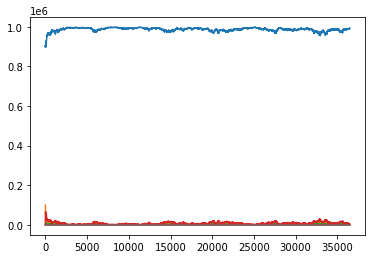

In [20]:
#rescale to be a proportion of the population
#solution=solution/N
plt.plot(solution[0:])

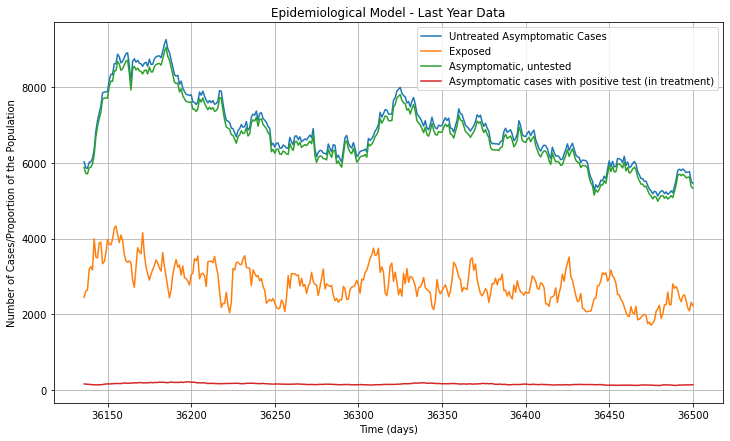

In [21]:


import matplotlib.pyplot as plt

# Extract the last year's data
last_year_data = solution[-365:]
last_year_params=params[-365:]

# Separate data for different cases
symptomatic_cases = last_year_data[:, 2]
exposed_cases = last_year_data[:,1]
susceptible_cases = last_year_data[:,0]
asymptomatic_untested=last_year_data[:,3]
asymptomatic_cases_awaiting_pos=last_year_data[:,4]
asymptomatic_cases_in_treatment = last_year_data[:, 5]

untreated_asymptomatic_cases = asymptomatic_untested + asymptomatic_cases_awaiting_pos

# Time points for the last year
time_last_year = t_points[-365:]

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(time_last_year, untreated_asymptomatic_cases, label='Untreated Asymptomatic Cases')
plt.plot(time_last_year, exposed_cases, label='Exposed')
plt.plot(time_last_year, asymptomatic_untested, label='Asymptomatic, untested')
plt.plot(time_last_year, asymptomatic_cases_in_treatment, label='Asymptomatic cases with positive test (in treatment)')
plt.xlabel('Time (days)')
plt.ylabel('Number of Cases/Proportion of the Population')
plt.title('Epidemiological Model - Last Year Data')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Some Statistics

print("Compartment Means:", np.mean(last_year_data,axis=0))
print("Compartment Variances:", np.var(last_year_data,axis=0))

Compartment Means: [9.89404118e+05 2.81778769e+03 7.51094893e+02 6.70506692e+03
 1.60805166e+02 1.61126979e+02]
Compartment Variances: [1.83495243e+06 2.42067446e+05 3.50945505e+04 8.30571604e+05
 4.36959123e+02 4.87271978e+02]


In [23]:
# Extract the last year's parameters and solutions
last_year_params = params[-365:]
last_year_data = solution[-365:]

# Initialize variables to store the sum of daily inflows
sum_daily_inflow_E = 0
sum_daily_inflow_S = 0
sum_daily_inflow_A_u = 0
sum_daily_inflow_A_t = 0
sum_daily_inflow_A_pos = 0

# Calculate daily inflow rates for the last year
for i in range(365):
    X, E, S, A_u, A_t, A_pos = last_year_data[i]
    beta, epsilon, gamma_t, theta, gamma_u, lambda_, omega_r, eta = last_year_params[i]

    # Compute daily inflow rates
    daily_inflow_E = beta * X * (A_u + A_t) / N
    daily_inflow_S = (1 - lambda_) * epsilon * E + theta * gamma_u * A_u
    daily_inflow_A_u = lambda_ * epsilon * E
    daily_inflow_A_t = average_daily_testing_proportion * A_u
    daily_inflow_A_pos = omega_r * A_t

    # Sum the inflows
    sum_daily_inflow_E += daily_inflow_E
    sum_daily_inflow_S += daily_inflow_S
    sum_daily_inflow_A_u += daily_inflow_A_u
    sum_daily_inflow_A_t += daily_inflow_A_t
    sum_daily_inflow_A_pos += daily_inflow_A_pos

# Calculate average daily inflow rates
avg_daily_inflow_E = sum_daily_inflow_E / 365
avg_daily_inflow_S = sum_daily_inflow_S / 365
avg_daily_inflow_A_u = sum_daily_inflow_A_u / 365
avg_daily_inflow_A_t = sum_daily_inflow_A_t / 365
avg_daily_inflow_A_pos = sum_daily_inflow_A_pos / 365

# Estimate total yearly inflow for each compartment
total_yearly_inflow_E = avg_daily_inflow_E * 365
total_yearly_inflow_S = avg_daily_inflow_S * 365
total_yearly_inflow_A_u = avg_daily_inflow_A_u * 365
total_yearly_inflow_A_t = avg_daily_inflow_A_t * 365
total_yearly_inflow_A_pos = avg_daily_inflow_A_pos * 365

# Total infections for the last year
total_infections_last_year = total_yearly_inflow_E 

# Total Detected Cases 
total_detected_cases = total_yearly_inflow_S + total_yearly_inflow_A_pos

# Percentage of Cases Detected: 
percent_detected_cases=total_detected_cases/total_infections_last_year

# Print the total entries for each compartment
print("Total entries into Symptomatic compartment:", total_yearly_inflow_S)
print("Total entries into Exposed compartment:", total_yearly_inflow_E)
print("Total entries into Asymptomatic, untested compartment:", total_yearly_inflow_A_u)
print("Total entries into Asymptomatic, awaiting positive test compartment:", total_yearly_inflow_A_pos)
print("Total entries into Asymptomatic, in treatment compartment:", total_yearly_inflow_A_t)
print("Total infections:", total_infections_last_year)
print("Total Detected Cases:", total_detected_cases)
print("Percent Detected Cases:", percent_detected_cases )
print("Tau:", tau)

Total entries into Symptomatic compartment: 39549.322100912264
Total entries into Exposed compartment: 210964.95627159462
Total entries into Asymptomatic, untested compartment: 188229.8035162581
Total entries into Asymptomatic, awaiting positive test compartment: 8540.37514831733
Total entries into Asymptomatic, in treatment compartment: 12761.731758539525
Total infections: 210964.95627159462
Total Detected Cases: 48089.69724922959
Percent Detected Cases: 0.22795111614328634
Tau: 7


In [24]:
250000*(total_detected_cases/N)

12022.424312307397

In [25]:
total_detected_cases/total_infections_last_year

0.22795111614328634

In [28]:
# Let's find the average behaviour by simulating many trials and averaging.
# initialize the trials
t_points = np.linspace(0, 50 * 365, 50 * 365)


# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6

num_trials=200

solutions=np.zeros((num_trials,len(t_points), 6))
sim_params=np.zeros((num_trials, len(t_points),8))
for i in range(num_trials):
    solutions[i][0]= [X0, E0, S0, A_u0, A_t0, A_pos0]

In [139]:
# Run Simulations

for i in range(num_trials):
    for j in range(1, len(t_points)):
        
        
    
        #Stochastic params
        beta = np.random.beta(estBetaParams(0.85,0.1)[0],estBetaParams(0.85,0.1)[1])*np.random.gamma(estGammaParams(3.05,3)[0],estGammaParams(3.05,3)[1])/30  
        epsilon = 1/(np.random.gamma(estGammaParams(5,1)[0],estGammaParams(5,1)[1])+0.000000000000001)  
        gamma_t = 1/(np.random.gamma(estGammaParams(7,1)[0],estGammaParams(7,1)[1])+0.00000000000001)
        theta=np.random.beta(estBetaParams(0.1,0.01)[0],estBetaParams(0.1,0.01)[1])
        gamma_u = 1/(np.random.gamma(estGammaParams(14,3)[0],estGammaParams(14,3)[1])+0.00000000000001) 
        lambda_ = np.random.beta(estBetaParams(0.9,0.01)[0],estBetaParams(0.9,0.01)[1]) 
        omega_r = 1/(np.random.gamma(estGammaParams(tau,1)[0], estGammaParams(tau,1)[1])+0.00000000000001)
        eta = np.random.beta(estBetaParams(0.0225,0.0075**2)[0],estBetaParams(0.0225,0.0075**2)[1])

        #record these for average yearly rates later.
        sim_params[i][j]=[beta,epsilon,gamma_t,theta,gamma_u,lambda_,omega_r,eta]


        tspan = [t_points[j-1], t_points[j]]

        ys = odeint(model, solutions[i][j-1], tspan, args=(beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion, tau, N), atol=abserr, rtol=relerr)

         # Update the solution
        solutions[i][j] = ys[-1]
        #print(i,j, solutions[i][j], sum(solutions[i][j]))


In [140]:
# Debug check 
for i in range(num_trials):
    print(solutions[i][0])

[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]
[900000. 100000.      0.      0.      0.      0.]


In [141]:
# Initialize lists to store totals for each simulation
total_infections_per_simulation = []
total_detected_cases_per_simulation = []

for i in range(num_trials):
    # Extract the last year's data for this simulation
    last_year_data = solutions[i][-365:]
    last_year_params = sim_params[i][-365:]

    # Initialize variables to store the sum of daily inflows
    sum_daily_inflow_E = 0
    sum_daily_inflow_S = 0
    sum_daily_inflow_A_pos = 0

    # Calculate daily inflow rates for the last year of this simulation
    for day_data, day_params in zip(last_year_data, last_year_params):
        X, E, S, A_u, A_t, A_pos = day_data
        beta, epsilon, gamma_t, theta, gamma_u, lambda_, omega_r, eta = day_params

        # Compute daily inflow rates
        daily_inflow_E = beta * X * (A_u + A_t) / N
        daily_inflow_S = (1 - lambda_) * epsilon * E + theta * gamma_u * A_u
        daily_inflow_A_pos = omega_r * A_t

        # Sum the inflows
        sum_daily_inflow_E += daily_inflow_E
        sum_daily_inflow_S += daily_inflow_S
        sum_daily_inflow_A_pos += daily_inflow_A_pos

    # Calculate total yearly inflow for each compartment
    total_yearly_inflow_E = sum_daily_inflow_E
    total_yearly_inflow_S = sum_daily_inflow_S
    total_yearly_inflow_A_pos = sum_daily_inflow_A_pos

    # Total infections for the last year
    total_infections_last_year = total_yearly_inflow_E

    # Total Detected Cases 
    total_detected_cases = total_yearly_inflow_S + total_yearly_inflow_A_pos

    # Store the totals for each simulation
    total_infections_per_simulation.append(total_infections_last_year)
    total_detected_cases_per_simulation.append(total_detected_cases)

# Calculate the average across all simulations
average_total_infections = np.mean(total_infections_per_simulation)
average_total_detected_cases = np.mean(total_detected_cases_per_simulation)

# Print the averages
print("Average Total Infections:", average_total_infections)
print("Average Total Detected Cases:", average_total_detected_cases)

Average Total Infections: 193730.6475781563
Average Total Detected Cases: 43112.587355806325


In [142]:
# Print the averages Scaled
print("Average Total Infections:", 250000*average_total_infections/N)
print("Average Total Detected Cases:", 250000*average_total_detected_cases/N)

Average Total Infections: 48432.66189453907
Average Total Detected Cases: 10778.146838951581


In [143]:
# Average Solution

average_solution=np.mean(solutions, axis=0)

# Rescale by population size to obtain proportion 

average_solution=average_solution/N

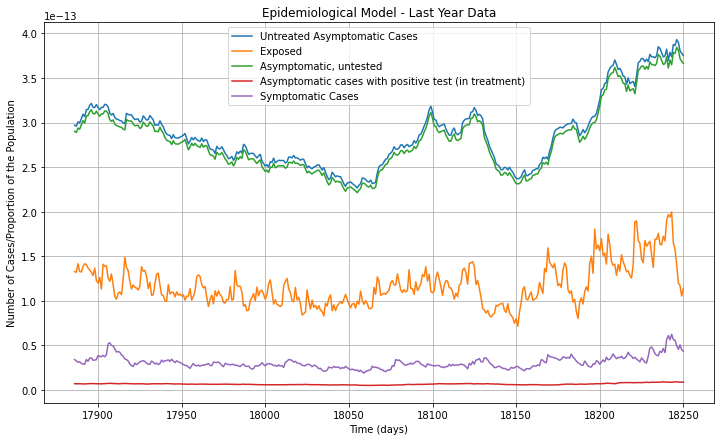

In [130]:
# Plot average behaviour

# Extract the last year's data
last_year_data = average_solution[-365:]


# Separate data for different cases
symptomatic_cases = last_year_data[:, 2]
exposed_cases = last_year_data[:,1]
susceptible_cases = last_year_data[:,0]
asymptomatic_untested=last_year_data[:,3]
asymptomatic_cases_awaiting_pos=last_year_data[:,4]
asymptomatic_cases_in_treatment = last_year_data[:, 5]

untreated_asymptomatic_cases = asymptomatic_untested + asymptomatic_cases_awaiting_pos

# Time points for the last year
time_last_year = t_points[-365:]

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(time_last_year, untreated_asymptomatic_cases, label='Untreated Asymptomatic Cases')
plt.plot(time_last_year, exposed_cases, label='Exposed')
plt.plot(time_last_year, asymptomatic_untested, label='Asymptomatic, untested')
plt.plot(time_last_year, asymptomatic_cases_in_treatment, label='Asymptomatic cases with positive test (in treatment)')
plt.plot(time_last_year, symptomatic_cases, label='Symptomatic Cases')
plt.xlabel('Time (days)')
plt.ylabel('Number of Cases/Proportion of the Population')
plt.title('Epidemiological Model - Last Year Data')
plt.legend()
plt.grid(True)
plt.show()

In [124]:
# Some Statistics

print("Compartment Means:",np.mean(last_year_data,axis=0))
print("Compartment Variances:", np.var(last_year_data,axis=0))

Compartment Means: [9.75375065e-01 6.52025077e-03 1.70970423e-03 1.56465114e-02
 3.73962829e-04 3.74505316e-04]
Compartment Variances: [2.02800281e-07 2.74789012e-08 1.53011411e-09 8.01954101e-08
 4.61785003e-11 3.85316722e-11]


In [ ]:
#Let's wrap this in a function to generate a plot of total detected cases for different tau

def run_simulations(tau, num_trials):
    
    
    def estBetaParams(mu, var):
        alpha=((1 - mu) / var - 1 / mu) * mu**2
        beta=alpha * (1 / mu - 1)
        return alpha,beta

    def estGammaParams(mu,var):
        shape=(mu**2)/var
        scale=var/mu
        return shape, scale
    
        #Non-Stochastic Parameters Parameters

    N = 10**6           #250000               # Total population
    p_3months = 0.3          # Proportion tested every 3 months
    p_12months = 1-p_3months         # Proportion tested every 12 months
    tau = 7                # This is our key parameter; the average return time for tests.

    # The (weighted) average testing proportion for our population (proportion per day)
    average_daily_testing_proportion = (p_3months/91 + p_12months/365)
    tests_per_day=N*average_daily_testing_proportion
    # I think that the generic person will get tested with this probability each day, and so the waiting
    # time for a test from any given instant is 1/average_testing_proportion (exponential waiting time)
    # No.... maybe it should be with rate tests_per_day??

    # Initial conditions
    E0 = 0.2 * N             # Initial exposed individuals.
    X0 = N - E0              # Initial susceptible individuals.
    S0 = 0                   # Initial symptomatic individuals (we assume the symptoms are NOTICEABLE). Symptomatic Individuals are assumed to isolate.
    A_u0 = 0               # Initial asymptomatic individuals who are untested.
    A_t0 = 0                 # Initial asympt. who are tested and awating a positive. These individuals will NOT isolate. 
    A_pos0 = 0                 # Initial asympt. positive test. These people are isolating. 
                       # Initial people with complications 
        
        
    #Define the Model 

    def model(Y, t, beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion , tau, N):


        X, E, S, A_u, A_t, A_pos= Y


        # Here, we assume that the only groups driving the spread of infection are the asymptomatic who have not received a positive test
        dXdt = -beta*X*(A_u+A_t)/N + gamma_t*S  + gamma_t*A_pos + gamma_u*A_t + (1-theta)*gamma_u*A_u


        dEdt = beta*X*(A_u+A_t)/N - epsilon*E


        dSdt = (1-lambda_)*epsilon*E + theta*gamma_u*A_u - gamma_t*S 


        dA_udt = lambda_*epsilon*E - average_daily_testing_proportion*A_u - gamma_u*A_u #I want some proportion to clear, and some proportion to become infectious

        dA_tdt = average_daily_testing_proportion*A_u - omega_r*A_t - gamma_u*A_t


        dA_posdt = omega_r*A_t - gamma_t*A_pos




        return [dXdt, dEdt, dSdt, dA_udt, dA_tdt, dA_posdt]

    t_points = np.linspace(0, 25 * 365, 25 * 365) #5 years


    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6


    solutions=np.zeros((num_trials,len(t_points), 6))
    sim_params=np.zeros((num_trials, len(t_points),8))

    for i in range(num_trials):
        solutions[i][0]= [X0, E0, S0, A_u0, A_t0, A_pos0]
        
    for i in range(num_trials):
        for j in range(1, len(t_points)):

            #Stochastic params
            beta = np.random.beta(estBetaParams(0.9,0.01)[0],estBetaParams(0.9,0.01)[1])*np.random.gamma(estGammaParams(2.85,1)[0],estGammaParams(2.85,1)[1])/30  
            epsilon = 1/(np.random.gamma(estGammaParams(5,1)[0],estGammaParams(5,1)[1])+0.000000000000001) 
            gamma_t = 1/(np.random.gamma(estGammaParams(7,1)[0],estGammaParams(7,1)[1])+0.00000000000001) 
            theta=np.random.beta(estBetaParams(0.1,0.01)[0],estBetaParams(0.1,0.01)[1])
            gamma_u = 1/(np.random.gamma(estGammaParams(14,3)[0],estGammaParams(14,3)[1])+0.00000000000001) 
            lambda_ = np.random.beta(estBetaParams(0.9,0.01)[0],estBetaParams(0.9,0.01)[1]) 
            omega_r = 1/(np.random.gamma(estGammaParams(tau,1)[0], estGammaParams(tau,1)[1])+0.00000000000001)
            eta = np.random.beta(estBetaParams(0.0225,0.0075**2)[0],estBetaParams(0.0225,0.0075**2)[1])

            #record these for average yearly rates later.
            sim_params[i][j]=[beta,epsilon,gamma_t,theta,gamma_u,lambda_,omega_r,eta]


            tspan = [t_points[j-1], t_points[j]]

            ys = odeint(model, solutions[i][j-1], tspan, args=(beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion, tau, N), atol=abserr, rtol=relerr)

             # Update the solution
            solutions[i][j] = ys[-1]
            #print(i,j, solutions[i][j], sum(solutions[i][j]))
            
        #Extract_Last_year_data

        last_year_data=[solution[-365:] for solution in solutions]
        last_year_params=[params[-365:] for params in sim_params]
        
        #rescale by the population size to get a relativized version:
        
        last_year_data = [[value / N for value in day] for day in last_year_data]

        # Average Solution: we shoudld compute the totals for each year before averaging in order to get better stats

        E_totals=[]
        S_totals=[]
        A_u_totals=[]
        A_t_totals=[]
        A_pos_totals=[]
        Infection_totals=[]
        Detection_totals=[]
        Percent_detection_totals=[]

        for i in range(num_trials): 

                # Initialize variables to store the sum of daily inflows
            total_yearly_inflow_E = 0
            total_yearly_inflow_S = 0
            total_yearly_inflow_A_u = 0
            total_yearly_inflow_A_t = 0
            total_yearly_inflow_A_pos = 0

            # Calculate daily inflow rates for the last year
            for j in range(365):
                X, E, S, A_u, A_t, A_pos = last_year_data[i][j]
                beta, epsilon, gamma_t, theta, gamma_u, lambda_, omega_r, eta = last_year_params[i][j]

                # Compute daily inflow rates
                daily_inflow_E = beta * X * (A_u + A_t) / N
                daily_inflow_S = (1 - lambda_) * epsilon * E + theta * gamma_u * A_u
                daily_inflow_A_u = lambda_ * epsilon * E
                daily_inflow_A_t = average_daily_testing_proportion * A_u
                daily_inflow_A_pos = omega_r * A_t

                # Sum the inflows
                total_yearly_inflow_E += daily_inflow_E
                total_yearly_inflow_S += daily_inflow_S
                total_yearly_inflow_A_u += daily_inflow_A_u
                total_yearly_inflow_A_t += daily_inflow_A_t
                total_yearly_inflow_A_pos += daily_inflow_A_pos

            

            # Total infections for the last year
            total_infections_last_year = total_yearly_inflow_E 

            # Total Detected Cases 
            total_detected_cases = total_yearly_inflow_S + total_yearly_inflow_A_pos

            # Percentage of Cases Detected: 
            percent_detected_cases=total_detected_cases/total_infections_last_year

            E_totals.append(total_yearly_inflow_E)
            S_totals.append(total_yearly_inflow_S)
            A_u_totals.append(total_yearly_inflow_A_u)
            A_t_totals.append(total_yearly_inflow_A_t)
            A_pos_totals.append(total_yearly_inflow_A_pos)
            Infection_totals.append(total_infections_last_year)
            Detection_totals.append(total_detected_cases)
            Percent_detection_totals.append(percent_detected_cases)


    
    #now compute averages accross all simulations:
    from scipy import stats

    
    mean_E_total=np.mean(E_totals)
    stDev_E_total= np.std(E_totals)
    conf_E_total = stats.norm.interval(0.95, loc=mean_E_total, scale=stDev_E_total)
    E_total_stats=[mean_E_total, stDev_E_total,conf_E_total]
    
    mean_S_total=np.mean(S_totals)
    stDev_S_total= np.std(S_totals)
    conf_S_total = stats.norm.interval(0.95, loc=mean_S_total, scale=stDev_S_total)
    S_total_stats=[mean_S_total, stDev_S_total,conf_S_total]
    
    mean_A_u_total=np.mean(A_u_totals)
    stDev_A_u_total= np.std(A_u_totals)
    conf_A_u_total = stats.norm.interval(0.95, loc=mean_A_u_total, scale=stDev_A_u_total)
    A_u_total_stats=[mean_A_u_total, stDev_A_u_total,conf_A_u_total]
  
    mean_A_t_total=np.mean(A_t_totals)
    stDev_A_t_total= np.std(A_t_totals)
    conf_A_t_total = stats.norm.interval(0.95, loc=mean_A_t_total, scale=stDev_A_t_total)
    A_t_total_stats=[mean_A_t_total, stDev_A_t_total,conf_A_t_total]
    
    mean_A_pos_total=np.mean(A_pos_totals)
    stDev_A_pos_total= np.std(A_pos_totals)
    conf_A_pos_total = stats.norm.interval(0.95, loc=mean_A_pos_total, scale=stDev_A_pos_total)
    A_pos_total_stats=[mean_A_pos_total, stDev_A_pos_total,conf_A_pos_total]
    
    mean_Infection_total=np.mean(Infection_totals)
    stDev_Infection_total= np.std(Infection_totals)
    conf_Infection_total = stats.norm.interval(0.95, loc=mean_Infection_total, scale=stDev_Infection_total)
    Infection_total_stats=[mean_Infection_total, stDev_Infection_total,conf_Infection_total]
    
    mean_Detection_total=np.mean(Detection_totals)
    stDev_Detection_total= np.std(Detection_totals)
    conf_Detection_total = stats.norm.interval(0.95, loc=mean_Detection_total, scale=stDev_Detection_total)
    Detection_total_stats=[mean_Detection_total, stDev_Detection_total,conf_Detection_total]
    
    
    mean_Percent_detection_total=np.mean(Percent_detection_totals)
    stDev_Percent_detection_total= np.std(Percent_detection_totals)
    conf_Percent_detection_total = stats.norm.interval(0.95, loc=mean_Percent_detection_total, scale=stDev_Percent_detection_total)
    Percent_detection_total_stats=[mean_Percent_detection_total, stDev_Percent_detection_total,conf_Percent_detection_total]


    return E_total_stats,S_total_stats,A_u_total_stats,A_t_total_stats,A_pos_total_stats,Infection_total_stats,Detection_total_stats,Percent_detection_total_stats


In [ ]:
#Let's wrap this in a function to generate a plot of total detected cases for different tau

def run_simulations(tau, num_trials):
    
    
    def estBetaParams(mu, var):
        alpha=((1 - mu) / var - 1 / mu) * mu**2
        beta=alpha * (1 / mu - 1)
        return alpha,beta

    def estGammaParams(mu,var):
        shape=(mu**2)/var
        scale=var/mu
        return shape, scale
    
        #Non-Stochastic Parameters Parameters

    N = 10**6           #250000               # Total population
    p_3months = 0.3          # Proportion tested every 3 months
    p_12months = 1-p_3months         # Proportion tested every 12 months
    tau = 7                # This is our key parameter; the average return time for tests.

    # The (weighted) average testing proportion for our population (proportion per day)
    average_daily_testing_proportion = (p_3months/91 + p_12months/365)
    tests_per_day=N*average_daily_testing_proportion
    # I think that the generic person will get tested with this probability each day, and so the waiting
    # time for a test from any given instant is 1/average_testing_proportion (exponential waiting time)
    # No.... maybe it should be with rate tests_per_day??

    # Initial conditions
    E0 = 0.2 * N             # Initial exposed individuals.
    X0 = N - E0              # Initial susceptible individuals.
    S0 = 0                   # Initial symptomatic individuals (we assume the symptoms are NOTICEABLE). Symptomatic Individuals are assumed to isolate.
    A_u0 = 0               # Initial asymptomatic individuals who are untested.
    A_t0 = 0                 # Initial asympt. who are tested and awating a positive. These individuals will NOT isolate. 
    A_pos0 = 0                 # Initial asympt. positive test. These people are isolating. 
                       # Initial people with complications 
        
        
    #Define the Model 

    def model(Y, t, beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion , tau, N):


        X, E, S, A_u, A_t, A_pos= Y


        # Here, we assume that the only groups driving the spread of infection are the asymptomatic who have not received a positive test
        dXdt = -beta*X*(A_u+A_t)/N + gamma_t*S  + gamma_t*A_pos + gamma_u*A_t + (1-theta)*gamma_u*A_u


        dEdt = beta*X*(A_u+A_t)/N - epsilon*E


        dSdt = (1-lambda_)*epsilon*E + theta*gamma_u*A_u - gamma_t*S 


        dA_udt = lambda_*epsilon*E - average_daily_testing_proportion*A_u - gamma_u*A_u #I want some proportion to clear, and some proportion to become infectious

        dA_tdt = average_daily_testing_proportion*A_u - omega_r*A_t - gamma_u*A_t


        dA_posdt = omega_r*A_t - gamma_t*A_pos




        return [dXdt, dEdt, dSdt, dA_udt, dA_tdt, dA_posdt]

    t_points = np.linspace(0, 25 * 365, 25 * 365) #5 years


    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6


    solutions=np.zeros((num_trials,len(t_points), 6))
    sim_params=np.zeros((num_trials, len(t_points),8))

    for i in range(num_trials):
        solutions[i][0]= [X0, E0, S0, A_u0, A_t0, A_pos0]
        
    for i in range(num_trials):
        for j in range(1, len(t_points)):

            #Stochastic params
            beta = np.random.beta(estBetaParams(0.9,0.01)[0],estBetaParams(0.9,0.01)[1])*np.random.gamma(estGammaParams(2.85,1)[0],estGammaParams(2.85,1)[1])/30  
            epsilon = 1/(np.random.gamma(estGammaParams(5,1)[0],estGammaParams(5,1)[1])+0.000000000000001) 
            gamma_t = 1/(np.random.gamma(estGammaParams(7,1)[0],estGammaParams(7,1)[1])+0.00000000000001) 
            theta=np.random.beta(estBetaParams(0.1,0.01)[0],estBetaParams(0.1,0.01)[1])
            gamma_u = 1/(np.random.gamma(estGammaParams(14,3)[0],estGammaParams(14,3)[1])+0.00000000000001) 
            lambda_ = np.random.beta(estBetaParams(0.9,0.01)[0],estBetaParams(0.9,0.01)[1]) 
            omega_r = 1/(np.random.gamma(estGammaParams(tau,1)[0], estGammaParams(tau,1)[1])+0.00000000000001)
            eta = np.random.beta(estBetaParams(0.0225,0.0075**2)[0],estBetaParams(0.0225,0.0075**2)[1])

            #record these for average yearly rates later.
            sim_params[i][j]=[beta,epsilon,gamma_t,theta,gamma_u,lambda_,omega_r,eta]


            tspan = [t_points[j-1], t_points[j]]

            ys = odeint(model, solutions[i][j-1], tspan, args=(beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion, tau, N), atol=abserr, rtol=relerr)

             # Update the solution
            solutions[i][j] = ys[-1]
            #print(i,j, solutions[i][j], sum(solutions[i][j]))
            
        #Extract_Last_year_data

        last_year_data=[solution[-365:] for solution in solutions]
        last_year_params=[params[-365:] for params in sim_params]
        
        #rescale by the population size to get a relativized version:
        
        last_year_data = [[value / N for value in day] for day in last_year_data]

        # Average Solution: we shoudld compute the totals for each year before averaging in order to get better stats

        E_totals=[]
        S_totals=[]
        A_u_totals=[]
        A_t_totals=[]
        A_pos_totals=[]
        Infection_totals=[]
        Detection_totals=[]
        Percent_detection_totals=[]

        for i in range(num_trials): 

                # Initialize variables to store the sum of daily inflows
            total_yearly_inflow_E = 0
            total_yearly_inflow_S = 0
            total_yearly_inflow_A_u = 0
            total_yearly_inflow_A_t = 0
            total_yearly_inflow_A_pos = 0

            # Calculate daily inflow rates for the last year
            for j in range(365):
                X, E, S, A_u, A_t, A_pos = last_year_data[i][j]
                beta, epsilon, gamma_t, theta, gamma_u, lambda_, omega_r, eta = last_year_params[i][j]

                # Compute daily inflow rates
                daily_inflow_E = beta * X * (A_u + A_t) / N
                daily_inflow_S = (1 - lambda_) * epsilon * E + theta * gamma_u * A_u
                daily_inflow_A_u = lambda_ * epsilon * E
                daily_inflow_A_t = average_daily_testing_proportion * A_u
                daily_inflow_A_pos = omega_r * A_t

                # Sum the inflows
                total_yearly_inflow_E += daily_inflow_E
                total_yearly_inflow_S += daily_inflow_S
                total_yearly_inflow_A_u += daily_inflow_A_u
                total_yearly_inflow_A_t += daily_inflow_A_t
                total_yearly_inflow_A_pos += daily_inflow_A_pos

            

            # Total infections for the last year
            total_infections_last_year = total_yearly_inflow_E 

            # Total Detected Cases 
            total_detected_cases = total_yearly_inflow_S + total_yearly_inflow_A_pos

            # Percentage of Cases Detected: 
            percent_detected_cases=total_detected_cases/total_infections_last_year

            E_totals.append(total_yearly_inflow_E)
            S_totals.append(total_yearly_inflow_S)
            A_u_totals.append(total_yearly_inflow_A_u)
            A_t_totals.append(total_yearly_inflow_A_t)
            A_pos_totals.append(total_yearly_inflow_A_pos)
            Infection_totals.append(total_infections_last_year)
            Detection_totals.append(total_detected_cases)
            Percent_detection_totals.append(percent_detected_cases)


    
    #now compute averages accross all simulations:
    from scipy import stats

    
    mean_E_total=np.mean(E_totals)
    stDev_E_total= np.std(E_totals)
    conf_E_total = stats.norm.interval(0.95, loc=mean_E_total, scale=stDev_E_total)
    E_total_stats=[mean_E_total, stDev_E_total,conf_E_total]
    
    mean_S_total=np.mean(S_totals)
    stDev_S_total= np.std(S_totals)
    conf_S_total = stats.norm.interval(0.95, loc=mean_S_total, scale=stDev_S_total)
    S_total_stats=[mean_S_total, stDev_S_total,conf_S_total]
    
    mean_A_u_total=np.mean(A_u_totals)
    stDev_A_u_total= np.std(A_u_totals)
    conf_A_u_total = stats.norm.interval(0.95, loc=mean_A_u_total, scale=stDev_A_u_total)
    A_u_total_stats=[mean_A_u_total, stDev_A_u_total,conf_A_u_total]
  
    mean_A_t_total=np.mean(A_t_totals)
    stDev_A_t_total= np.std(A_t_totals)
    conf_A_t_total = stats.norm.interval(0.95, loc=mean_A_t_total, scale=stDev_A_t_total)
    A_t_total_stats=[mean_A_t_total, stDev_A_t_total,conf_A_t_total]
    
    mean_A_pos_total=np.mean(A_pos_totals)
    stDev_A_pos_total= np.std(A_pos_totals)
    conf_A_pos_total = stats.norm.interval(0.95, loc=mean_A_pos_total, scale=stDev_A_pos_total)
    A_pos_total_stats=[mean_A_pos_total, stDev_A_pos_total,conf_A_pos_total]
    
    mean_Infection_total=np.mean(Infection_totals)
    stDev_Infection_total= np.std(Infection_totals)
    conf_Infection_total = stats.norm.interval(0.95, loc=mean_Infection_total, scale=stDev_Infection_total)
    Infection_total_stats=[mean_Infection_total, stDev_Infection_total,conf_Infection_total]
    
    mean_Detection_total=np.mean(Detection_totals)
    stDev_Detection_total= np.std(Detection_totals)
    conf_Detection_total = stats.norm.interval(0.95, loc=mean_Detection_total, scale=stDev_Detection_total)
    Detection_total_stats=[mean_Detection_total, stDev_Detection_total,conf_Detection_total]
    
    
    mean_Percent_detection_total=np.mean(Percent_detection_totals)
    stDev_Percent_detection_total= np.std(Percent_detection_totals)
    conf_Percent_detection_total = stats.norm.interval(0.95, loc=mean_Percent_detection_total, scale=stDev_Percent_detection_total)
    Percent_detection_total_stats=[mean_Percent_detection_total, stDev_Percent_detection_total,conf_Percent_detection_total]


    return E_total_stats,S_total_stats,A_u_total_stats,A_t_total_stats,A_pos_total_stats,Infection_total_stats,Detection_total_stats,Percent_detection_total_stats


In [ ]:
#Let's wrap this in a function to generate a plot of total detected cases for different tau

def run_simulations(tau, num_trials):
    
    
    def estBetaParams(mu, var):
        alpha=((1 - mu) / var - 1 / mu) * mu**2
        beta=alpha * (1 / mu - 1)
        return alpha,beta

    def estGammaParams(mu,var):
        shape=(mu**2)/var
        scale=var/mu
        return shape, scale
    
        #Non-Stochastic Parameters Parameters

    N = 10**6           #250000               # Total population
    p_3months = 0.3          # Proportion tested every 3 months
    p_12months = 1-p_3months         # Proportion tested every 12 months
    tau = 7                # This is our key parameter; the average return time for tests.

    # The (weighted) average testing proportion for our population (proportion per day)
    average_daily_testing_proportion = (p_3months/91 + p_12months/365)
    tests_per_day=N*average_daily_testing_proportion
    # I think that the generic person will get tested with this probability each day, and so the waiting
    # time for a test from any given instant is 1/average_testing_proportion (exponential waiting time)
    # No.... maybe it should be with rate tests_per_day??

    # Initial conditions
    E0 = 0.2 * N             # Initial exposed individuals.
    X0 = N - E0              # Initial susceptible individuals.
    S0 = 0                   # Initial symptomatic individuals (we assume the symptoms are NOTICEABLE). Symptomatic Individuals are assumed to isolate.
    A_u0 = 0               # Initial asymptomatic individuals who are untested.
    A_t0 = 0                 # Initial asympt. who are tested and awating a positive. These individuals will NOT isolate. 
    A_pos0 = 0                 # Initial asympt. positive test. These people are isolating. 
                       # Initial people with complications 
        
        
    #Define the Model 

    def model(Y, t, beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion , tau, N):


        X, E, S, A_u, A_t, A_pos= Y


        # Here, we assume that the only groups driving the spread of infection are the asymptomatic who have not received a positive test
        dXdt = -beta*X*(A_u+A_t)/N + gamma_t*S  + gamma_t*A_pos + gamma_u*A_t + (1-theta)*gamma_u*A_u


        dEdt = beta*X*(A_u+A_t)/N - epsilon*E


        dSdt = (1-lambda_)*epsilon*E + theta*gamma_u*A_u - gamma_t*S 


        dA_udt = lambda_*epsilon*E - average_daily_testing_proportion*A_u - gamma_u*A_u #I want some proportion to clear, and some proportion to become infectious

        dA_tdt = average_daily_testing_proportion*A_u - omega_r*A_t - gamma_u*A_t


        dA_posdt = omega_r*A_t - gamma_t*A_pos




        return [dXdt, dEdt, dSdt, dA_udt, dA_tdt, dA_posdt]

    t_points = np.linspace(0, 25 * 365, 25 * 365) #5 years


    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6


    solutions=np.zeros((num_trials,len(t_points), 6))
    sim_params=np.zeros((num_trials, len(t_points),8))

    for i in range(num_trials):
        solutions[i][0]= [X0, E0, S0, A_u0, A_t0, A_pos0]
        
    for i in range(num_trials):
        for j in range(1, len(t_points)):

            #Stochastic params
            beta = np.random.beta(estBetaParams(0.9,0.01)[0],estBetaParams(0.9,0.01)[1])*np.random.gamma(estGammaParams(2.85,1)[0],estGammaParams(2.85,1)[1])/30  
            epsilon = 1/(np.random.gamma(estGammaParams(5,1)[0],estGammaParams(5,1)[1])+0.000000000000001) 
            gamma_t = 1/(np.random.gamma(estGammaParams(7,1)[0],estGammaParams(7,1)[1])+0.00000000000001) 
            theta=np.random.beta(estBetaParams(0.1,0.01)[0],estBetaParams(0.1,0.01)[1])
            gamma_u = 1/(np.random.gamma(estGammaParams(14,3)[0],estGammaParams(14,3)[1])+0.00000000000001) 
            lambda_ = np.random.beta(estBetaParams(0.9,0.01)[0],estBetaParams(0.9,0.01)[1]) 
            omega_r = 1/(np.random.gamma(estGammaParams(tau,1)[0], estGammaParams(tau,1)[1])+0.00000000000001)
            eta = np.random.beta(estBetaParams(0.0225,0.0075**2)[0],estBetaParams(0.0225,0.0075**2)[1])

            #record these for average yearly rates later.
            sim_params[i][j]=[beta,epsilon,gamma_t,theta,gamma_u,lambda_,omega_r,eta]


            tspan = [t_points[j-1], t_points[j]]

            ys = odeint(model, solutions[i][j-1], tspan, args=(beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion, tau, N), atol=abserr, rtol=relerr)

             # Update the solution
            solutions[i][j] = ys[-1]
            #print(i,j, solutions[i][j], sum(solutions[i][j]))
            
        #Extract_Last_year_data

        last_year_data=[solution[-365:] for solution in solutions]
        last_year_params=[params[-365:] for params in sim_params]
        
        #rescale by the population size to get a relativized version:
        
        last_year_data = [[value / N for value in day] for day in last_year_data]

        # Average Solution: we shoudld compute the totals for each year before averaging in order to get better stats

        E_totals=[]
        S_totals=[]
        A_u_totals=[]
        A_t_totals=[]
        A_pos_totals=[]
        Infection_totals=[]
        Detection_totals=[]
        Percent_detection_totals=[]

        for i in range(num_trials): 

                # Initialize variables to store the sum of daily inflows
            total_yearly_inflow_E = 0
            total_yearly_inflow_S = 0
            total_yearly_inflow_A_u = 0
            total_yearly_inflow_A_t = 0
            total_yearly_inflow_A_pos = 0

            # Calculate daily inflow rates for the last year
            for j in range(365):
                X, E, S, A_u, A_t, A_pos = last_year_data[i][j]
                beta, epsilon, gamma_t, theta, gamma_u, lambda_, omega_r, eta = last_year_params[i][j]

                # Compute daily inflow rates
                daily_inflow_E = beta * X * (A_u + A_t) / N
                daily_inflow_S = (1 - lambda_) * epsilon * E + theta * gamma_u * A_u
                daily_inflow_A_u = lambda_ * epsilon * E
                daily_inflow_A_t = average_daily_testing_proportion * A_u
                daily_inflow_A_pos = omega_r * A_t

                # Sum the inflows
                total_yearly_inflow_E += daily_inflow_E
                total_yearly_inflow_S += daily_inflow_S
                total_yearly_inflow_A_u += daily_inflow_A_u
                total_yearly_inflow_A_t += daily_inflow_A_t
                total_yearly_inflow_A_pos += daily_inflow_A_pos

            

            # Total infections for the last year
            total_infections_last_year = total_yearly_inflow_E 

            # Total Detected Cases 
            total_detected_cases = total_yearly_inflow_S + total_yearly_inflow_A_pos

            # Percentage of Cases Detected: 
            percent_detected_cases=total_detected_cases/total_infections_last_year

            E_totals.append(total_yearly_inflow_E)
            S_totals.append(total_yearly_inflow_S)
            A_u_totals.append(total_yearly_inflow_A_u)
            A_t_totals.append(total_yearly_inflow_A_t)
            A_pos_totals.append(total_yearly_inflow_A_pos)
            Infection_totals.append(total_infections_last_year)
            Detection_totals.append(total_detected_cases)
            Percent_detection_totals.append(percent_detected_cases)


    
    #now compute averages accross all simulations:
    from scipy import stats

    
    mean_E_total=np.mean(E_totals)
    stDev_E_total= np.std(E_totals)
    conf_E_total = stats.norm.interval(0.95, loc=mean_E_total, scale=stDev_E_total)
    E_total_stats=[mean_E_total, stDev_E_total,conf_E_total]
    
    mean_S_total=np.mean(S_totals)
    stDev_S_total= np.std(S_totals)
    conf_S_total = stats.norm.interval(0.95, loc=mean_S_total, scale=stDev_S_total)
    S_total_stats=[mean_S_total, stDev_S_total,conf_S_total]
    
    mean_A_u_total=np.mean(A_u_totals)
    stDev_A_u_total= np.std(A_u_totals)
    conf_A_u_total = stats.norm.interval(0.95, loc=mean_A_u_total, scale=stDev_A_u_total)
    A_u_total_stats=[mean_A_u_total, stDev_A_u_total,conf_A_u_total]
  
    mean_A_t_total=np.mean(A_t_totals)
    stDev_A_t_total= np.std(A_t_totals)
    conf_A_t_total = stats.norm.interval(0.95, loc=mean_A_t_total, scale=stDev_A_t_total)
    A_t_total_stats=[mean_A_t_total, stDev_A_t_total,conf_A_t_total]
    
    mean_A_pos_total=np.mean(A_pos_totals)
    stDev_A_pos_total= np.std(A_pos_totals)
    conf_A_pos_total = stats.norm.interval(0.95, loc=mean_A_pos_total, scale=stDev_A_pos_total)
    A_pos_total_stats=[mean_A_pos_total, stDev_A_pos_total,conf_A_pos_total]
    
    mean_Infection_total=np.mean(Infection_totals)
    stDev_Infection_total= np.std(Infection_totals)
    conf_Infection_total = stats.norm.interval(0.95, loc=mean_Infection_total, scale=stDev_Infection_total)
    Infection_total_stats=[mean_Infection_total, stDev_Infection_total,conf_Infection_total]
    
    mean_Detection_total=np.mean(Detection_totals)
    stDev_Detection_total= np.std(Detection_totals)
    conf_Detection_total = stats.norm.interval(0.95, loc=mean_Detection_total, scale=stDev_Detection_total)
    Detection_total_stats=[mean_Detection_total, stDev_Detection_total,conf_Detection_total]
    
    
    mean_Percent_detection_total=np.mean(Percent_detection_totals)
    stDev_Percent_detection_total= np.std(Percent_detection_totals)
    conf_Percent_detection_total = stats.norm.interval(0.95, loc=mean_Percent_detection_total, scale=stDev_Percent_detection_total)
    Percent_detection_total_stats=[mean_Percent_detection_total, stDev_Percent_detection_total,conf_Percent_detection_total]


    return E_total_stats,S_total_stats,A_u_total_stats,A_t_total_stats,A_pos_total_stats,Infection_total_stats,Detection_total_stats,Percent_detection_total_stats


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of tau values and number of simulations
tau_values = range(1, 16)
num_simulations = 50  # Adjust as needed

# Initialize lists to store results for each compartment and overall statistics
results_mean = [[] for _ in range(8)]  # 8 outputs from the function
results_conf_intervals = [[] for _ in range(8)]

# Run simulations for each tau value
for tau in tau_values:
    outputs = run_simulations(tau, num_simulations)
    
    # Store mean and confidence intervals for each output
    for i in range(8):  # Assuming there are 8 different outputs
        results_mean[i].append(outputs[i][0])
        results_conf_intervals[i].append(outputs[i][2])

# Plotting
plt.figure(figsize=(15, 10))

# Labels for each plot
labels = ['Exposed', 'Symptomatic', 'Asymptomatic Untested', 'Asymptomatic Tested', 
          'Asymptomatic Positive', 'Total Infections', 'Total Detections', 'Percent Detection']

# Plot each set of results
for i in range(8):
    # Convert confidence intervals to error for plotting
    errors = [(mean - conf[0], conf[1] - mean) for mean, conf in zip(results_mean[i], results_conf_intervals[i])]
    lower_error, upper_error = zip(*errors)
    
    # Plotting
    plt.errorbar(tau_values, results_mean[i], yerr=[lower_error, upper_error], fmt='-o', label=labels[i])

plt.xlabel('Tau')
plt.ylabel('Mean Cases')
plt.title('Mean Cases vs Tau with Confidence Intervals for Different Compartments')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import csv
import datetime

# Headers for your CSV file
headers = ['Tau', 
           'Exposed Mean', 'Exposed CI Lower', 'Exposed CI Upper', 
           'Symptomatic Mean', 'Symptomatic CI Lower', 'Symptomatic CI Upper', 
           'Asymptomatic Untested Mean', 'Asymptomatic Untested CI Lower', 'Asymptomatic Untested CI Upper',
           'Asymptomatic Tested Mean', 'Asymptomatic Tested CI Lower', 'Asymptomatic Tested CI Upper',
           'Asymptomatic Positive Mean', 'Asymptomatic Positive CI Lower', 'Asymptomatic Positive CI Upper',
           'Total Infections Mean', 'Total Infections CI Lower', 'Total Infections CI Upper',
           'Total Detections Mean', 'Total Detections CI Lower', 'Total Detections CI Upper',
           'Percent Detection Mean', 'Percent Detection CI Lower', 'Percent Detection CI Upper']

# Prepare data for writing to CSV
data_to_write = []
for index, tau in enumerate(tau_values):
    row = [tau]
    for i in range(8):  # Assuming 8 sets of outputs
        mean_value = results_mean[i][index]
        conf_interval = results_conf_intervals[i][index]
        row.extend([mean_value, conf_interval[0], conf_interval[1]])  # Add mean and CI bounds to row
    data_to_write.append(row)

# Create a unique file name using the current timestamp
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_name = f'output_statistics_num_trials_{num_simulations}_{current_time}.csv'

# Write to CSV file
with open(file_name, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(data_to_write)

print(f"Data written to {file_name}")


In [40]:
estGammaParams(3,4)

(2.25, 1.3333333333333333)